# County-Level Analysis

#### Imports

In [11]:
import os
import re
import ast
import json
import shutil
import platform
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.iolib.summary2 import summary_col

tqdm.pandas()
if platform.node() == 'Nick_Laptop':
    drive = 'C'
elif platform.node() == 'MSI':
    drive = 'D'
else:
    drive = 'uhhhhhh'
    print('Uhhhhhhhhhhhhh')
os.chdir(f'{drive}:/PhD/DissolutionProgramming/LND---Land-Paper')

PROCESSED = 'Data/Processed'
RAW = 'Data/Raw'
SURNAMES = f'{PROCESSED}/surname_info'
TABLES = 'Output/Tables'
IMAGES = 'Output/Images'

#### Loading

In [12]:
df = pd.read_csv(f'{SURNAMES}/master_id_subsidy_data.csv')

with open(f'{PROCESSED}/pretty_dict.json', 'r', encoding='utf-8') as f:
    pretty_dict = json.load(f)

for year in [
    1524, 
    1543,
    1581,
    1674,
    1840
]:
    for measure in [
        'avg_val',
        'tot_val',
        'max_val',
        'count'
    ]:
        df[f'{measure}_{year}'] = df[f'{measure}_{year}'].apply(lambda x: np.nan if x == 0 else x)

years_list = [1524, 1581, 1674, 1840]
for measure in [
    'avg_val',
    'tot_val',
    'max_val',
    'count'
]:

    results_list = []
    for i, year in enumerate(years_list):
        if year == 1524:
            continue
        last_year = years_list[i - 1]

        sub_df = df.copy()

        x_vars = [f'{measure}_{last_year}', f'parish_avg_value_{last_year}', f'parish_pop_density_{last_year}']

        sub_df = sub_df.dropna(subset=[f'{measure}_{year}'] + x_vars + ['treatment', 'control'])
        sub_df[f'{measure}_pctile_{year}'] = sub_df[f'{measure}_{year}'].rank(pct=True)
        sub_df[f'{measure}_pctile_{last_year}'] = sub_df[f'{measure}_{last_year}'].rank(pct=True)

        x = sub_df[['treatment', 'control', f'{measure}_pctile_{last_year}', f'parish_avg_value_{last_year}', f'parish_pop_density_{last_year}']]
        x.rename(columns={
            'treatment': 'Treatment',
            'control': 'Control',
            f'avg_val_pctile_{last_year}': f'Previous Avg Value Percentile',
            f'tot_val_pctile_{last_year}': f'Previous Total Value Percentile',
            f'max_val_pctile_{last_year}': f'Previous Max Value Percentile',
            f'count_pctile_{last_year}': f'Previous Count Percentile',
            f'parish_avg_value_{last_year}': 'Previous Parish Avg Value',
            f'parish_pop_density_{last_year}': 'Previous Parish Pop Density'
        }, inplace=True)
        y = sub_df[f'{measure}_pctile_{year}']
        x = sm.add_constant(x)
        model = sm.OLS(y, x)
        result = model.fit(cov_type='HC3')
        results_list.append(result)
    table = summary_col(results_list, stars=True, model_names=years_list[1:], info_dict={'N': lambda x: "{0:d}".format(int(x.nobs))}).as_latex()
    
    table = table.replace('\\begin{center}', '\\begin{center}\n\\resizebox{\\textwidth}{!}{')
    table = table.replace('\\end{tabular}', '\\end{tabular}\n}')
    table = table.replace('p<', 'p$<$')
    with open(f'{TABLES}/{measure}_results.tex', 'w', encoding='utf-8') as f:
        f.write(table)


C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3330908682.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x.rename(columns={
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3330908682.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x.rename(columns={
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3330908682.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x.rename(columns={
C:\Users\nicho\AppData\Local\Temp\ipyker

#### Time to Add the Grant Values!

In [13]:
df = pd.read_csv(f'{SURNAMES}/combined_id_subsidy_data.csv')

with open(f'{PROCESSED}/pretty_dict.json', 'r', encoding='utf-8') as f:
    pretty_dict = json.load(f)

for year in [
    1524,
    1581,
    1674,
    1840
]:
    for measure in [
        'avg_val',
        # 'tot_val',
        # 'max_val',
        # 'count'
    ]:
        df[f'{measure}_{year}'] = df[f'{measure}_{year}'].apply(lambda x: np.nan if x == 0 else x)
cdf = pd.read_csv(f'{PROCESSED}/calendar_recipients_final.csv')
cdf = cdf.loc[cdf['in_devon'] != '?']
cdf['in_devon'] = cdf['in_devon'].astype(float)
cdf = cdf.loc[cdf['in_devon'] >= 0].copy()
post_43_df = cdf[cdf['year'] > 1543]
post_43_recipients = list(post_43_df['master_id'].unique())
master_id_grant_dict = {}
for master_id in cdf['master_id'].unique():
    sub_df = cdf[cdf['master_id'] == master_id]
    grant_total = sub_df['grant_total'].sum()
    if grant_total == 0:
        continue
    master_id_grant_dict[master_id] = grant_total

df['grant_total'] = df['id'].apply(lambda x: master_id_grant_dict.get(x, 0))
df['ln_grant_total'] = np.log(df['grant_total'] + 1)
df['count_pctile_1524'] = df['count_1524'].rank(pct=True)
df['rarity_1524'] = 1 - df['count_pctile_1524']
df['treatment_rarity'] = df['treatment'] * df['rarity_1524']
df['treatment_rarity_grant'] = df['treatment_rarity'] * df['grant_total']



df = df.loc[(df['ln_grant_total'] > 0) | (df['treatment'] == 0)].copy()

# Get dictionary of grants for each id
real_grant_totals = {k: v for k, v in master_id_grant_dict.items() if k in df['id'].unique()}
real_grants_list = list(real_grant_totals.values())
control_ids = list(df.loc[df['control'] == 1, 'id'].unique())
control_grant_totals = {}
for i, master_id in enumerate(control_ids):
    control_grant_totals[master_id] = real_grants_list[i]
df['control_grant_total'] = df['id'].apply(lambda x: control_grant_totals.get(x, 0))
df['ln_control_grant_total'] = np.log(df['control_grant_total'] + 1)
years_list = [1524, 1581, 1674, 1840]
for measure in [
    'avg_val',
    'tot_val',
    'max_val',
    'count'
]:

    results_list = []
    for i, year in enumerate(years_list):
        if year == 1524:
            continue
        last_year = years_list[i - 1]
        sub_df = df.copy()
        

        sub_df = sub_df.loc[(sub_df['treatment'] == 1) | (sub_df['control'] == 1)].copy()
        sub_df = sub_df.dropna(subset=[f'{measure}_{year}'] + ['ln_grant_total', f'{measure}_{last_year}', 'ln_parish_monastic_land', f'ln_parish_avg_value_{last_year}', f'parish_pop_density_{last_year}', 'parish_distriver', 'parish_distmkt'])
        sub_df[f'{measure}_pctile_{year}'] = sub_df[f'{measure}_{year}'].rank(pct=True)
        sub_df[f'{measure}_pctile_{last_year}'] = sub_df[f'{measure}_{last_year}'].rank(pct=True)
        x_vars = ['ln_grant_total', f'{measure}_pctile_{last_year}', 'ln_parish_monastic_land', f'ln_parish_avg_value_{last_year}', f'parish_pop_density_{last_year}', 'parish_distriver', 'parish_distmkt']

        x = sub_df[x_vars]
        x.rename(columns={
            'ln_grant_total': 'ln(Grant Total)',
            'ln_control_grant_total': 'ln(Control Grant Total)',
            f'avg_val_pctile_{last_year}': f'Previous Avg Value Pctile',
            f'tot_val_pctile_{last_year}': f'Previous Total Value Pctile',
            f'max_val_pctile_{last_year}': f'Previous Max Value Pctile',
            f'count_pctile_{last_year}': f'Previous Count Pctile',
            'ln_parish_monastic_land': 'ln(Parish Monastic Land)',
            f'ln_parish_avg_value_{last_year}': 'ln(Previous Parish Avg Value)',
            f'parish_pop_density_{last_year}': 'Previous Parish Pop Density',
            'parish_distriver': 'Parish Distance to River',
            'parish_distmkt': 'Parish Distance to Market'
        }, inplace=True)
        y = sub_df[f'{measure}_pctile_{year}']
        x = sm.add_constant(x)
        model = sm.OLS(y, x)
        result = model.fit(cov_type='HC3')
        results_list.append(result)
    table = summary_col(results_list,
                        model_names=[f'{year}' for year in years_list[1:]],
                        info_dict={'N': lambda x: f"{int(x.nobs):,}"},
                        stars=True).as_latex()
    table = table.replace('\\begin{center}', '\\begin{center}\n\\resizebox{\\textwidth}{!}{')
    table = table.replace('\\end{tabular}', '\\end{tabular}\n}')
    table = table.replace('p<', 'p$<$')
    print(table)
    with open(f'{TABLES}/subsidy_{measure}_regression_grants.tex', 'w', encoding='utf-8') as f:
        f.write(table)

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\4068832420.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x.rename(columns={
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\4068832420.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x.rename(columns={
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\4068832420.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x.rename(columns={
C:\Users\nicho\AppData\Local\Temp\ipyker

\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581      & 1674     & 1840      \\
\hline
const                         & 0.3324    & -0.8932  & 0.5191    \\
                              & (1.1651)  & (1.3329) & (1.9064)  \\
ln(Grant Total)               & 0.0464*** & 0.0095   & -0.0012   \\
                              & (0.0169)  & (0.0172) & (0.0180)  \\
Previous Avg Value Pctile     & 0.2241    & 0.4499** & 0.1225    \\
                              & (0.2022)  & (0.1951) & (0.2107)  \\
ln(Parish Monastic Land)      & -0.0375   & -0.0639  & -0.0334   \\
                              & (0.0446)  & (0.0562) & (0.0663)  \\
ln(Previous Parish Avg Value) & 0.4109    & 0.7590   & 0.1100    \\
                              & (0.5479)  & (0.7933) & (1.5445)  \\
Previous Parish Pop Density   & -0.0006   & 0.0002   & -0.0002   \\
                              & (0.0008)  & (0.0005) & (0.0003)  \\
Pari

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\4068832420.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x.rename(columns={
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\4068832420.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x.rename(columns={


#### Rarity Interaction

Writing table for Unique and avg_val
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581       & 1674      & 1840      \\
\hline
const                         & 0.1582     & 0.2503    & 0.5306    \\
                              & (0.8020)   & (0.5383)  & (0.7406)  \\
Treatment*Rarity              & 0.1200     & 0.1454    & 0.1379    \\
                              & (0.1469)   & (0.1647)  & (0.1718)  \\
Parish Distance to River      & 0.0374     & 0.0038    & 0.0060    \\
                              & (0.0272)   & (0.0299)  & (0.0374)  \\
Parish Distance to Market     & -0.0237    & -0.0117   & 0.0252    \\
                              & (0.0230)   & (0.0204)  & (0.0219)  \\
ln(Previous Parish Avg Value) & 0.4788     & 0.3093    & -0.0037   \\
                              & (0.4488)   & (0.2767)  & (0.6058)  \\
Previous Parish Pop Density   & -0.0002    & -0.0001   & -0.0000   \\
           

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3329993345.py:122: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3329993345.py:122: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Unique and tot_val
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581       & 1674       & 1840       \\
\hline
const                         & 1.1378     & 1.0350***  & -0.0685    \\
                              & (0.7066)   & (0.3869)   & (0.7066)   \\
Treatment*Rarity              & 0.0457     & 0.1041     & 0.1696     \\
                              & (0.1134)   & (0.0821)   & (0.1732)   \\
Parish Distance to River      & 0.0222     & -0.0146    & -0.0035    \\
                              & (0.0242)   & (0.0218)   & (0.0304)   \\
Parish Distance to Market     & -0.0252    & -0.0085    & 0.0332     \\
                              & (0.0203)   & (0.0173)   & (0.0222)   \\
ln(Previous Parish Avg Value) & 0.0480     & 0.1904     & 0.6067     \\
                              & (0.4070)   & (0.1866)   & (0.5422)   \\
Previous Parish Pop Density   & -0.0002*   & -0.0000    & -

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3329993345.py:122: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3329993345.py:122: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Unique and max_val
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581       & 1674      & 1840      \\
\hline
const                         & 0.8579     & 0.5231    & 0.3112    \\
                              & (0.7218)   & (0.5480)  & (0.7421)  \\
Treatment*Rarity              & 0.1021     & 0.2292*   & 0.1852    \\
                              & (0.1291)   & (0.1325)  & (0.1764)  \\
Parish Distance to River      & 0.0412     & -0.0158   & -0.0078   \\
                              & (0.0264)   & (0.0225)  & (0.0310)  \\
Parish Distance to Market     & -0.0331    & -0.0015   & 0.0341    \\
                              & (0.0217)   & (0.0223)  & (0.0230)  \\
ln(Previous Parish Avg Value) & 0.1247     & 0.1962    & 0.2451    \\
                              & (0.4291)   & (0.2483)  & (0.5692)  \\
Previous Parish Pop Density   & -0.0003*   & 0.0002    & -0.0001   \\
           

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3329993345.py:122: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3329993345.py:122: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Unique and count
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581       & 1674       & 1840       \\
\hline
const                         & 1.3508*    & 1.0902***  & -0.1324    \\
                              & (0.7065)   & (0.3237)   & (0.6880)   \\
Treatment*Rarity              & -0.0299    & -0.0022    & 0.1664     \\
                              & (0.0937)   & (0.0595)   & (0.1717)   \\
Parish Distance to River      & 0.0203     & -0.0179    & -0.0019    \\
                              & (0.0239)   & (0.0236)   & (0.0299)   \\
Parish Distance to Market     & -0.0318    & -0.0031    & 0.0333     \\
                              & (0.0202)   & (0.0155)   & (0.0224)   \\
ln(Previous Parish Avg Value) & -0.1482    & 0.1448     & 0.6834     \\
                              & (0.3961)   & (0.1690)   & (0.5252)   \\
Previous Parish Pop Density   & -0.0002    & 0.0001     & -0.

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3329993345.py:122: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3329993345.py:122: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Group and avg_val
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581       & 1674      & 1840        \\
\hline
const                         & 0.0996     & 0.3489    & -0.3229     \\
                              & (0.7933)   & (0.5285)  & (0.7696)    \\
Treatment*Rarity              & 0.1559     & 0.3169    & 0.3105**    \\
                              & (0.1646)   & (0.2024)  & (0.1482)    \\
Parish Distance to River      & -0.0195    & -0.0093   & 0.0218      \\
                              & (0.0286)   & (0.0338)  & (0.0303)    \\
Parish Distance to Market     & 0.0259     & 0.0010    & 0.0267      \\
                              & (0.0162)   & (0.0223)  & (0.0256)    \\
ln(Previous Parish Avg Value) & 0.1697     & 0.2040    & 0.6419      \\
                              & (0.3692)   & (0.2496)  & (0.5229)    \\
Previous Parish Pop Density   & -0.0001    & 0.0000    & 0.0

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3329993345.py:122: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3329993345.py:122: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Group and tot_val
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581       & 1674       & 1840        \\
\hline
const                         & 1.0059     & 0.4818     & -0.2406     \\
                              & (0.7088)   & (0.4186)   & (0.6710)    \\
Treatment*Rarity              & 0.1314     & 0.2331**   & 0.2839**    \\
                              & (0.1102)   & (0.0968)   & (0.1427)    \\
Parish Distance to River      & -0.0071    & -0.0045    & 0.0124      \\
                              & (0.0211)   & (0.0243)   & (0.0279)    \\
Parish Distance to Market     & 0.0168     & 0.0147     & 0.0231      \\
                              & (0.0141)   & (0.0163)   & (0.0228)    \\
ln(Previous Parish Avg Value) & -0.0229    & 0.2237     & 0.9838**    \\
                              & (0.3433)   & (0.1431)   & (0.4359)    \\
Previous Parish Pop Density   & -0.0001    & 0.00

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3329993345.py:122: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3329993345.py:122: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Group and max_val
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581       & 1674       & 1840        \\
\hline
const                         & 0.9276     & 0.1962     & -0.4613     \\
                              & (0.7316)   & (0.4750)   & (0.6197)    \\
Treatment*Rarity              & 0.1421     & 0.3689**   & 0.3055**    \\
                              & (0.1231)   & (0.1581)   & (0.1513)    \\
Parish Distance to River      & -0.0024    & -0.0071    & 0.0078      \\
                              & (0.0248)   & (0.0267)   & (0.0290)    \\
Parish Distance to Market     & 0.0096     & 0.0142     & 0.0192      \\
                              & (0.0161)   & (0.0196)   & (0.0219)    \\
ln(Previous Parish Avg Value) & -0.0406    & 0.3023     & 0.9537**    \\
                              & (0.3556)   & (0.1958)   & (0.4507)    \\
Previous Parish Pop Density   & -0.0001    & 0.00

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3329993345.py:122: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3329993345.py:122: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Group and count
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581       & 1674       & 1840        \\
\hline
const                         & 0.8283     & 0.4151     & -0.1841     \\
                              & (0.6819)   & (0.4029)   & (0.6459)    \\
Treatment*Rarity              & 0.1121     & 0.1137*    & 0.2745*     \\
                              & (0.1086)   & (0.0613)   & (0.1402)    \\
Parish Distance to River      & -0.0070    & -0.0080    & 0.0111      \\
                              & (0.0194)   & (0.0193)   & (0.0267)    \\
Parish Distance to Market     & 0.0187     & 0.0176     & 0.0247      \\
                              & (0.0130)   & (0.0141)   & (0.0222)    \\
ln(Previous Parish Avg Value) & 0.0502     & 0.2251     & 0.9573**    \\
                              & (0.3266)   & (0.1443)   & (0.4210)    \\
Previous Parish Pop Density   & -0.0000    & 0.0004

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3329993345.py:122: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3329993345.py:122: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Combined and avg_val
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581       & 1674      & 1840        \\
\hline
const                         & -0.0609    & 0.6183    & -0.3505     \\
                              & (0.9415)   & (0.5545)  & (0.7969)    \\
Treatment*Rarity              & 0.1335     & 0.2970    & 0.2814      \\
                              & (0.1754)   & (0.2046)  & (0.1751)    \\
Parish Distance to River      & -0.0176    & -0.0025   & 0.0328      \\
                              & (0.0255)   & (0.0299)  & (0.0275)    \\
Parish Distance to Market     & 0.0227     & 0.0037    & -0.0046     \\
                              & (0.0195)   & (0.0223)  & (0.0282)    \\
ln(Previous Parish Avg Value) & 0.2815     & 0.0784    & 0.6244      \\
                              & (0.4565)   & (0.3135)  & (0.5837)    \\
Previous Parish Pop Density   & -0.0001    & 0.0003    & 

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3329993345.py:122: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3329993345.py:122: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Combined and tot_val
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581       & 1674       & 1840        \\
\hline
const                         & 0.8520     & 0.3813     & -0.3897     \\
                              & (0.6716)   & (0.4488)   & (0.7517)    \\
Treatment*Rarity              & 0.1196     & 0.2364**   & 0.2645*     \\
                              & (0.1159)   & (0.0976)   & (0.1590)    \\
Parish Distance to River      & 0.0031     & 0.0051     & 0.0221      \\
                              & (0.0158)   & (0.0153)   & (0.0194)    \\
Parish Distance to Market     & 0.0062     & 0.0023     & -0.0022     \\
                              & (0.0127)   & (0.0136)   & (0.0211)    \\
ln(Previous Parish Avg Value) & 0.0207     & 0.3090*    & 1.0864**    \\
                              & (0.3339)   & (0.1651)   & (0.4665)    \\
Previous Parish Pop Density   & -0.0001    & 0

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3329993345.py:122: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3329993345.py:122: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Combined and max_val
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581       & 1674       & 1840        \\
\hline
const                         & 0.6698     & 0.2654     & -0.4480     \\
                              & (0.8310)   & (0.4672)   & (0.7110)    \\
Treatment*Rarity              & 0.1130     & 0.3862**   & 0.2846      \\
                              & (0.1237)   & (0.1556)   & (0.1754)    \\
Parish Distance to River      & 0.0010     & 0.0022     & 0.0220      \\
                              & (0.0212)   & (0.0210)   & (0.0210)    \\
Parish Distance to Market     & 0.0111     & 0.0088     & -0.0047     \\
                              & (0.0178)   & (0.0186)   & (0.0214)    \\
ln(Previous Parish Avg Value) & 0.0772     & 0.3103     & 0.9966**    \\
                              & (0.4172)   & (0.2211)   & (0.4986)    \\
Previous Parish Pop Density   & -0.0002    & 0

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3329993345.py:122: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3329993345.py:122: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Combined and count
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581       & 1674       & 1840        \\
\hline
const                         & 0.6470     & 0.2830     & -0.3022     \\
                              & (0.6270)   & (0.4168)   & (0.7571)    \\
Treatment*Rarity              & 0.1029     & 0.1251*    & 0.2573*     \\
                              & (0.1123)   & (0.0746)   & (0.1533)    \\
Parish Distance to River      & 0.0039     & 0.0004     & 0.0174      \\
                              & (0.0151)   & (0.0127)   & (0.0186)    \\
Parish Distance to Market     & 0.0068     & 0.0037     & 0.0021      \\
                              & (0.0111)   & (0.0112)   & (0.0211)    \\
ln(Previous Parish Avg Value) & 0.0922     & 0.3187**   & 1.0519**    \\
                              & (0.3025)   & (0.1496)   & (0.4538)    \\
Previous Parish Pop Density   & -0.0001    & 0.0

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3329993345.py:122: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3329993345.py:122: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Metaphone and avg_val
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581       & 1674      & 1840        \\
\hline
const                         & 0.4836     & 1.6239*   & 0.0732      \\
                              & (1.0798)   & (0.8351)  & (0.7893)    \\
Treatment*Rarity              & 0.5500***  & 0.3461    & 0.4770**    \\
                              & (0.1527)   & (0.2723)  & (0.2155)    \\
Parish Distance to River      & 0.0175     & -0.0136   & -0.0106     \\
                              & (0.0449)   & (0.0270)  & (0.0273)    \\
Parish Distance to Market     & 0.0049     & -0.0155   & 0.0254      \\
                              & (0.0291)   & (0.0276)  & (0.0223)    \\
ln(Previous Parish Avg Value) & 0.1613     & -0.3709   & -0.1461     \\
                              & (0.5654)   & (0.3651)  & (0.5301)    \\
Previous Parish Pop Density   & -0.0004*** & 0.0003    &

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3329993345.py:122: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3329993345.py:122: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Metaphone and tot_val
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581       & 1674       & 1840       \\
\hline
const                         & 0.4810     & 0.4909     & 0.5641     \\
                              & (0.5023)   & (0.5184)   & (0.5638)   \\
Treatment*Rarity              & 0.2381**   & 0.2445***  & 0.4613**   \\
                              & (0.1195)   & (0.0865)   & (0.1946)   \\
Parish Distance to River      & 0.0004     & 0.0140     & 0.0072     \\
                              & (0.0168)   & (0.0227)   & (0.0222)   \\
Parish Distance to Market     & 0.0145     & 0.0091     & 0.0300     \\
                              & (0.0109)   & (0.0132)   & (0.0188)   \\
ln(Previous Parish Avg Value) & 0.3825     & 0.0710     & 0.2114     \\
                              & (0.2555)   & (0.2090)   & (0.3553)   \\
Previous Parish Pop Density   & -0.0001    & 0.0002     

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3329993345.py:122: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3329993345.py:122: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Metaphone and max_val
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581       & 1674      & 1840       \\
\hline
const                         & 0.6780     & 0.7606    & 0.5955     \\
                              & (0.8897)   & (0.7090)  & (0.5997)   \\
Treatment*Rarity              & 0.4582**   & 0.4790*** & 0.4266**   \\
                              & (0.2310)   & (0.1810)  & (0.1975)   \\
Parish Distance to River      & 0.0094     & 0.0019    & 0.0066     \\
                              & (0.0351)   & (0.0288)  & (0.0267)   \\
Parish Distance to Market     & 0.0241     & 0.0129    & 0.0242     \\
                              & (0.0204)   & (0.0208)  & (0.0198)   \\
ln(Previous Parish Avg Value) & 0.1935     & 0.0031    & 0.0480     \\
                              & (0.4567)   & (0.3234)  & (0.3830)   \\
Previous Parish Pop Density   & -0.0002**  & 0.0006    & 0.0000    

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3329993345.py:122: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3329993345.py:122: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Metaphone and count
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581       & 1674       & 1840        \\
\hline
const                         & 0.4389     & 0.2291     & 0.5912      \\
                              & (0.4412)   & (0.4988)   & (0.5551)    \\
Treatment*Rarity              & 0.1649     & 0.1690*    & 0.4431**    \\
                              & (0.1080)   & (0.0933)   & (0.1828)    \\
Parish Distance to River      & 0.0022     & 0.0136     & 0.0108      \\
                              & (0.0112)   & (0.0189)   & (0.0220)    \\
Parish Distance to Market     & 0.0127     & 0.0121     & 0.0296      \\
                              & (0.0088)   & (0.0114)   & (0.0184)    \\
ln(Previous Parish Avg Value) & 0.3002     & 0.1712     & 0.2488      \\
                              & (0.2257)   & (0.2009)   & (0.3409)    \\
Previous Parish Pop Density   & -0.0000    & 0.

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3329993345.py:122: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3329993345.py:122: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Master and avg_val
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581       & 1674      & 1840        \\
\hline
const                         & 0.8001     & 0.3882    & -0.7667     \\
                              & (0.9431)   & (0.7844)  & (0.6630)    \\
Treatment*Rarity              & 0.3298     & 0.2533    & 0.2062      \\
                              & (0.2260)   & (0.2280)  & (0.1545)    \\
Parish Distance to River      & 0.0088     & 0.0625*   & 0.0016      \\
                              & (0.0286)   & (0.0358)  & (0.0288)    \\
Parish Distance to Market     & -0.0087    & -0.0061   & 0.0288*     \\
                              & (0.0200)   & (0.0184)  & (0.0170)    \\
ln(Previous Parish Avg Value) & 0.2161     & 0.1989    & 0.7886*     \\
                              & (0.4754)   & (0.3156)  & (0.4172)    \\
Previous Parish Pop Density   & -0.0001    & 0.0001    & -0

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3329993345.py:122: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3329993345.py:122: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Master and tot_val
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581       & 1674       & 1840        \\
\hline
const                         & 0.7597     & 0.7000*    & -0.2496     \\
                              & (0.5719)   & (0.3846)   & (0.5563)    \\
Treatment*Rarity              & 0.1729     & 0.1609**   & 0.2544*     \\
                              & (0.1080)   & (0.0772)   & (0.1340)    \\
Parish Distance to River      & 0.0055     & 0.0254     & -0.0041     \\
                              & (0.0135)   & (0.0158)   & (0.0217)    \\
Parish Distance to Market     & -0.0047    & -0.0011    & 0.0261*     \\
                              & (0.0103)   & (0.0087)   & (0.0138)    \\
ln(Previous Parish Avg Value) & 0.0100     & 0.0483     & 0.6692*     \\
                              & (0.2959)   & (0.1446)   & (0.3424)    \\
Previous Parish Pop Density   & -0.0001    & 0.0

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3329993345.py:122: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3329993345.py:122: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Master and max_val
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581       & 1674       & 1840        \\
\hline
const                         & 0.8015     & 0.4694     & -0.5079     \\
                              & (0.8119)   & (0.5660)   & (0.5892)    \\
Treatment*Rarity              & 0.2960*    & 0.3861**   & 0.2735*     \\
                              & (0.1735)   & (0.1628)   & (0.1649)    \\
Parish Distance to River      & 0.0060     & 0.0355     & -0.0058     \\
                              & (0.0191)   & (0.0259)   & (0.0240)    \\
Parish Distance to Market     & -0.0045    & 0.0081     & 0.0294*     \\
                              & (0.0152)   & (0.0128)   & (0.0150)    \\
ln(Previous Parish Avg Value) & 0.1936     & 0.1769     & 0.6943*     \\
                              & (0.3989)   & (0.2228)   & (0.3847)    \\
Previous Parish Pop Density   & -0.0001    & 0.0

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3329993345.py:122: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3329993345.py:122: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Master and count
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581       & 1674       & 1840        \\
\hline
const                         & 0.6796     & 0.6102*    & -0.0981     \\
                              & (0.5236)   & (0.3209)   & (0.5461)    \\
Treatment*Rarity              & 0.1016     & 0.0814     & 0.2578*     \\
                              & (0.0904)   & (0.0670)   & (0.1330)    \\
Parish Distance to River      & 0.0053     & 0.0169     & -0.0047     \\
                              & (0.0120)   & (0.0132)   & (0.0209)    \\
Parish Distance to Market     & -0.0046    & -0.0020    & 0.0254*     \\
                              & (0.0092)   & (0.0081)   & (0.0134)    \\
ln(Previous Parish Avg Value) & 0.0146     & 0.0202     & 0.5857*     \\
                              & (0.2729)   & (0.1164)   & (0.3290)    \\
Previous Parish Pop Density   & -0.0000    & 0.000

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3329993345.py:122: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3329993345.py:122: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


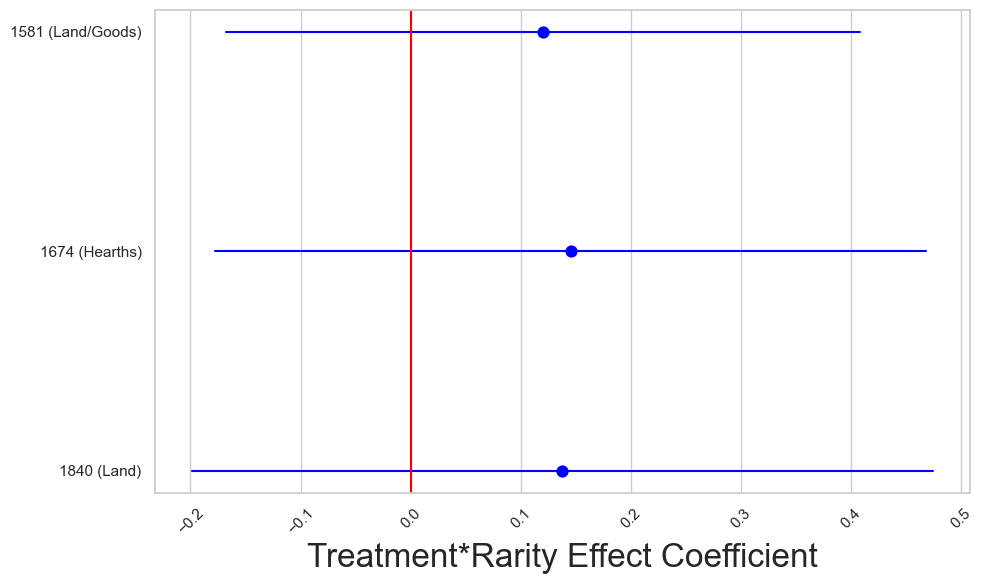

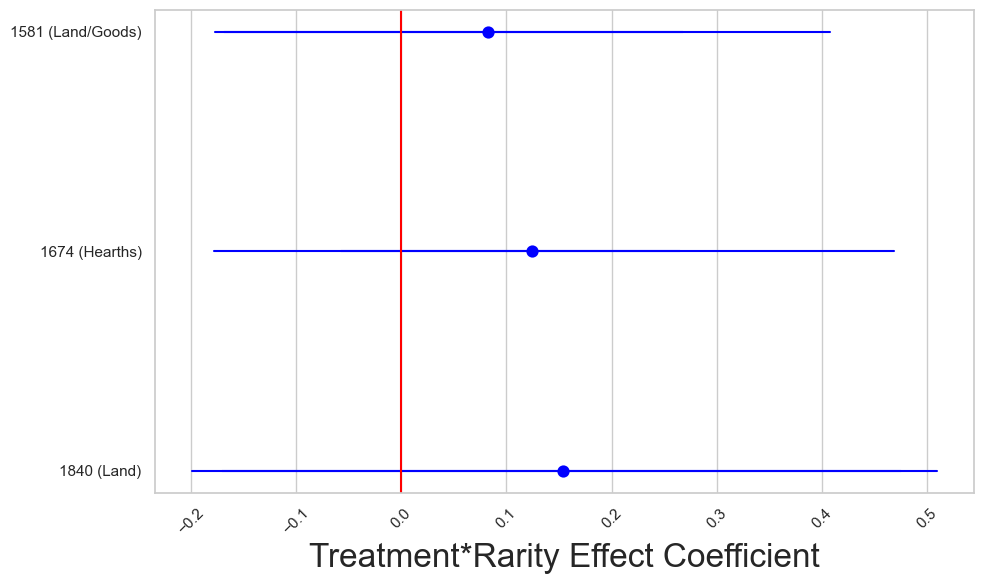

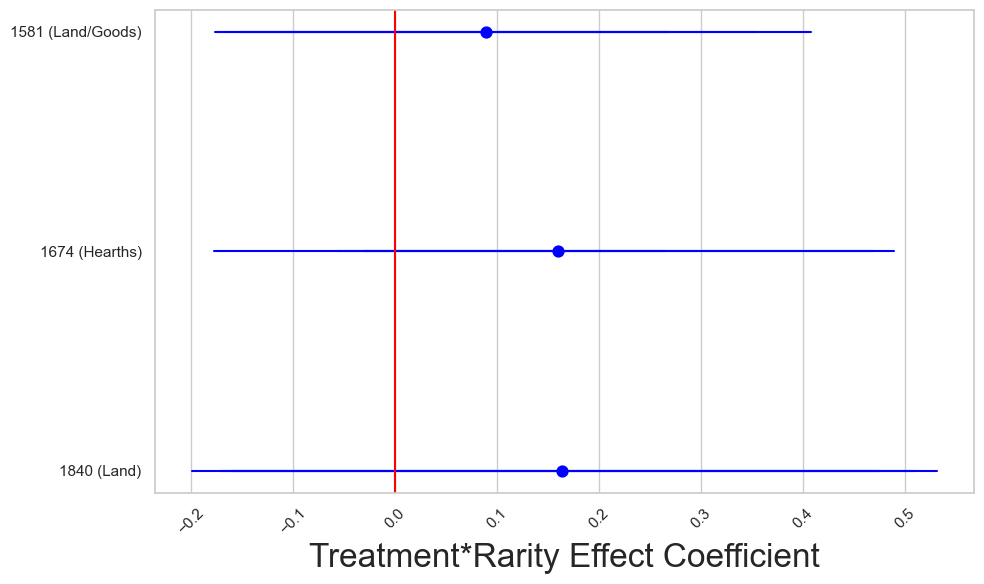

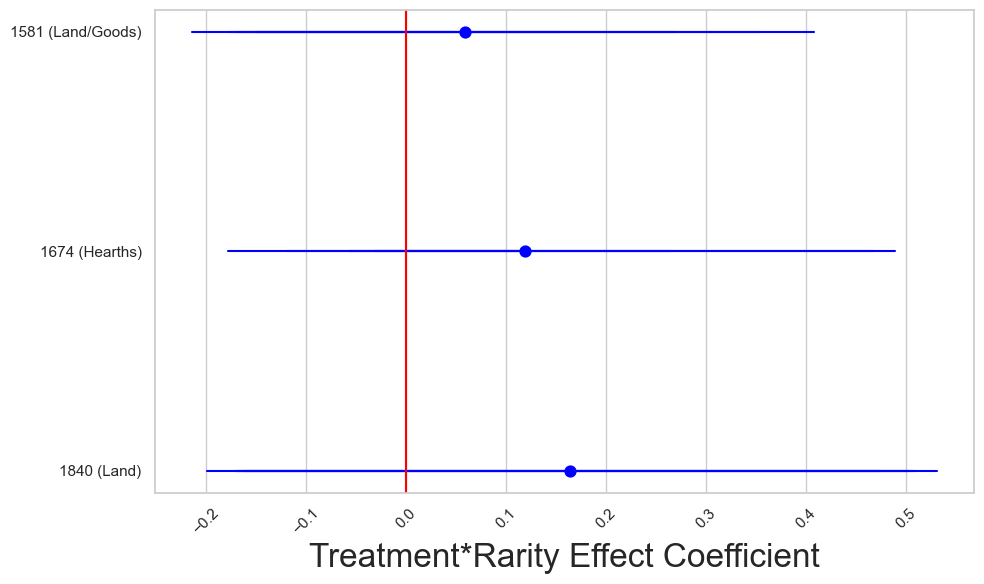

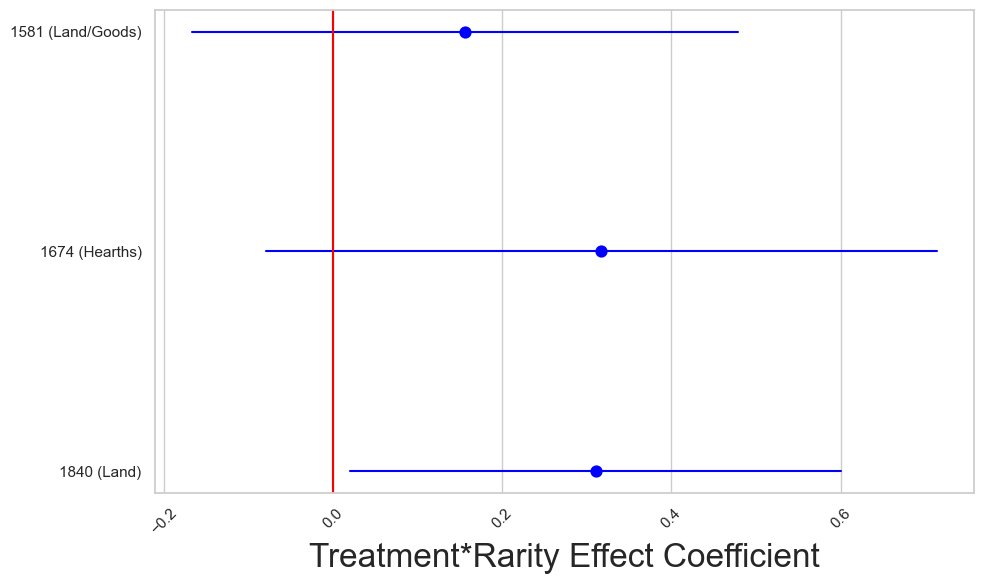

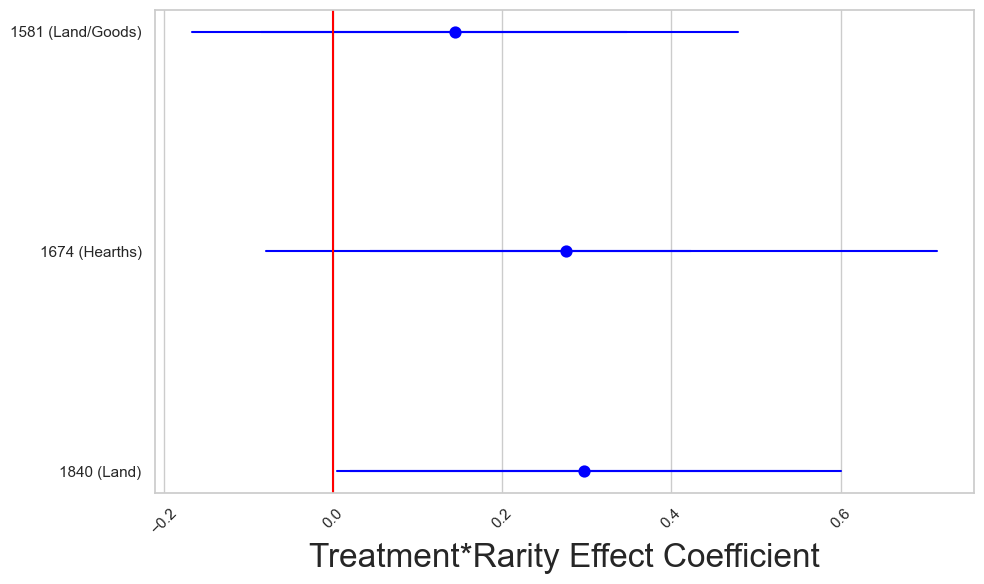

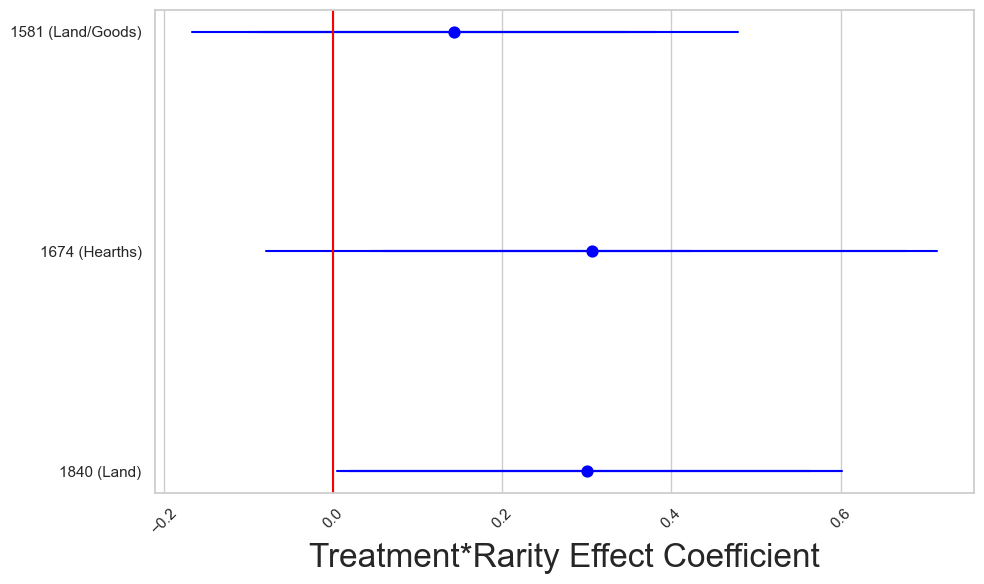

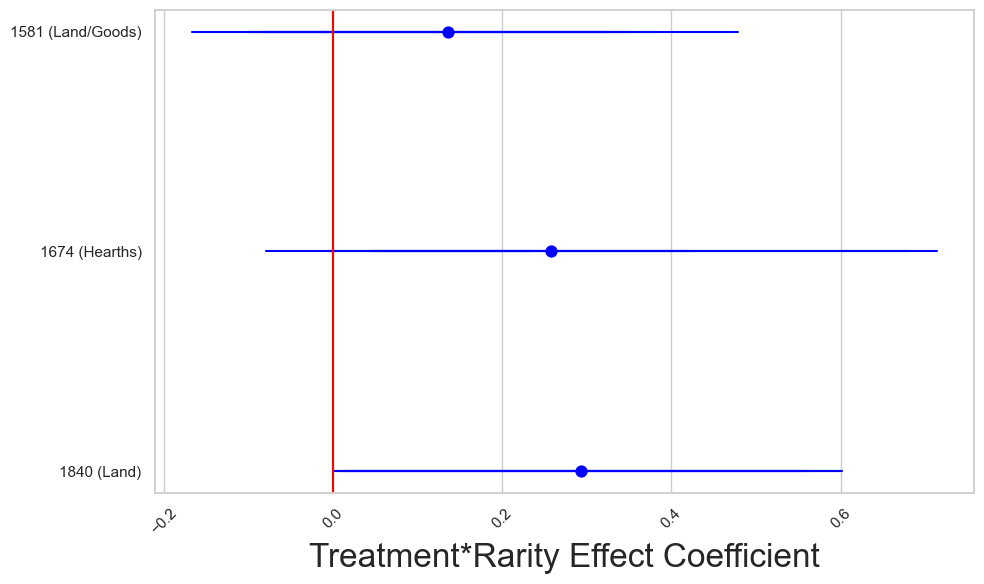

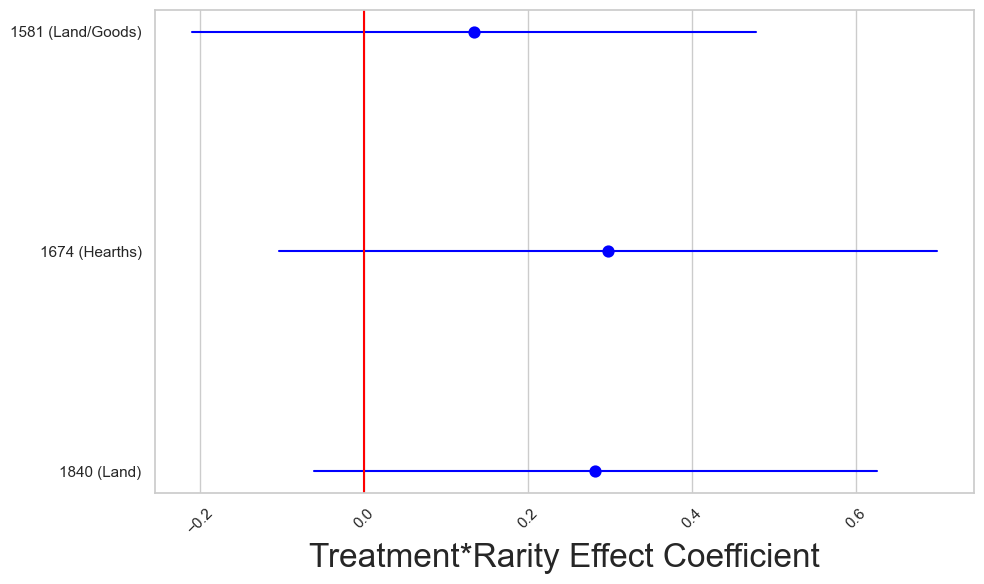

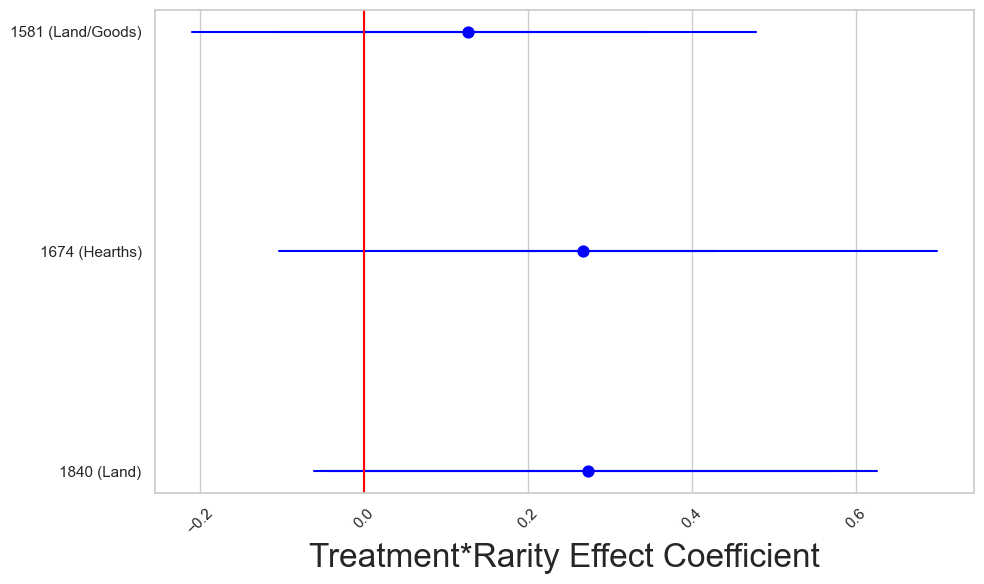

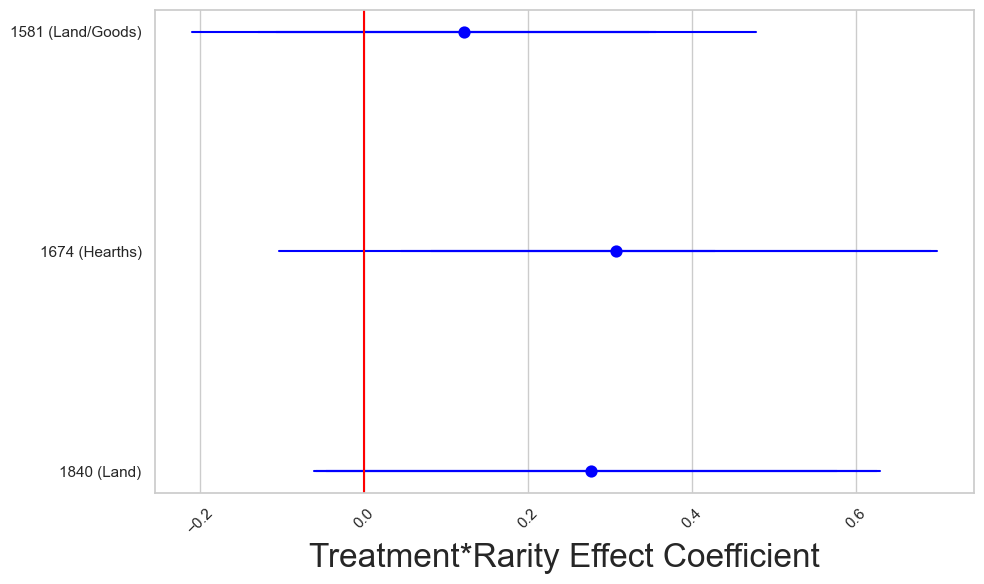

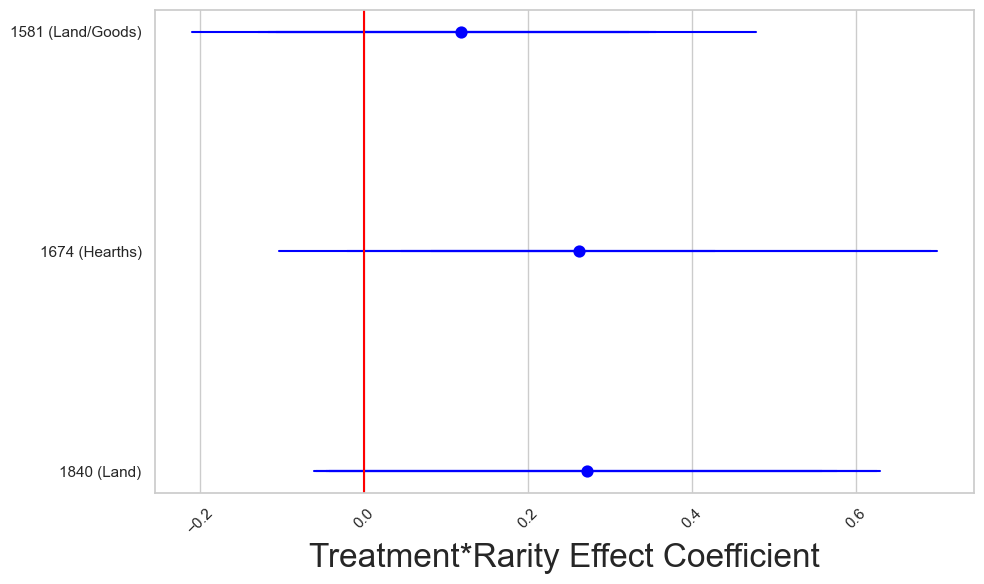

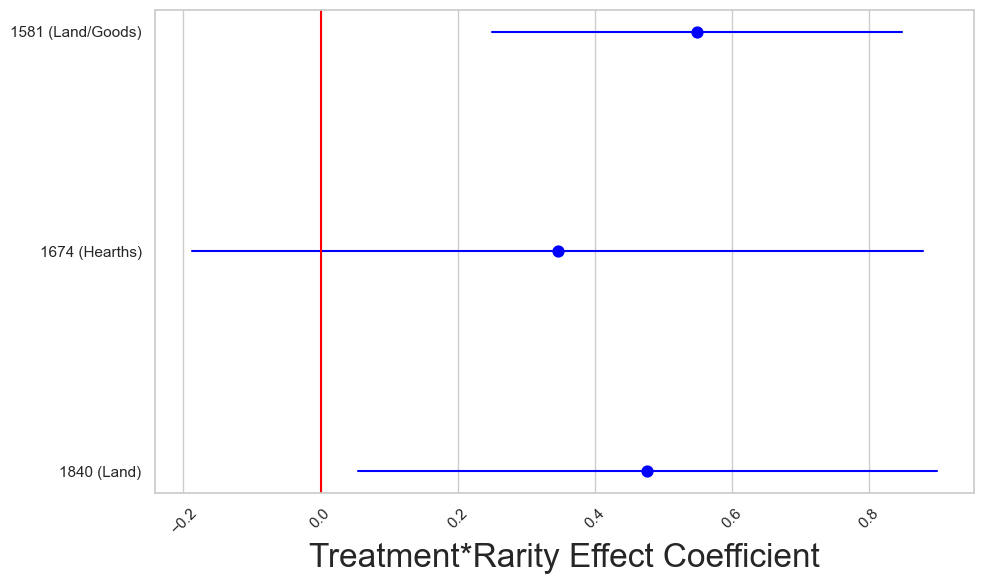

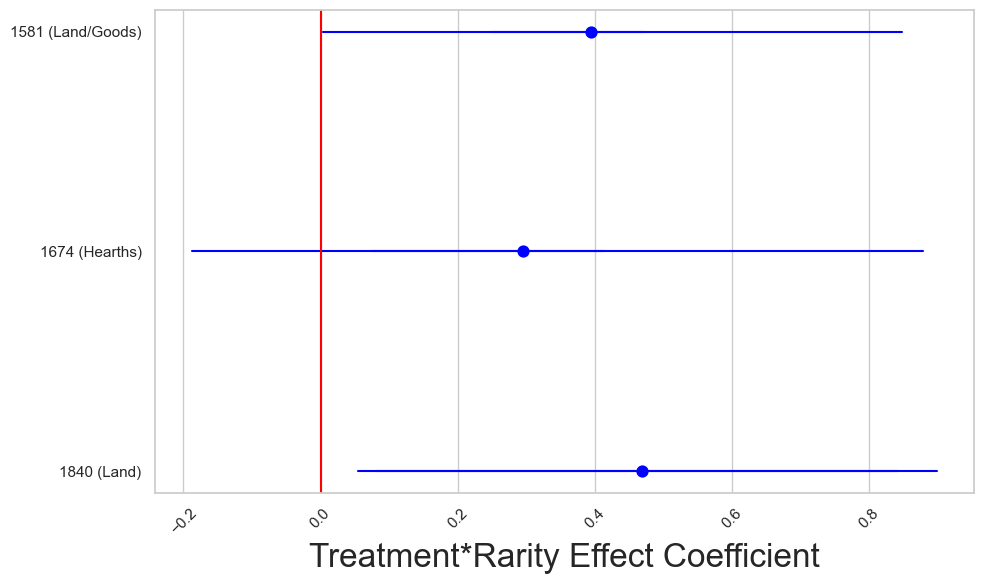

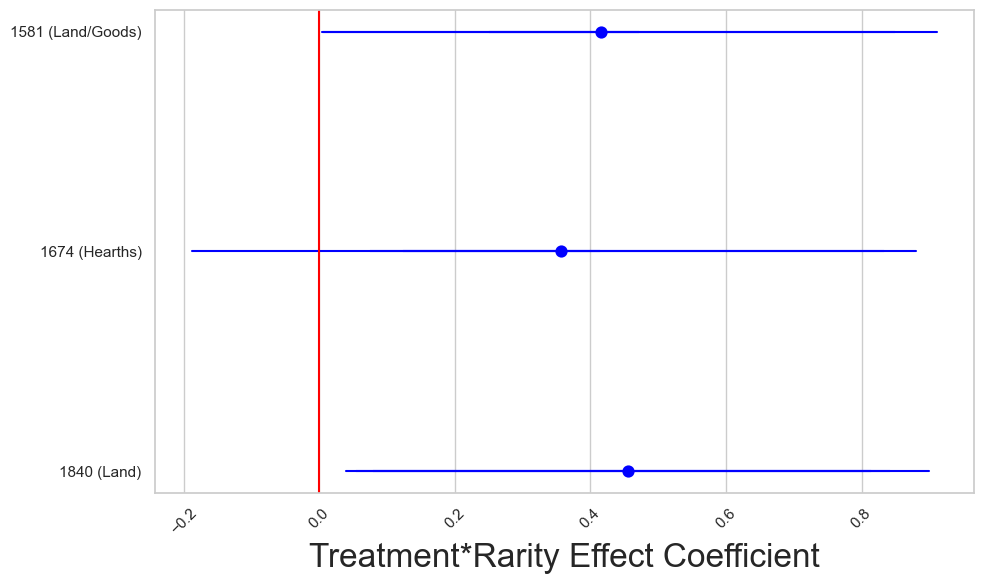

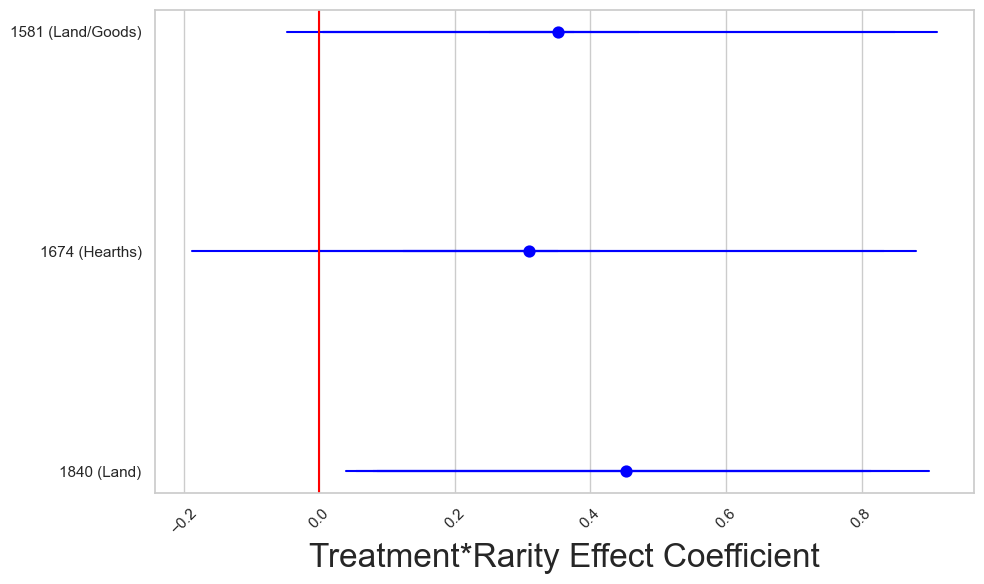

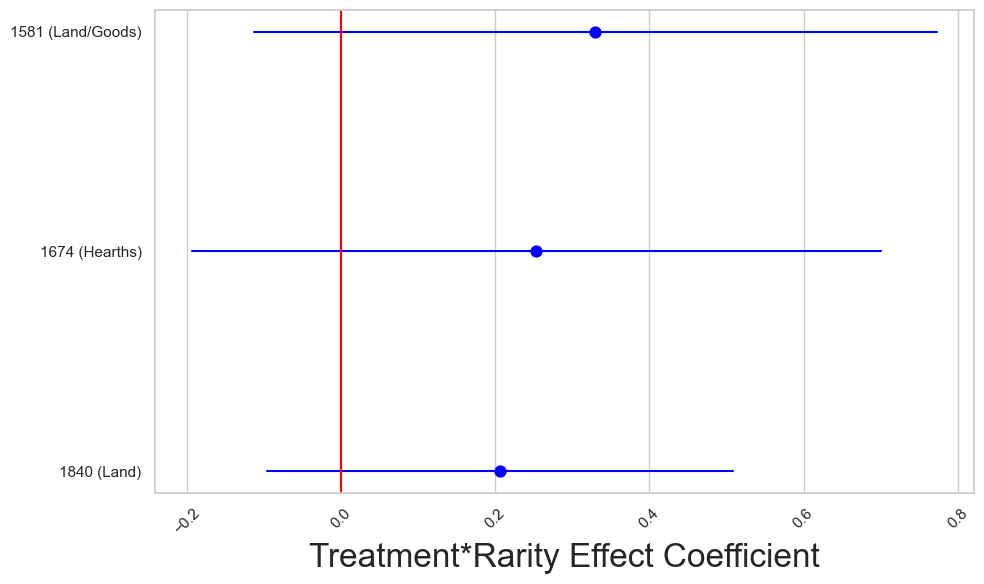

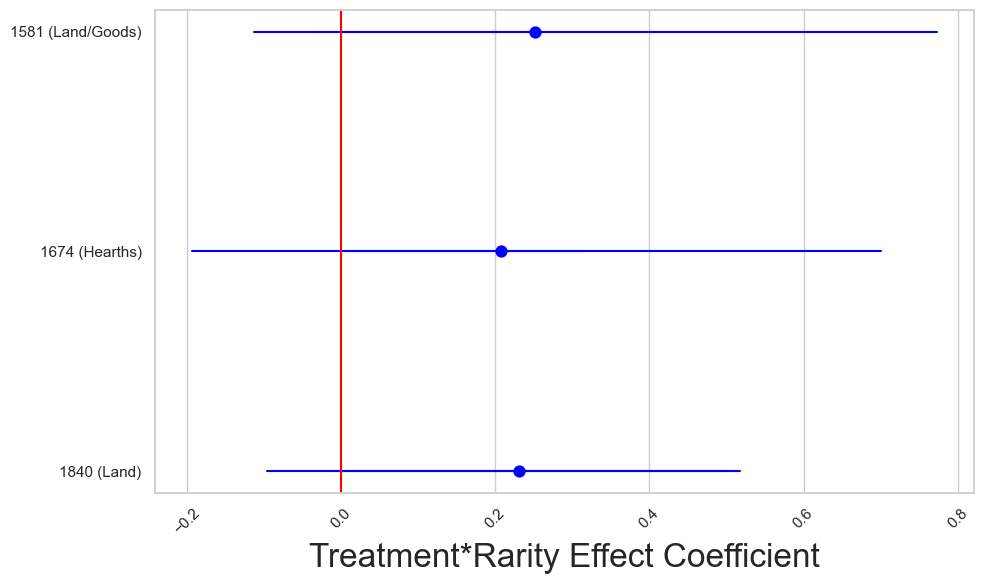

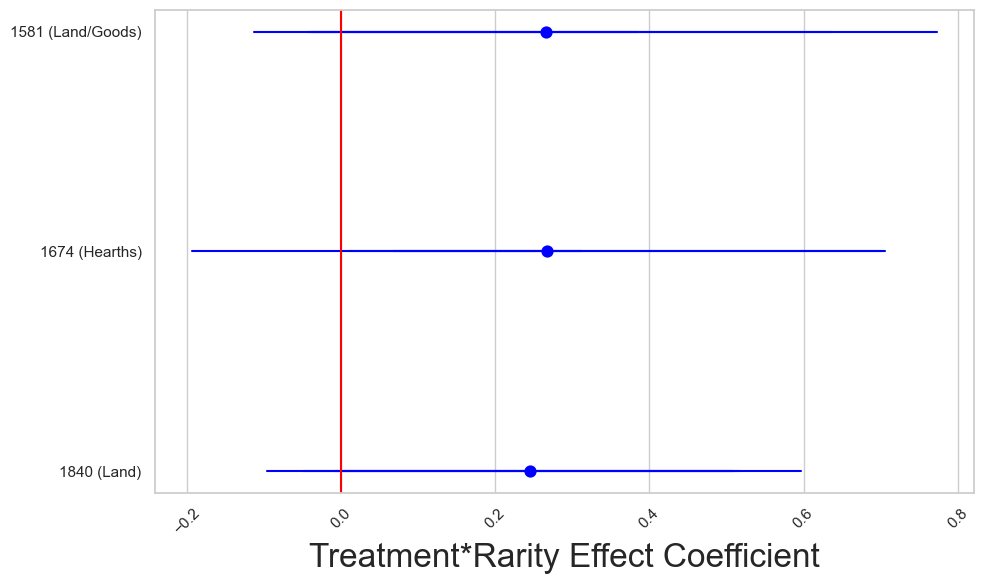

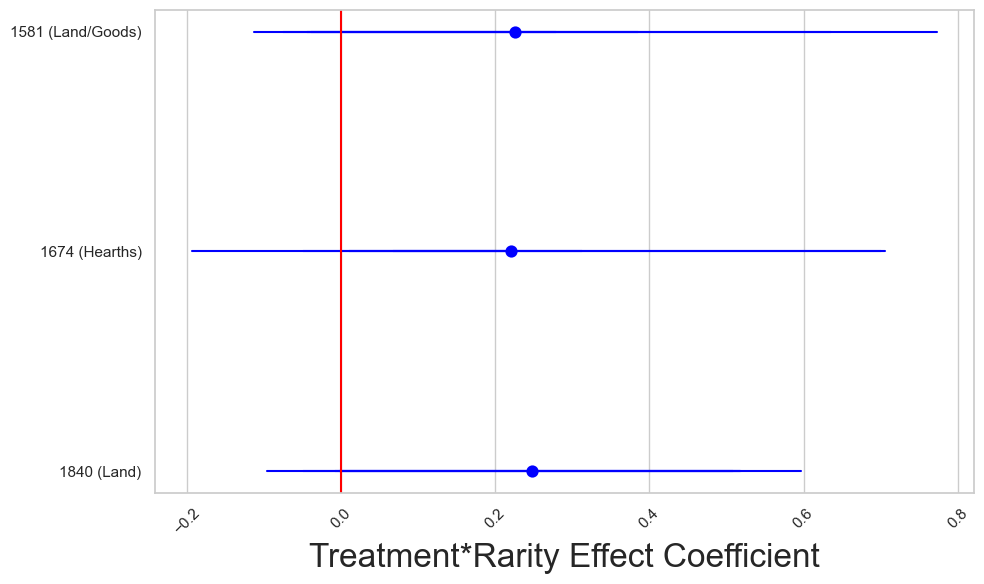

In [14]:
for id_type in [
    'unique',
    'group',
    'combined',
    'metaphone',
    'master'
]:

    df = pd.read_csv(f'{SURNAMES}/{id_type}_id_subsidy_data.csv')
    df['count_pctile_1524'] = df['count_1524'].rank(pct=True)
    df['rarity_1524'] = 1 - df['count_pctile_1524']
    df['treatment_rarity'] = df['treatment'] * df['rarity_1524']
    with open(f'{PROCESSED}/pretty_dict.json', 'r', encoding='utf-8') as f:
        pretty_dict = json.load(f)

    for year in [
        1524, 
        1543,
        1581,
        1674,
        1840
    ]:
        for measure in [
            'avg_val',
            'tot_val',
            'max_val',
            'count',
        ]:
            # fill zeroes with nan
            df[f'{measure}_{year}'] = df[f'{measure}_{year}'].apply(lambda x: 0 if pd.isna(x) else x)

    years_list = [1524, 1581, 1674, 1840]
    plot_df_list = []
    for measure in [
        'avg_val',
        'tot_val',
        'max_val',
        'count'
    ]:

        results_list = []
        for i, year in enumerate(years_list):
            if year == 1524:
                continue
            last_year = years_list[i - 1]

            sub_df = df.copy()
            sub_df = sub_df.loc[~pd.isna(sub_df['control2_group'])]
            sub_df[f'{measure}_pctile_1524'] = sub_df[f'{measure}_{1524}'].rank(pct=True)
            sub_df[f'{measure}_pctile_{year}'] = sub_df[f'{measure}_{year}'].rank(pct=True)
            sub_df[f'{measure}_pctile_{last_year}'] = sub_df[f'{measure}_{last_year}'].rank(pct=True)


            x_vars = ['parish_distriver', 'parish_distmkt', f'ln_parish_avg_value_{last_year}', f'parish_pop_density_{last_year}', 'ln_parish_monastic_land']

            sub_df = sub_df.dropna(subset=[f'{measure}_{year}'] + x_vars + ['treatment', 'control'])

            x = sub_df[['treatment_rarity'] + x_vars]
            dummies = pd.get_dummies(sub_df['control2_group'], prefix='Control2', drop_first=True, dtype=int)
            x = pd.concat([x, dummies], axis=1)
            
            x.rename(columns={
                'treatment_rarity': 'Treatment*Rarity',
                'treatment': 'Treatment',
                'control': 'Control',
                f'avg_val_pctile_{last_year}': f'Previous Avg Value Percentile',
                f'tot_val_pctile_{last_year}': f'Previous Total Value Percentile',
                f'max_val_pctile_{last_year}': f'Previous Max Value Percentile',
                f'count_pctile_{last_year}': f'Previous Count Percentile',
                f'avg_val_pctile_1524': f'1524 Avg Value Percentile',
                f'tot_val_pctile_1524': f'1524 Total Value Percentile',
                f'max_val_pctile_1524': f'1524 Max Value Percentile',
                f'count_pctile_1524': f'1524 Count Percentile',
                f'parish_avg_value_{last_year}': 'Previous Parish Avg Value',
                f'parish_pop_density_{last_year}': 'Previous Parish Pop Density',
                'ln_parish_monastic_land': 'ln(Parish Monastic Land)',
                f'ln_parish_avg_value_{last_year}': 'ln(Previous Parish Avg Value)',
                f'parish_pop_density_{last_year}': 'Previous Parish Pop Density',
                'parish_distriver': 'Parish Distance to River',
                'parish_distmkt': 'Parish Distance to Market'
            }, inplace=True)
            y = sub_df[f'{measure}_pctile_{year}']
            x = sm.add_constant(x)
            x_cols = x.columns.tolist()
            for col in x_cols:
                if not col.startswith('Control2_'):
                    continue
                if x[col].sum() < 2:
                    x.drop(columns=[col], inplace=True)

            
            model = sm.OLS(y, x)
            result = model.fit(cov_type='HC3')
            results_list.append(result)
            
            plot_df_list.append({
                'year': year,
                'coef': result.params['Treatment*Rarity'],
                'se': result.bse['Treatment*Rarity']
            })
        table = summary_col(results_list, stars=True, model_names=years_list[1:], info_dict={'N': lambda x: "{0:d}".format(int(x.nobs))}).as_latex()
        
        table = table.replace('\\begin{center}', '\\begin{center}\n\\resizebox{\\textwidth}{!}{')
        table = table.replace('\\end{tabular}', '\\end{tabular}\n}')
        table = table.replace('p<', 'p$<$')
        table = re.sub(r'(Control2[^\n]*\n\s*&[^\n]*\n)+', r'Match-Group Dummies & Y & Y & Y \\\\ \n', table)
        print(f'Writing table for {id_type.title()} and {measure}')
        print(table)
        with open(f'{TABLES}/{id_type}_{measure}_matched_results_1524.tex', 'w', encoding='utf-8') as f:
            f.write(table)

        plot_df = pd.DataFrame(plot_df_list)
        plot_df['lower'] = plot_df['coef'] - 1.96 * plot_df['se']
        plot_df['upper'] = plot_df['coef'] + 1.96 * plot_df['se']
        plot_df['year'] = plot_df['year'].astype(str)
        year_replace = {'1581': '1581 (Land/Goods)',
                        '1674': '1674 (Hearths)',
                        '1840': '1840 (Land)'}
        plot_df['year'] = plot_df['year'].replace(year_replace)
        plt.figure(figsize=(10, 6))
        sns.set_theme(style='whitegrid')
        sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
        for i, row in plot_df.iterrows():
            plt.plot([row['lower'], row['upper']], [row['year'], row['year']], color='blue')
        plt.xticks(rotation=45)
        plt.ylabel(None)
        plt.xlabel('Treatment*Rarity Effect Coefficient', fontsize=24)
        plt.tight_layout()
        plt.axvline(x=0, color='red')
        plt.savefig(f'{IMAGES}/{id_type}_{measure}_treatment_effects_1524_zeroes_rarity.png', dpi=300)

#### Matching Estimator, Drop Zeroes

Writing table for Unique and avg_val
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581       & 1674      & 1840        \\
\hline
const                         & -0.1826    & 0.0508    & 0.5644      \\
                              & (1.2570)   & (0.7887)  & (0.9392)    \\
Treatment                     & 0.1165     & 0.0024    & 0.0003      \\
                              & (0.1026)   & (0.0842)  & (0.0847)    \\
Previous Avg Value Percentile & 0.6777*    & 0.0963    & 0.2190      \\
                              & (0.4006)   & (0.1477)  & (0.1956)    \\
Parish Distance to River      & 0.0508     & 0.0645    & -0.0138     \\
                              & (0.0718)   & (0.0453)  & (0.0498)    \\
Parish Distance to Market     & -0.0094    & -0.0454   & 0.0371      \\
                              & (0.0464)   & (0.0327)  & (0.0274)    \\
ln(Previous Parish Avg Value) & 0.3622     & 0.3921    & -0

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2088580350.py:114: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2088580350.py:114: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Unique and tot_val
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                                & 1581     & 1674      & 1840      \\
\hline
const                           & 1.0590   & 0.5226    & -0.5448   \\
                                & (1.2133) & (0.6653)  & (0.9121)  \\
Treatment                       & 0.1267   & -0.0633   & 0.1381    \\
                                & (0.1104) & (0.0736)  & (0.0841)  \\
Previous Total Value Percentile & 0.7002*  & 0.3836*** & 0.5102**  \\
                                & (0.4161) & (0.1064)  & (0.2065)  \\
Parish Distance to River        & 0.0008   & 0.0135    & -0.0317   \\
                                & (0.0555) & (0.0442)  & (0.0349)  \\
Parish Distance to Market       & -0.0005  & -0.0275   & 0.0328    \\
                                & (0.0398) & (0.0347)  & (0.0328)  \\
ln(Previous Parish Avg Value)   & -0.3574  & 0.2772    & 0.4261    \\
           

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2088580350.py:114: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2088580350.py:114: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Unique and max_val
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581      & 1674      & 1840        \\
\hline
const                         & 1.6288    & 0.3489    & 0.6255      \\
                              & (1.1923)  & (0.7526)  & (1.1002)    \\
Treatment                     & 0.1900    & 0.0466    & 0.0651      \\
                              & (0.1167)  & (0.0980)  & (0.0966)    \\
Previous Max Value Percentile & 0.1830    & 0.1301    & 0.2382      \\
                              & (0.4018)  & (0.1491)  & (0.1871)    \\
Parish Distance to River      & 0.0785    & 0.0079    & -0.0110     \\
                              & (0.0736)  & (0.0422)  & (0.0413)    \\
Parish Distance to Market     & -0.0452   & -0.0237   & 0.0209      \\
                              & (0.0538)  & (0.0414)  & (0.0345)    \\
ln(Previous Parish Avg Value) & -0.4338   & 0.2927    & -0.2345     \\

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2088580350.py:114: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2088580350.py:114: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Unique and count
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581     & 1674      & 1840       \\
\hline
const                         & 1.5992   & 0.5487    & -0.9719    \\
                              & (1.2164) & (0.6278)  & (0.8403)   \\
Treatment                     & 0.1014   & -0.0405   & 0.1561*    \\
                              & (0.0824) & (0.0626)  & (0.0864)   \\
Previous Count Percentile     & 0.5501   & 0.3900*** & 0.5456***  \\
                              & (0.5684) & (0.1004)  & (0.2092)   \\
Parish Distance to River      & 0.0306   & -0.0075   & -0.0305    \\
                              & (0.0581) & (0.0450)  & (0.0340)   \\
Parish Distance to Market     & -0.0370  & -0.0085   & 0.0358     \\
                              & (0.0426) & (0.0294)  & (0.0315)   \\
ln(Previous Parish Avg Value) & -0.5841  & 0.2712    & 0.7689     \\
                         

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2088580350.py:114: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2088580350.py:114: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Group and avg_val
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581      & 1674       & 1840      \\
\hline
const                         & 1.0688    & 0.2499     & 0.3101    \\
                              & (0.9567)  & (0.8491)   & (1.1878)  \\
Treatment                     & 0.2662*** & 0.1689**   & 0.0454    \\
                              & (0.0778)  & (0.0658)   & (0.0913)  \\
Previous Avg Value Percentile & 0.1127    & 0.1232     & 0.0909    \\
                              & (0.2735)  & (0.1330)   & (0.1700)  \\
Parish Distance to River      & -0.0395   & -0.0137    & -0.0099   \\
                              & (0.0575)  & (0.0534)   & (0.0443)  \\
Parish Distance to Market     & 0.0163    & -0.0207    & 0.0379    \\
                              & (0.0460)  & (0.0458)   & (0.0376)  \\
ln(Previous Parish Avg Value) & -0.4905   & 0.2737     & -0.2809   \\
            

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2088580350.py:114: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2088580350.py:114: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Group and tot_val
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                                & 1581       & 1674       & 1840       \\
\hline
const                           & 1.0473     & -0.3566    & 0.1331     \\
                                & (0.9559)   & (0.2917)   & (0.8543)   \\
Treatment                       & 0.1003     & 0.0088     & 0.1075     \\
                                & (0.0753)   & (0.0401)   & (0.0665)   \\
Previous Total Value Percentile & 0.7734***  & 0.4415***  & 0.7440***  \\
                                & (0.2554)   & (0.0918)   & (0.1148)   \\
Parish Distance to River        & -0.0124    & 0.0107     & -0.0241    \\
                                & (0.0681)   & (0.0301)   & (0.0377)   \\
Parish Distance to Market       & -0.0059    & -0.0098    & -0.0009    \\
                                & (0.0516)   & (0.0233)   & (0.0277)   \\
ln(Previous Parish Avg Value)   & -0.5

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2088580350.py:114: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2088580350.py:114: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Group and max_val
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581       & 1674       & 1840      \\
\hline
const                         & 1.6299     & -0.4804    & 0.6473    \\
                              & (1.0230)   & (0.4918)   & (0.9156)  \\
Treatment                     & 0.2474***  & 0.1390**   & 0.0581    \\
                              & (0.0915)   & (0.0582)   & (0.0796)  \\
Previous Max Value Percentile & 0.3578     & 0.2368**   & 0.3330**  \\
                              & (0.4305)   & (0.1046)   & (0.1532)  \\
Parish Distance to River      & -0.0078    & -0.0066    & -0.0353   \\
                              & (0.0808)   & (0.0321)   & (0.0502)  \\
Parish Distance to Market     & -0.0287    & -0.0041    & -0.0052   \\
                              & (0.0584)   & (0.0293)   & (0.0324)  \\
ln(Previous Parish Avg Value) & -0.7043    & 0.4791     & -0.0246   \\


C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2088580350.py:114: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2088580350.py:114: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Group and count
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581      & 1674       & 1840        \\
\hline
const                         & 0.6260    & -0.5114    & -0.5360     \\
                              & (0.7426)  & (0.4307)   & (0.8738)    \\
Treatment                     & 0.0672    & -0.0131    & 0.1273*     \\
                              & (0.0629)  & (0.0370)   & (0.0684)    \\
Previous Count Percentile     & 0.9552*** & 0.4070***  & 0.7460***   \\
                              & (0.1641)  & (0.1094)   & (0.1178)    \\
Parish Distance to River      & -0.0142   & 0.0101     & -0.0232     \\
                              & (0.0625)  & (0.0281)   & (0.0391)    \\
Parish Distance to Market     & 0.0084    & -0.0134    & 0.0114      \\
                              & (0.0421)  & (0.0218)   & (0.0284)    \\
ln(Previous Parish Avg Value) & -0.3656   & 0.4200     & 0.669

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2088580350.py:114: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2088580350.py:114: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Combined and avg_val
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581      & 1674      & 1840        \\
\hline
const                         & 1.1536    & 0.0496    & -0.5346     \\
                              & (1.2684)  & (0.8399)  & (1.0969)    \\
Treatment                     & 0.2666*** & 0.1906*** & 0.0292      \\
                              & (0.0888)  & (0.0720)  & (0.1001)    \\
Previous Avg Value Percentile & -0.0222   & 0.2064    & -0.1218     \\
                              & (0.2132)  & (0.1467)  & (0.1977)    \\
Parish Distance to River      & -0.0266   & 0.0198    & 0.0585      \\
                              & (0.0456)  & (0.0424)  & (0.0378)    \\
Parish Distance to Market     & 0.0090    & -0.0253   & 0.0190      \\
                              & (0.0384)  & (0.0336)  & (0.0369)    \\
ln(Previous Parish Avg Value) & -0.4795   & 0.3716    & 0.6393      

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2088580350.py:114: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2088580350.py:114: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Combined and tot_val
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                                & 1581       & 1674       & 1840        \\
\hline
const                           & 1.3170     & -0.3257    & -0.5922     \\
                                & (1.2259)   & (0.3577)   & (0.6308)    \\
Treatment                       & 0.1070     & 0.0265     & 0.0679      \\
                                & (0.0724)   & (0.0445)   & (0.0664)    \\
Previous Total Value Percentile & 0.4224     & 0.5772***  & 0.6029***   \\
                                & (0.3361)   & (0.0868)   & (0.1246)    \\
Parish Distance to River        & 0.0107     & 0.0219     & 0.0380      \\
                                & (0.0284)   & (0.0185)   & (0.0254)    \\
Parish Distance to Market       & -0.0229    & -0.0091    & -0.0171     \\
                                & (0.0311)   & (0.0176)   & (0.0228)    \\
ln(Previous Parish Avg V

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2088580350.py:114: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2088580350.py:114: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Combined and max_val
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581       & 1674       & 1840        \\
\hline
const                         & 1.7375     & -0.4331    & -0.2584     \\
                              & (1.4847)   & (0.4769)   & (0.9886)    \\
Treatment                     & 0.2690***  & 0.1714***  & 0.0263      \\
                              & (0.0831)   & (0.0600)   & (0.0782)    \\
Previous Max Value Percentile & -0.1209    & 0.3040***  & 0.1714      \\
                              & (0.3005)   & (0.1133)   & (0.1444)    \\
Parish Distance to River      & -0.0012    & 0.0139     & 0.0480*     \\
                              & (0.0415)   & (0.0315)   & (0.0280)    \\
Parish Distance to Market     & -0.0223    & -0.0050    & -0.0284     \\
                              & (0.0451)   & (0.0223)   & (0.0319)    \\
ln(Previous Parish Avg Value) & -0.6653    & 0

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2088580350.py:114: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2088580350.py:114: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Combined and count
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581       & 1674       & 1840        \\
\hline
const                         & 0.7874     & -0.4143    & -0.7872     \\
                              & (0.6909)   & (0.3355)   & (0.6066)    \\
Treatment                     & 0.0268     & -0.0030    & 0.1016      \\
                              & (0.0491)   & (0.0368)   & (0.0661)    \\
Previous Count Percentile     & 0.6778***  & 0.6049***  & 0.6842***   \\
                              & (0.2165)   & (0.1028)   & (0.1135)    \\
Parish Distance to River      & 0.0149     & 0.0099     & 0.0245      \\
                              & (0.0225)   & (0.0172)   & (0.0248)    \\
Parish Distance to Market     & -0.0140    & -0.0054    & -0.0032     \\
                              & (0.0231)   & (0.0163)   & (0.0215)    \\
ln(Previous Parish Avg Value) & -0.3790    & 0.2

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2088580350.py:114: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2088580350.py:114: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Metaphone and avg_val
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581      & 1674      & 1840      \\
\hline
const                         & 0.2639    & 1.1148    & -0.1623   \\
                              & (1.2971)  & (1.0078)  & (1.1139)  \\
Treatment                     & 0.1832*** & 0.1923*** & 0.0560    \\
                              & (0.0696)  & (0.0574)  & (0.0666)  \\
Previous Avg Value Percentile & -0.1196   & 0.0604    & -0.0611   \\
                              & (0.1825)  & (0.1102)  & (0.1154)  \\
Parish Distance to River      & -0.0178   & -0.0104   & -0.0012   \\
                              & (0.0566)  & (0.0323)  & (0.0389)  \\
Parish Distance to Market     & 0.0069    & 0.0182    & 0.0054    \\
                              & (0.0421)  & (0.0313)  & (0.0380)  \\
ln(Previous Parish Avg Value) & 0.1956    & -0.3323   & -0.0878   \\
                    

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2088580350.py:114: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2088580350.py:114: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Metaphone and tot_val
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                                & 1581      & 1674      & 1840       \\
\hline
const                           & -0.5455   & -0.1403   & 0.5399     \\
                                & (0.6574)  & (0.4769)  & (0.6412)   \\
Treatment                       & 0.0943*** & 0.0206    & 0.0794     \\
                                & (0.0363)  & (0.0285)  & (0.0530)   \\
Previous Total Value Percentile & 0.9563*** & 0.5492*** & 0.6295***  \\
                                & (0.2714)  & (0.0765)  & (0.1514)   \\
Parish Distance to River        & -0.0201   & 0.0169    & -0.0060    \\
                                & (0.0139)  & (0.0207)  & (0.0341)   \\
Parish Distance to Market       & 0.0135    & 0.0053    & 0.0223     \\
                                & (0.0166)  & (0.0149)  & (0.0291)   \\
ln(Previous Parish Avg Value)   & 0.4556    & 0.0116    

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2088580350.py:114: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2088580350.py:114: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Metaphone and max_val
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581      & 1674      & 1840       \\
\hline
const                         & 0.2413    & 0.1794    & 0.9080     \\
                              & (1.0870)  & (0.8124)  & (0.7647)   \\
Treatment                     & 0.2084*** & 0.1900*** & 0.0440     \\
                              & (0.0595)  & (0.0580)  & (0.0647)   \\
Previous Max Value Percentile & 0.2312    & 0.2513**  & 0.2302**   \\
                              & (0.2618)  & (0.1028)  & (0.1170)   \\
Parish Distance to River      & -0.0289   & 0.0075    & 0.0189     \\
                              & (0.0324)  & (0.0364)  & (0.0353)   \\
Parish Distance to Market     & 0.0412    & 0.0083    & 0.0106     \\
                              & (0.0303)  & (0.0290)  & (0.0294)   \\
ln(Previous Parish Avg Value) & 0.1944    & 0.0733    & -0.5000    \\
        

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2088580350.py:114: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2088580350.py:114: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Metaphone and count
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581      & 1674      & 1840       \\
\hline
const                         & -0.7034   & -0.5223   & 0.3130     \\
                              & (0.5311)  & (0.4290)  & (0.6182)   \\
Treatment                     & 0.0486*   & -0.0069   & 0.1053**   \\
                              & (0.0263)  & (0.0228)  & (0.0490)   \\
Previous Count Percentile     & 0.9258*** & 0.6328*** & 0.5651***  \\
                              & (0.1940)  & (0.0927)  & (0.1640)   \\
Parish Distance to River      & -0.0203*  & 0.0182    & 0.0077     \\
                              & (0.0110)  & (0.0170)  & (0.0346)   \\
Parish Distance to Market     & 0.0257    & 0.0058    & 0.0145     \\
                              & (0.0157)  & (0.0119)  & (0.0326)   \\
ln(Previous Parish Avg Value) & 0.4757*   & 0.2317    & 0.1898     \\
          

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2088580350.py:114: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2088580350.py:114: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Master and avg_val
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581      & 1674      & 1840       \\
\hline
const                         & 1.5338    & 0.3386    & -0.8082    \\
                              & (1.0950)  & (0.6589)  & (0.9445)   \\
Treatment                     & 0.1991*** & 0.1260**  & -0.0087    \\
                              & (0.0652)  & (0.0622)  & (0.0797)   \\
Previous Avg Value Percentile & 0.2336    & 0.2487**  & 0.0609     \\
                              & (0.2168)  & (0.1050)  & (0.1515)   \\
Parish Distance to River      & -0.0082   & 0.0917*** & 0.0338     \\
                              & (0.0481)  & (0.0352)  & (0.0575)   \\
Parish Distance to Market     & 0.0078    & 0.0116    & 0.0076     \\
                              & (0.0340)  & (0.0269)  & (0.0265)   \\
ln(Previous Parish Avg Value) & -0.3104   & 0.0949    & 0.9982     \\
           

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2088580350.py:114: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2088580350.py:114: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Master and tot_val
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                                & 1581       & 1674      & 1840       \\
\hline
const                           & 1.0827     & 0.0166    & -0.3719    \\
                                & (0.7162)   & (0.5270)  & (0.6646)   \\
Treatment                       & 0.1001**   & 0.0013    & 0.0765     \\
                                & (0.0470)   & (0.0374)  & (0.0565)   \\
Previous Total Value Percentile & 0.2982     & 0.5538*** & 0.6449***  \\
                                & (0.2641)   & (0.1057)  & (0.1409)   \\
Parish Distance to River        & -0.0042    & 0.0395**  & -0.0261    \\
                                & (0.0205)   & (0.0196)  & (0.0366)   \\
Parish Distance to Market       & 0.0025     & 0.0007    & 0.0089     \\
                                & (0.0175)   & (0.0172)  & (0.0191)   \\
ln(Previous Parish Avg Value)   & -0.3697    & 0

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2088580350.py:114: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2088580350.py:114: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Master and max_val
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581      & 1674       & 1840       \\
\hline
const                         & 1.3529    & -0.1503    & -0.8348    \\
                              & (0.9772)  & (0.6529)   & (0.8151)   \\
Treatment                     & 0.2071*** & 0.1496**   & -0.0147    \\
                              & (0.0669)  & (0.0602)   & (0.0660)   \\
Previous Max Value Percentile & 0.1767    & 0.3273***  & 0.3026***  \\
                              & (0.2838)  & (0.0936)   & (0.1073)   \\
Parish Distance to River      & -0.0005   & 0.0524*    & -0.0289    \\
                              & (0.0282)  & (0.0287)   & (0.0424)   \\
Parish Distance to Market     & 0.0058    & 0.0182     & 0.0185     \\
                              & (0.0249)  & (0.0258)   & (0.0188)   \\
ln(Previous Parish Avg Value) & -0.2530   & 0.1310     & 1.0050     \\

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2088580350.py:114: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2088580350.py:114: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Master and count
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581       & 1674      & 1840        \\
\hline
const                         & 0.7150     & -0.1958   & -0.3288     \\
                              & (0.7077)   & (0.4237)  & (0.6266)    \\
Treatment                     & 0.0311     & -0.0186   & 0.1016*     \\
                              & (0.0323)   & (0.0273)  & (0.0557)    \\
Previous Count Percentile     & 0.3743     & 0.6711*** & 0.6814***   \\
                              & (0.3007)   & (0.1077)  & (0.1650)    \\
Parish Distance to River      & -0.0011    & 0.0233    & -0.0216     \\
                              & (0.0201)   & (0.0180)  & (0.0399)    \\
Parish Distance to Market     & 0.0060     & -0.0050   & 0.0074      \\
                              & (0.0176)   & (0.0149)  & (0.0175)    \\
ln(Previous Parish Avg Value) & -0.2809    & 0.1286    & 0.50

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2088580350.py:114: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2088580350.py:114: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


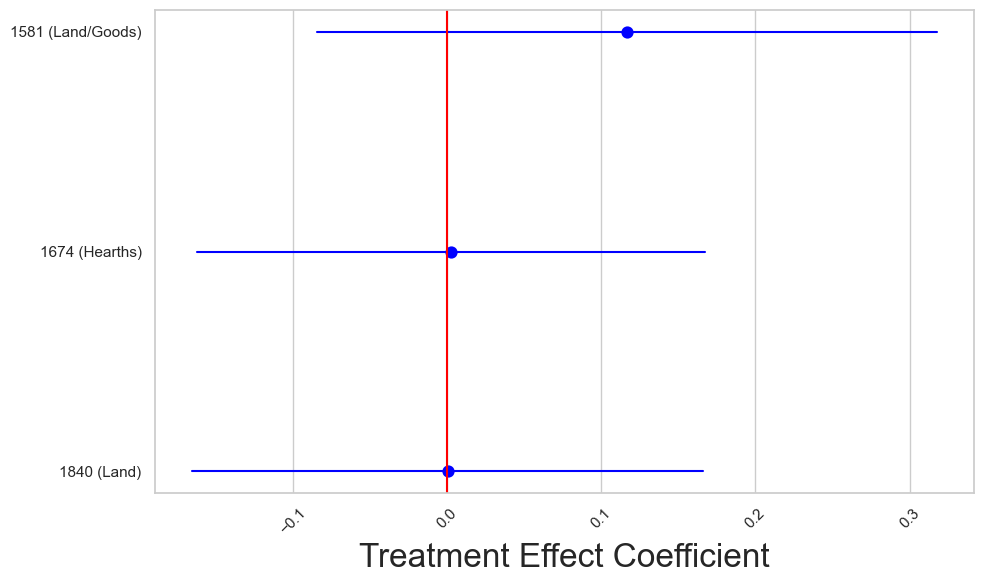

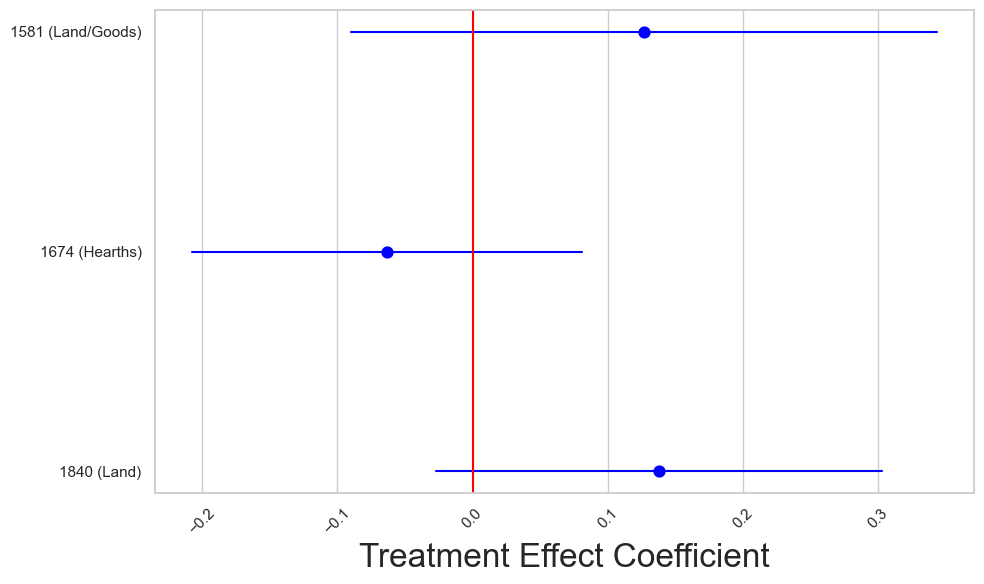

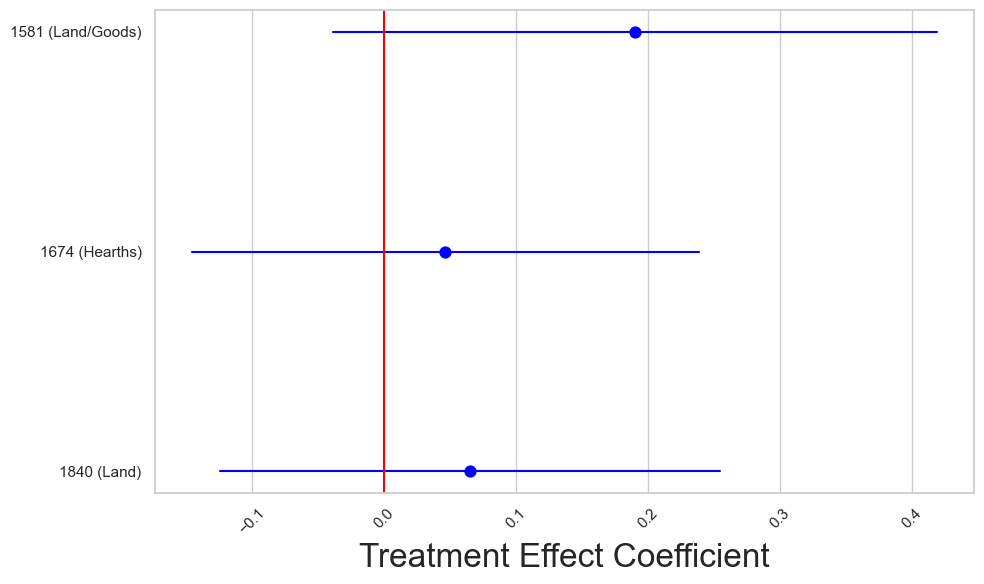

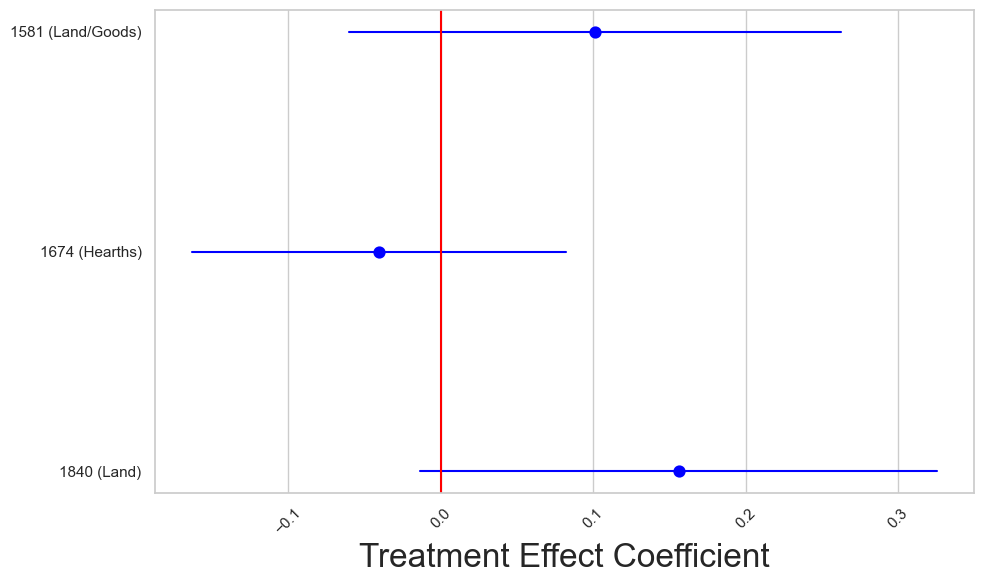

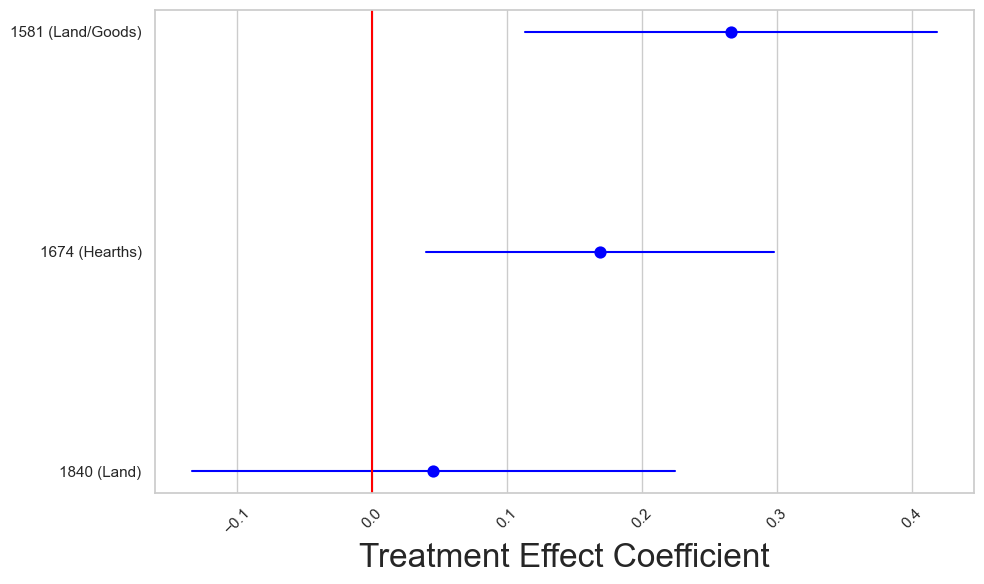

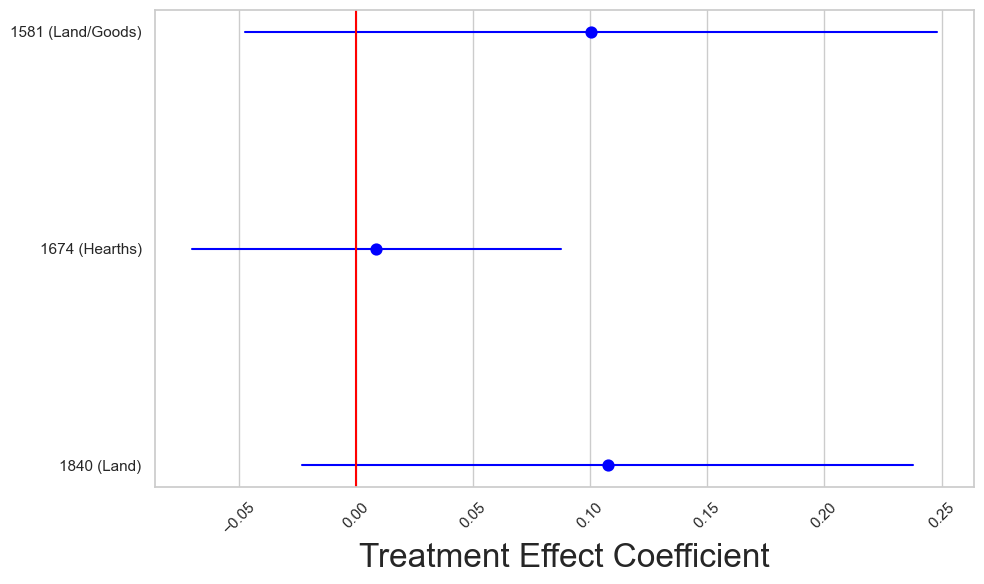

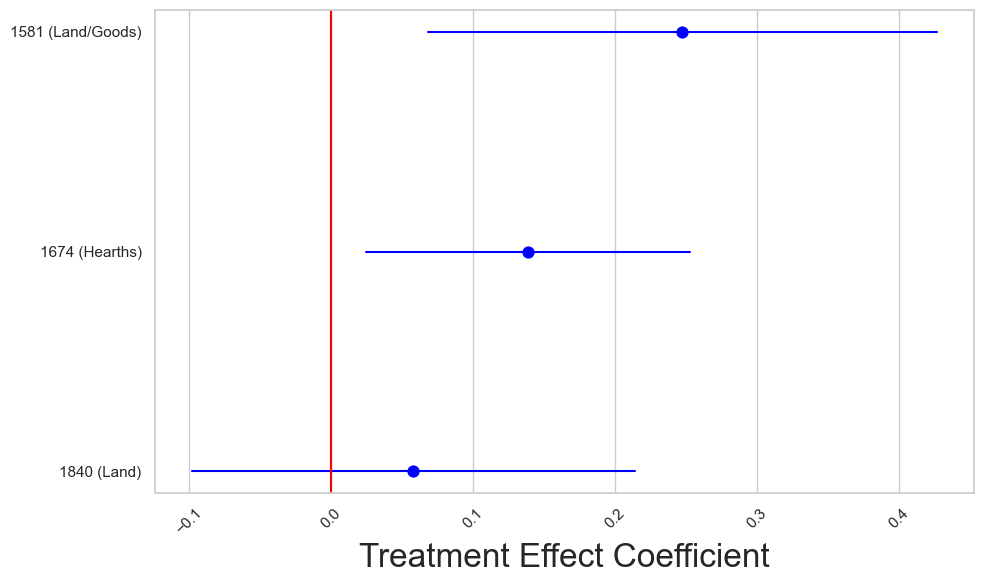

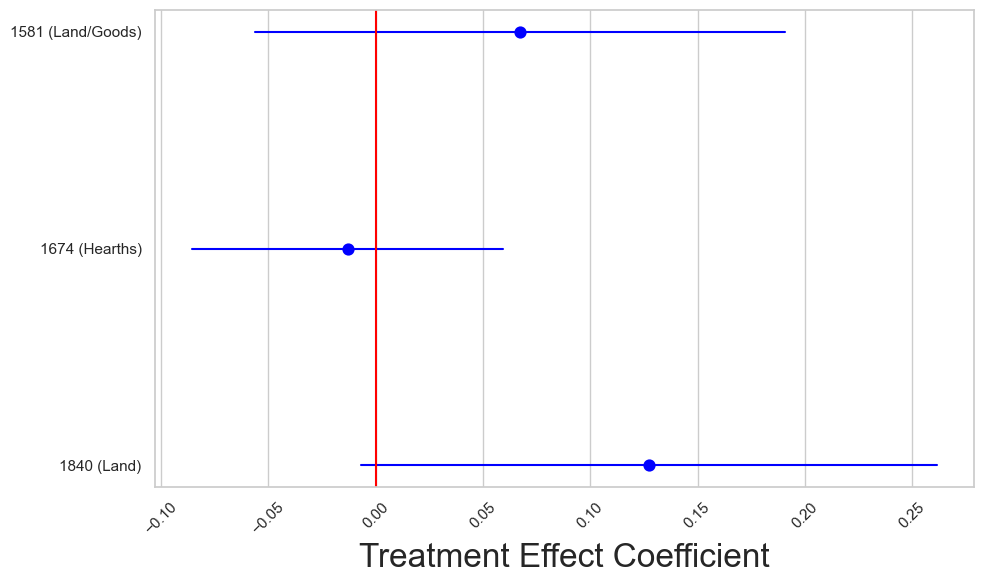

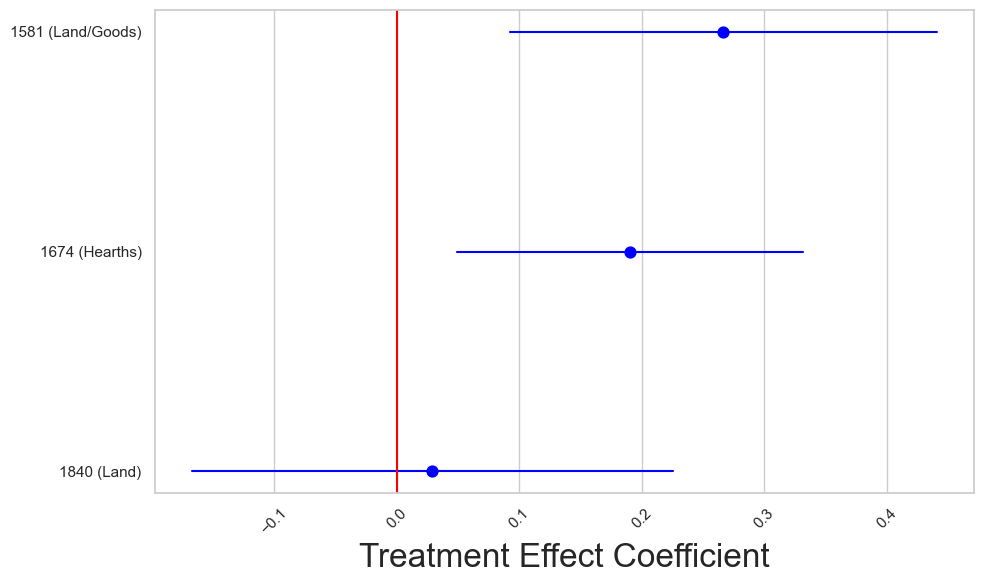

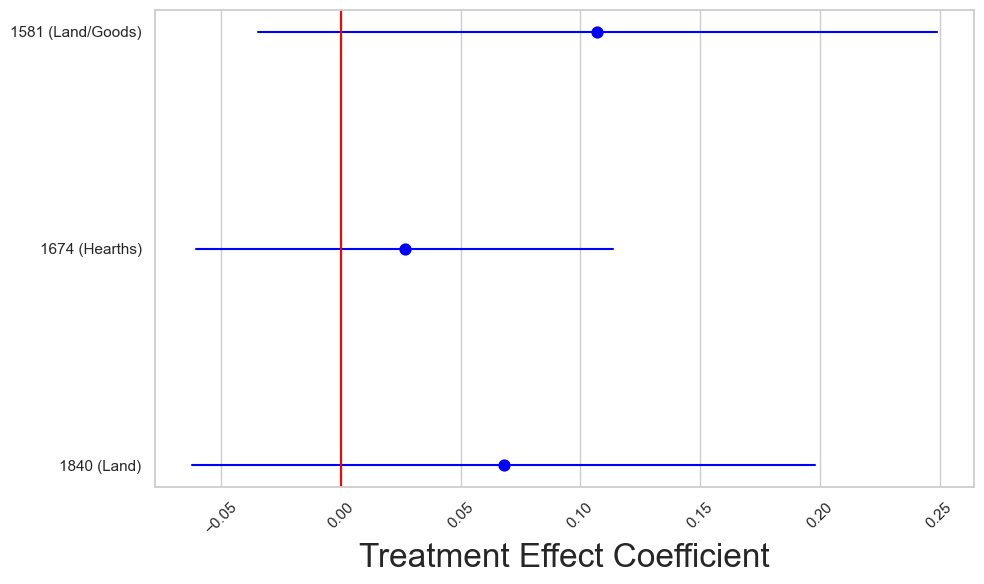

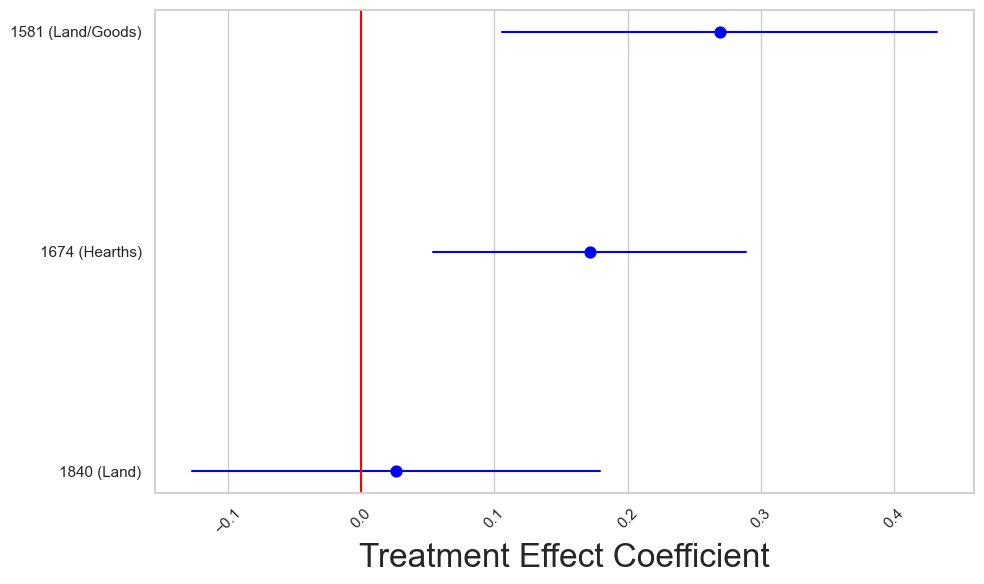

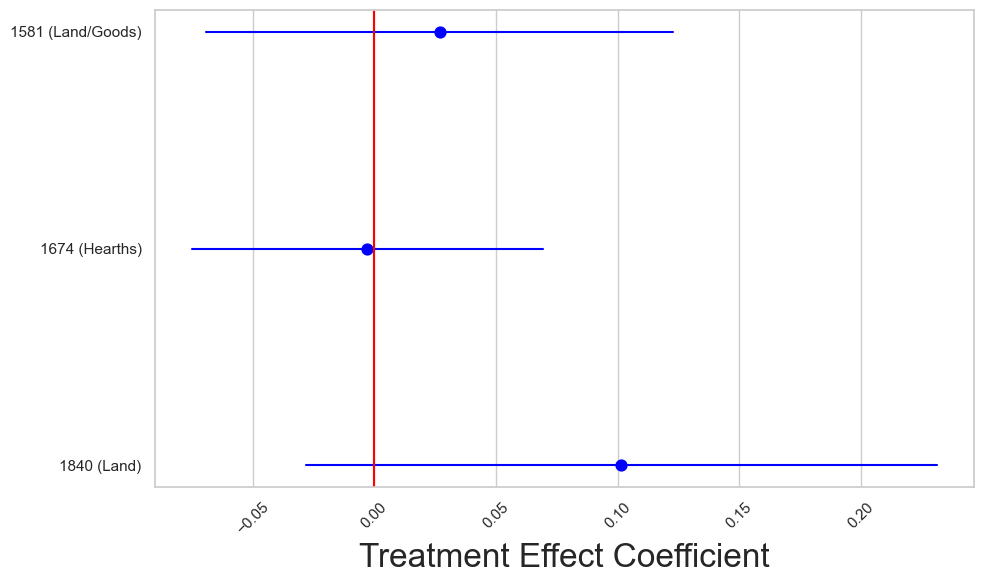

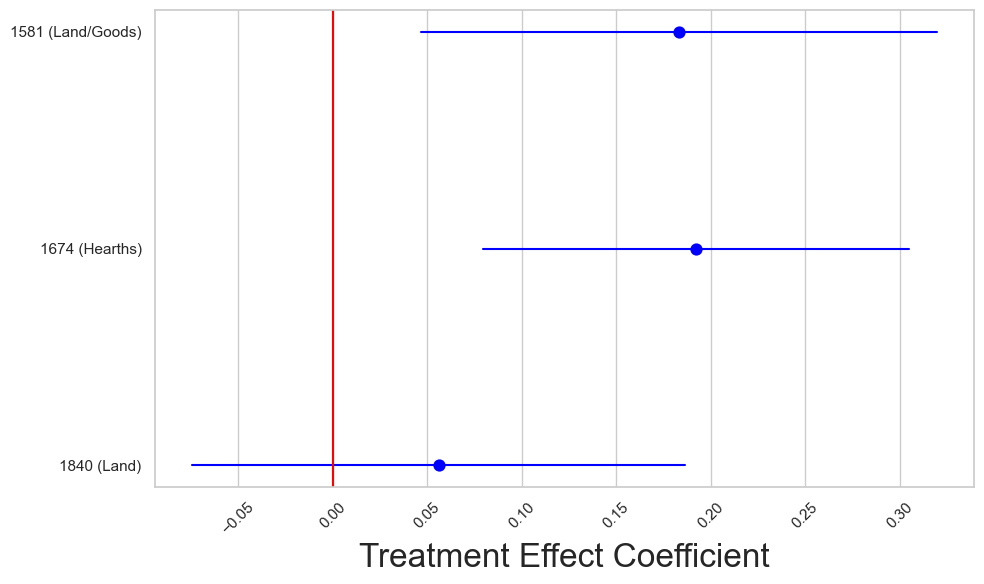

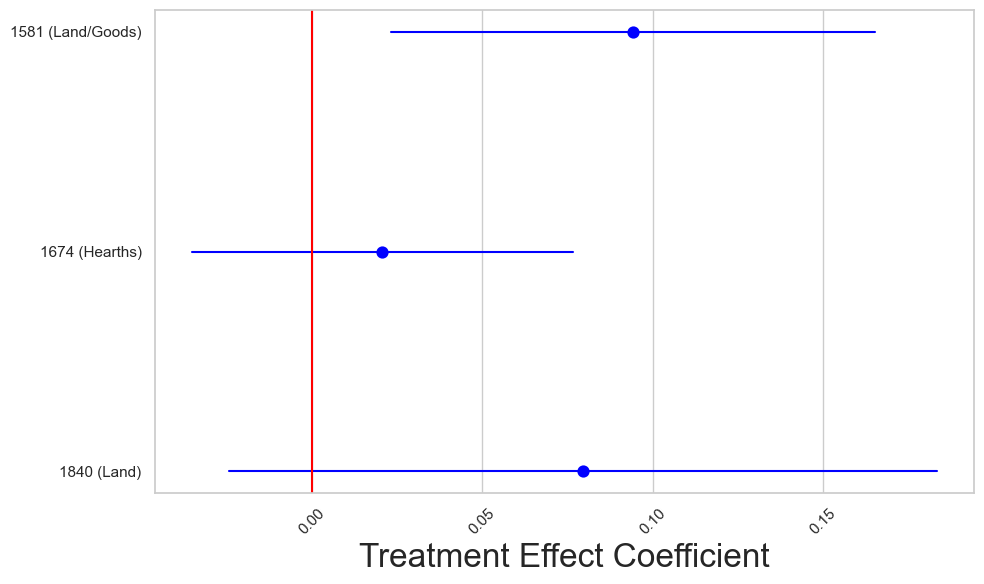

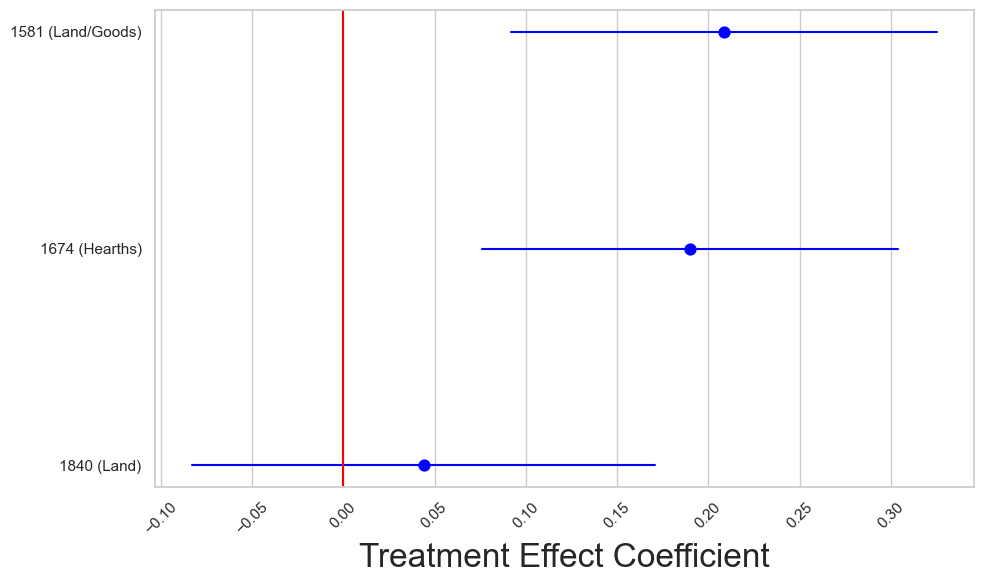

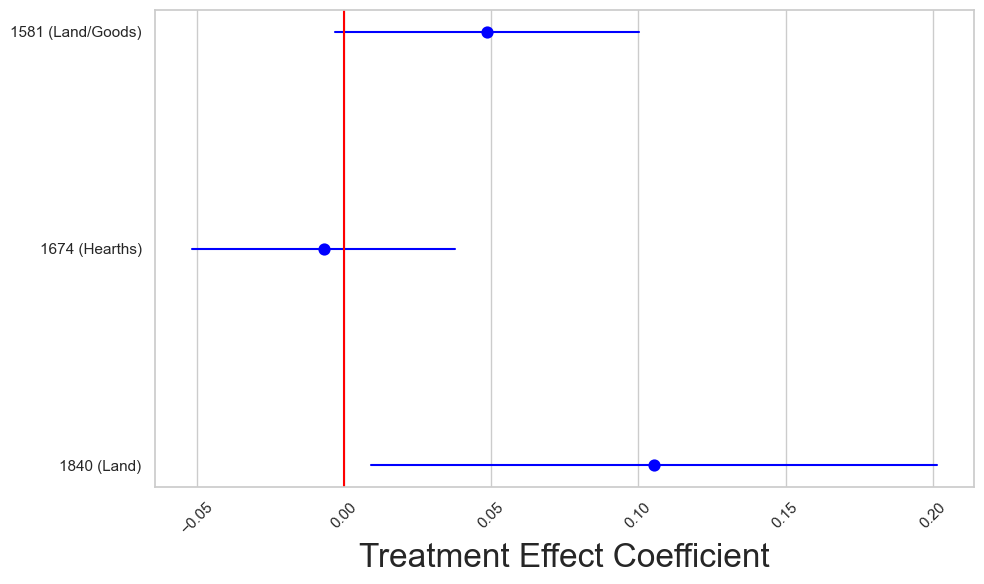

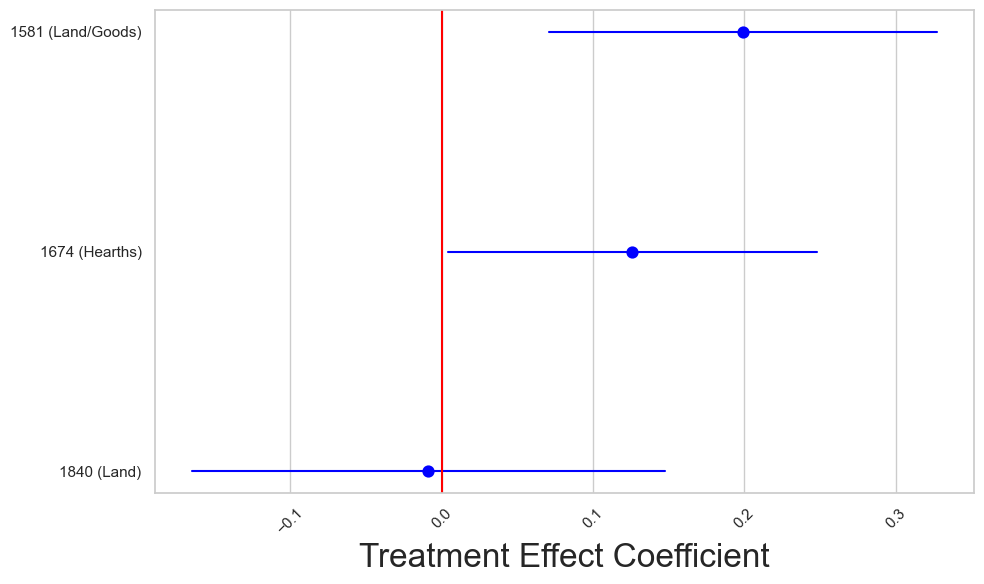

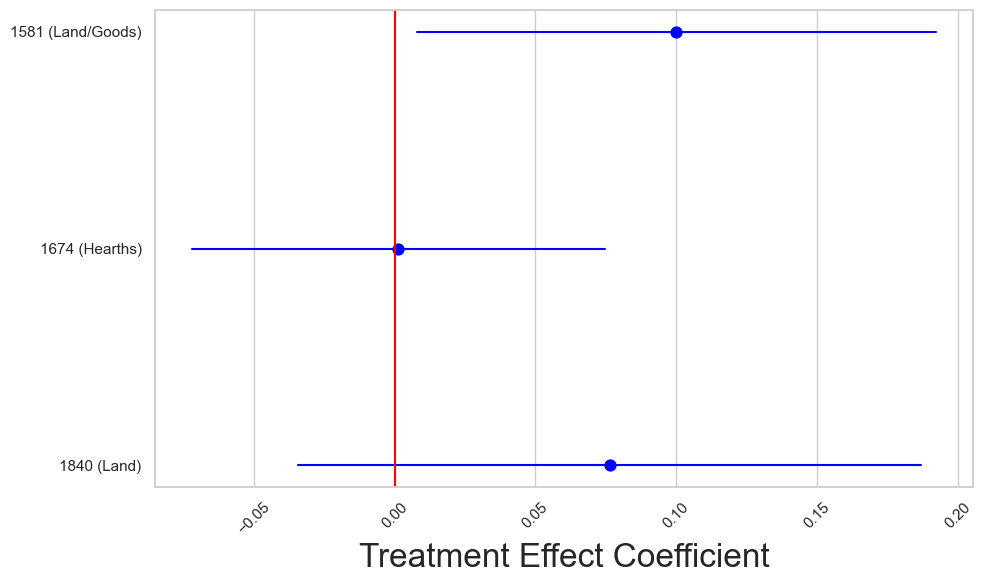

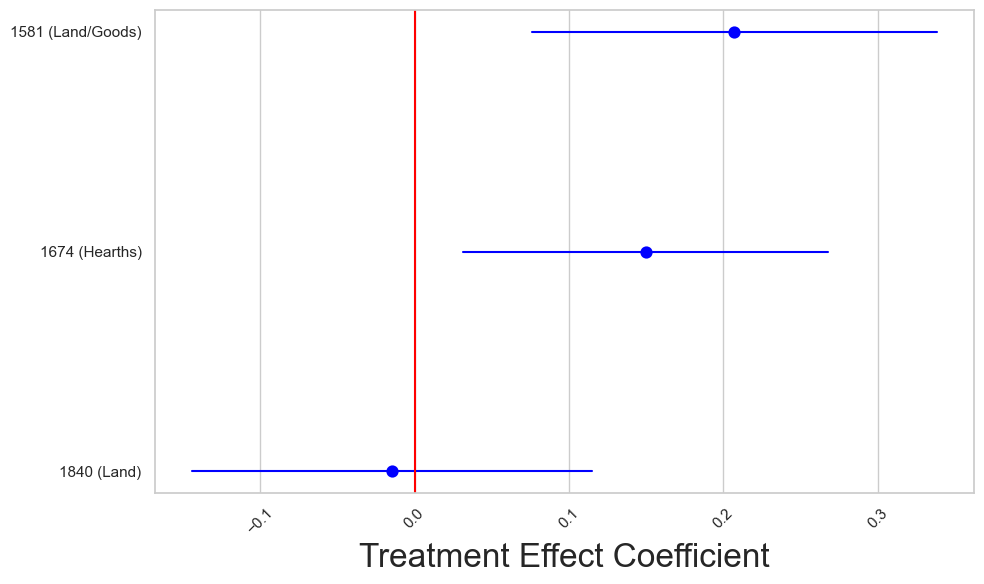

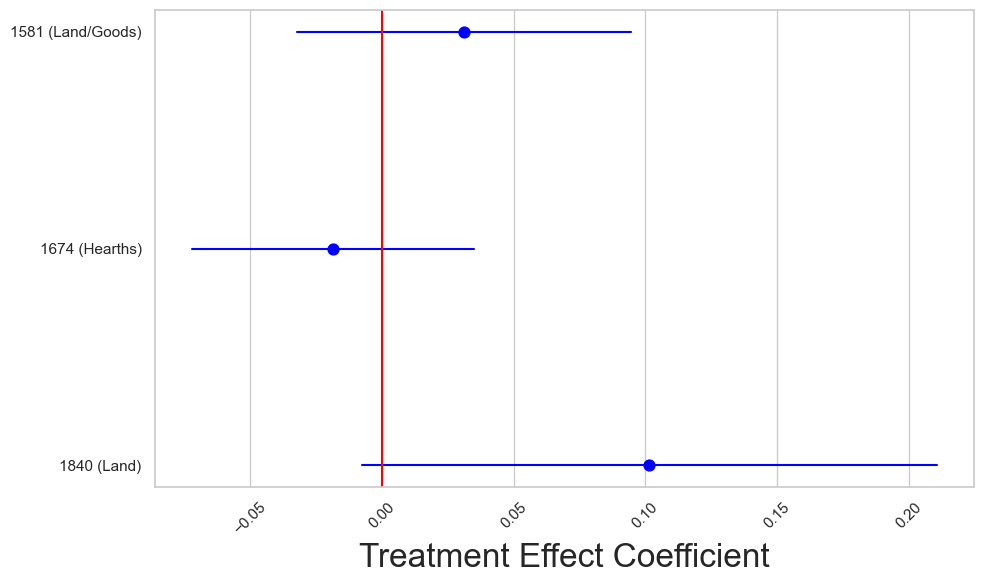

In [15]:
for id_type in [
    'unique',
    'group',
    'combined',
    'metaphone',
    'master'
]:

    df = pd.read_csv(f'{SURNAMES}/{id_type}_id_subsidy_data.csv')

    with open(f'{PROCESSED}/pretty_dict.json', 'r', encoding='utf-8') as f:
        pretty_dict = json.load(f)

    for year in [
        1524, 
        1543,
        1581,
        1674,
        1840
    ]:
        for measure in [
            'avg_val',
            'tot_val',
            'max_val',
            'count',
        ]:
            # fill zeroes with nan
            df[f'{measure}_{year}'] = df[f'{measure}_{year}'].apply(lambda x: np.nan if x == 0 else x)

    years_list = [1524, 1581, 1674, 1840]
    for measure in [
        'avg_val',
        'tot_val',
        'max_val',
        'count'
    ]:

        results_list = []
        plot_df_list = []
        for i, year in enumerate(years_list):
            if year == 1524:
                continue
            last_year = years_list[i - 1]

            sub_df = df.copy()
            sub_df = sub_df.loc[~pd.isna(sub_df['control2_group'])]
            sub_df[f'{measure}_pctile_{year}'] = sub_df[f'{measure}_{year}'].rank(pct=True)
            sub_df[f'{measure}_pctile_{last_year}'] = sub_df[f'{measure}_{last_year}'].rank(pct=True)


            x_vars = [f'{measure}_pctile_{last_year}', 'parish_distriver', 'parish_distmkt', f'ln_parish_avg_value_{last_year}', f'parish_pop_density_{last_year}', 'ln_parish_monastic_land']

            sub_df = sub_df.dropna(subset=[f'{measure}_{year}'] + x_vars + ['treatment', 'control'])

            x = sub_df[['treatment'] + x_vars]
            dummies = pd.get_dummies(sub_df['control2_group'], prefix='Control2', drop_first=True, dtype=int)
            x = pd.concat([x, dummies], axis=1)
            
            x.rename(columns={
                'treatment': 'Treatment',
                'control': 'Control',
                f'avg_val_pctile_{last_year}': f'Previous Avg Value Percentile',
                f'tot_val_pctile_{last_year}': f'Previous Total Value Percentile',
                f'max_val_pctile_{last_year}': f'Previous Max Value Percentile',
                f'count_pctile_{last_year}': f'Previous Count Percentile',
                f'parish_avg_value_{last_year}': 'Previous Parish Avg Value',
                f'parish_pop_density_{last_year}': 'Previous Parish Pop Density',
                'ln_parish_monastic_land': 'ln(Parish Monastic Land)',
                f'ln_parish_avg_value_{last_year}': 'ln(Previous Parish Avg Value)',
                f'parish_pop_density_{last_year}': 'Previous Parish Pop Density',
                'parish_distriver': 'Parish Distance to River',
                'parish_distmkt': 'Parish Distance to Market'
            }, inplace=True)
            y = sub_df[f'{measure}_pctile_{year}']
            x = sm.add_constant(x)
            x_cols = x.columns.tolist()
            for col in x_cols:
                if not col.startswith('Control2_'):
                    continue
                if x[col].sum() < 2:
                    x.drop(columns=[col], inplace=True)

            
            model = sm.OLS(y, x)
            result = model.fit(cov_type='HC3')
            results_list.append(result)
            
            plot_df_list.append({
                'year': year,
                'coef': result.params['Treatment'],
                'se': result.bse['Treatment']
            })
        table = summary_col(results_list, stars=True, model_names=years_list[1:], info_dict={'N': lambda x: "{0:d}".format(int(x.nobs))}).as_latex()
        
        table = table.replace('\\begin{center}', '\\begin{center}\n\\resizebox{\\textwidth}{!}{')
        table = table.replace('\\end{tabular}', '\\end{tabular}\n}')
        table = table.replace('p<', 'p$<$')
        table = re.sub(r'(Control2[^\n]*\n\s*&[^\n]*\n)+', r'Match-Group Dummies & Y & Y & Y \\\\ \n', table)
        print(f'Writing table for {id_type.title()} and {measure}')
        print(table)
        with open(f'{TABLES}/{id_type}_{measure}_matched_results.tex', 'w', encoding='utf-8') as f:
            f.write(table)

        plot_df = pd.DataFrame(plot_df_list)
        plot_df['lower'] = plot_df['coef'] - 1.96 * plot_df['se']
        plot_df['upper'] = plot_df['coef'] + 1.96 * plot_df['se']
        plot_df['year'] = plot_df['year'].astype(str)
        year_replace = {'1581': '1581 (Land/Goods)',
                        '1674': '1674 (Hearths)',
                        '1840': '1840 (Land)'}
        plot_df['year'] = plot_df['year'].replace(year_replace)
        plt.figure(figsize=(10, 6))
        sns.set_theme(style='whitegrid')
        sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
        for i, row in plot_df.iterrows():
            plt.plot([row['lower'], row['upper']], [row['year'], row['year']], color='blue')
        plt.xticks(rotation=45)
        plt.ylabel(None)
        plt.xlabel('Treatment Effect Coefficient', fontsize=24)
        plt.tight_layout()
        plt.axvline(x=0, color='red')
        plt.savefig(f'{IMAGES}/{id_type}_{measure}_treatment_effects.png', dpi=300)

#### Matching Estimator, Keep Zeroes

Writing table for Unique and avg_val
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581      & 1674      & 1840      \\
\hline
const                         & -0.4188   & 0.2860    & 0.5707    \\
                              & (0.8942)  & (0.5317)  & (0.7254)  \\
Treatment                     & 0.0751    & 0.0875    & 0.0827    \\
                              & (0.0577)  & (0.0619)  & (0.0667)  \\
Previous Avg Value Percentile & 0.8653**  & -0.0273   & -0.0196   \\
                              & (0.4313)  & (0.1304)  & (0.1249)  \\
ln(Parish Monastic Land)      & -0.0360   & -0.0287   & -0.0107   \\
                              & (0.0271)  & (0.0416)  & (0.0404)  \\
ln(Previous Parish Avg Value) & 0.4253    & 0.3058    & -0.0251   \\
                              & (0.4302)  & (0.2796)  & (0.5938)  \\
Previous Parish Pop Density   & -0.0002   & -0.0002   & -0.0000   \\
                       

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2726823028.py:115: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2726823028.py:115: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Unique and tot_val
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                                & 1581     & 1674       & 1840       \\
\hline
const                           & 0.3462   & 1.0028**   & -0.3008    \\
                                & (0.8001) & (0.4033)   & (0.6539)   \\
Treatment                       & 0.0457   & 0.0381     & 0.1148*    \\
                                & (0.0519) & (0.0397)   & (0.0662)   \\
Previous Total Value Percentile & 0.8164** & 0.0396     & 0.4567***  \\
                                & (0.4112) & (0.0931)   & (0.1566)   \\
ln(Parish Monastic Land)        & -0.0073  & -0.0473    & 0.0033     \\
                                & (0.0290) & (0.0364)   & (0.0382)   \\
ln(Previous Parish Avg Value)   & -0.0455  & 0.1818     & 0.2802     \\
                                & (0.3872) & (0.1907)   & (0.4927)   \\
Previous Parish Pop Density     & -0.0002  & -0.0000    & -

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2726823028.py:115: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2726823028.py:115: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Unique and max_val
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581       & 1674      & 1840      \\
\hline
const                         & 0.3966     & 0.5643    & 0.3205    \\
                              & (0.8347)   & (0.5471)  & (0.7320)  \\
Treatment                     & 0.0816     & 0.1221**  & 0.1051    \\
                              & (0.0546)   & (0.0583)  & (0.0720)  \\
Previous Max Value Percentile & 0.6315     & -0.0177   & 0.1647    \\
                              & (0.4187)   & (0.1250)  & (0.1311)  \\
ln(Parish Monastic Land)      & -0.0114    & -0.0133   & -0.0105   \\
                              & (0.0249)   & (0.0415)  & (0.0417)  \\
ln(Previous Parish Avg Value) & -0.0080    & 0.1859    & 0.1130    \\
                              & (0.3942)   & (0.2528)  & (0.5515)  \\
Previous Parish Pop Density   & -0.0002    & 0.0001    & -0.0000   \\
           

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2726823028.py:115: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2726823028.py:115: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Unique and count
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581     & 1674       & 1840       \\
\hline
const                         & 0.7199   & 0.9882***  & -0.5943    \\
                              & (0.9719) & (0.3379)   & (0.6231)   \\
Treatment                     & 0.0223   & -0.0099    & 0.1350**   \\
                              & (0.0430) & (0.0341)   & (0.0649)   \\
Previous Count Percentile     & 0.5220   & 0.0928     & 0.5950***  \\
                              & (0.5418) & (0.0839)   & (0.1550)   \\
ln(Parish Monastic Land)      & 0.0017   & -0.0455    & 0.0040     \\
                              & (0.0341) & (0.0336)   & (0.0384)   \\
ln(Previous Parish Avg Value) & -0.1026  & 0.1439     & 0.4139     \\
                              & (0.4010) & (0.1658)   & (0.4693)   \\
Previous Parish Pop Density   & -0.0002  & 0.0001     & -0.0001    \\
             

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2726823028.py:115: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2726823028.py:115: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Group and avg_val
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581       & 1674      & 1840        \\
\hline
const                         & 0.2671     & 0.4280    & -0.3846     \\
                              & (0.7865)   & (0.5247)  & (0.7899)    \\
Treatment                     & 0.1406**   & 0.1851*** & 0.1084*     \\
                              & (0.0558)   & (0.0617)  & (0.0561)    \\
Previous Avg Value Percentile & -0.0848    & 0.0010    & -0.0604     \\
                              & (0.3114)   & (0.1324)  & (0.1068)    \\
ln(Parish Monastic Land)      & 0.0272     & -0.0080   & 0.0175      \\
                              & (0.0391)   & (0.0472)  & (0.0589)    \\
ln(Previous Parish Avg Value) & 0.0999     & 0.1464    & 0.7337      \\
                              & (0.3350)   & (0.2594)  & (0.5777)    \\
Previous Parish Pop Density   & -0.0001    & -0.0000   & 0.0

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2726823028.py:115: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2726823028.py:115: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Group and tot_val
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                                & 1581       & 1674       & 1840        \\
\hline
const                           & 0.6705     & 0.1622     & 0.0601      \\
                                & (0.7867)   & (0.3636)   & (0.6233)    \\
Treatment                       & 0.0810**   & 0.0610*    & 0.0927**    \\
                                & (0.0410)   & (0.0341)   & (0.0455)    \\
Previous Total Value Percentile & 0.3798     & 0.3835***  & 0.5389***   \\
                                & (0.3263)   & (0.1136)   & (0.1104)    \\
ln(Parish Monastic Land)        & -0.0009    & -0.0057    & -0.0086     \\
                                & (0.0309)   & (0.0324)   & (0.0440)    \\
ln(Previous Parish Avg Value)   & -0.0771    & 0.1898     & 0.2669      \\
                                & (0.3202)   & (0.1310)   & (0.4121)    \\
Previous Parish Pop Density

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2726823028.py:115: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2726823028.py:115: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Group and max_val
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581       & 1674       & 1840        \\
\hline
const                         & 1.0775     & 0.1489     & -0.2069     \\
                              & (0.7122)   & (0.4562)   & (0.6655)    \\
Treatment                     & 0.1345***  & 0.1774***  & 0.0886      \\
                              & (0.0460)   & (0.0523)   & (0.0580)    \\
Previous Max Value Percentile & -0.0378    & 0.1661     & 0.1861      \\
                              & (0.2929)   & (0.1188)   & (0.1152)    \\
ln(Parish Monastic Land)      & -0.0041    & -0.0030    & 0.0112      \\
                              & (0.0350)   & (0.0388)   & (0.0492)    \\
ln(Previous Parish Avg Value) & -0.1113    & 0.2359     & 0.5837      \\
                              & (0.3216)   & (0.1908)   & (0.5133)    \\
Previous Parish Pop Density   & -0.0001    & 0.00

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2726823028.py:115: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2726823028.py:115: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Group and count
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581     & 1674      & 1840        \\
\hline
const                         & 0.0944   & 0.0003    & -0.1196     \\
                              & (0.6714) & (0.3675)  & (0.5084)    \\
Treatment                     & 0.0589   & 0.0103    & 0.1065**    \\
                              & (0.0371) & (0.0240)  & (0.0421)    \\
Previous Count Percentile     & 0.7108*  & 0.4191*** & 0.6765***   \\
                              & (0.3971) & (0.1034)  & (0.0910)    \\
ln(Parish Monastic Land)      & 0.0100   & -0.0004   & -0.0163     \\
                              & (0.0268) & (0.0334)  & (0.0406)    \\
ln(Previous Parish Avg Value) & 0.0208   & 0.2389*   & 0.3963      \\
                              & (0.3127) & (0.1357)  & (0.3333)    \\
Previous Parish Pop Density   & -0.0000  & 0.0004**  & -0.0000     \\
              

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2726823028.py:115: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2726823028.py:115: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Combined and avg_val
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581       & 1674      & 1840        \\
\hline
const                         & 0.1805     & 0.6687    & -0.3239     \\
                              & (0.9109)   & (0.5504)  & (0.7832)    \\
Treatment                     & 0.1292**   & 0.1871*** & 0.1144*     \\
                              & (0.0556)   & (0.0591)  & (0.0604)    \\
Previous Avg Value Percentile & -0.1953    & -0.0032   & -0.0637     \\
                              & (0.2239)   & (0.1398)  & (0.1071)    \\
ln(Parish Monastic Land)      & 0.0249     & -0.0212   & 0.0476      \\
                              & (0.0367)   & (0.0437)  & (0.0621)    \\
ln(Previous Parish Avg Value) & 0.2004     & 0.0261    & 0.6285      \\
                              & (0.4360)   & (0.3235)  & (0.5935)    \\
Previous Parish Pop Density   & -0.0002    & 0.0003    & 

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2726823028.py:115: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2726823028.py:115: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Combined and tot_val
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                                & 1581       & 1674       & 1840        \\
\hline
const                           & 0.7107     & 0.1749     & -0.2688     \\
                                & (0.7701)   & (0.3940)   & (0.6681)    \\
Treatment                       & 0.0633     & 0.0622*    & 0.0939**    \\
                                & (0.0445)   & (0.0322)   & (0.0473)    \\
Previous Total Value Percentile & 0.2438     & 0.4149***  & 0.4714***   \\
                                & (0.3010)   & (0.1089)   & (0.1304)    \\
ln(Parish Monastic Land)        & 0.0105     & 0.0014     & 0.0088      \\
                                & (0.0284)   & (0.0312)   & (0.0490)    \\
ln(Previous Parish Avg Value)   & -0.0504    & 0.1917     & 0.5705      \\
                                & (0.3374)   & (0.1562)   & (0.4780)    \\
Previous Parish Pop Dens

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2726823028.py:115: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2726823028.py:115: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Combined and max_val
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581       & 1674       & 1840        \\
\hline
const                         & 0.9799     & 0.2819     & -0.3711     \\
                              & (0.8059)   & (0.4504)   & (0.7137)    \\
Treatment                     & 0.1161**   & 0.1914***  & 0.0844      \\
                              & (0.0483)   & (0.0484)   & (0.0611)    \\
Previous Max Value Percentile & -0.1514    & 0.1181     & 0.1591      \\
                              & (0.2790)   & (0.1164)   & (0.1120)    \\
ln(Parish Monastic Land)      & -0.0007    & -0.0005    & 0.0201      \\
                              & (0.0367)   & (0.0368)   & (0.0510)    \\
ln(Previous Parish Avg Value) & -0.0284    & 0.2158     & 0.7930      \\
                              & (0.4125)   & (0.2126)   & (0.5284)    \\
Previous Parish Pop Density   & -0.0002    & 0

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2726823028.py:115: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2726823028.py:115: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Combined and count
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581     & 1674       & 1840        \\
\hline
const                         & -0.2389  & -0.0226    & -0.2597     \\
                              & (0.7138) & (0.3797)   & (0.5917)    \\
Treatment                     & 0.0318   & 0.0097     & 0.1117**    \\
                              & (0.0378) & (0.0228)   & (0.0438)    \\
Previous Count Percentile     & 0.8828** & 0.4911***  & 0.6492***   \\
                              & (0.3843) & (0.0954)   & (0.1258)    \\
ln(Parish Monastic Land)      & 0.0266   & 0.0082     & -0.0074     \\
                              & (0.0244) & (0.0306)   & (0.0469)    \\
ln(Previous Parish Avg Value) & 0.0705   & 0.2465*    & 0.5266      \\
                              & (0.3087) & (0.1373)   & (0.4062)    \\
Previous Parish Pop Density   & -0.0001  & 0.0005***  & -0.0000     \\

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2726823028.py:115: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2726823028.py:115: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Metaphone and avg_val
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581       & 1674      & 1840       \\
\hline
const                         & 0.4714     & 1.5751*   & -0.1851    \\
                              & (1.1699)   & (0.8550)  & (0.7920)   \\
Treatment                     & 0.1846***  & 0.1988*** & 0.0904*    \\
                              & (0.0554)   & (0.0547)  & (0.0526)   \\
Previous Avg Value Percentile & 0.0615     & -0.0177   & -0.0528    \\
                              & (0.2014)   & (0.1161)  & (0.0834)   \\
ln(Parish Monastic Land)      & -0.0187    & -0.0551   & 0.0641     \\
                              & (0.0639)   & (0.0701)  & (0.0602)   \\
ln(Previous Parish Avg Value) & 0.1007     & -0.3920   & 0.1513     \\
                              & (0.6184)   & (0.3950)  & (0.5302)   \\
Previous Parish Pop Density   & -0.0005*** & 0.0001    & -0.0000   

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2726823028.py:115: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2726823028.py:115: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Metaphone and tot_val
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                                & 1581      & 1674      & 1840       \\
\hline
const                           & -0.3472   & -0.0387   & 0.4451     \\
                                & (0.5729)  & (0.4326)  & (0.4513)   \\
Treatment                       & 0.0871*** & 0.0260    & 0.0867**   \\
                                & (0.0292)  & (0.0261)  & (0.0431)   \\
Previous Total Value Percentile & 0.9853*** & 0.5450*** & 0.6529***  \\
                                & (0.2740)  & (0.0882)  & (0.1155)   \\
ln(Parish Monastic Land)        & -0.0358   & 0.0203    & -0.0317    \\
                                & (0.0389)  & (0.0372)  & (0.0483)   \\
ln(Previous Parish Avg Value)   & 0.3453    & 0.0202    & -0.0660    \\
                                & (0.2646)  & (0.1586)  & (0.2802)   \\
Previous Parish Pop Density     & -0.0001*  & 0.0003    

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2726823028.py:115: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2726823028.py:115: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Metaphone and max_val
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581      & 1674      & 1840       \\
\hline
const                         & 0.4748    & 0.5637    & 0.6030     \\
                              & (0.9429)  & (0.6582)  & (0.5790)   \\
Treatment                     & 0.1909*** & 0.1841*** & 0.0756     \\
                              & (0.0488)  & (0.0526)  & (0.0511)   \\
Previous Max Value Percentile & 0.3416    & 0.2405**  & 0.2052**   \\
                              & (0.2579)  & (0.1044)  & (0.0931)   \\
ln(Parish Monastic Land)      & -0.0401   & -0.0307   & -0.0050    \\
                              & (0.0585)  & (0.0607)  & (0.0474)   \\
ln(Previous Parish Avg Value) & 0.0935    & -0.0758   & -0.1194    \\
                              & (0.4914)  & (0.2813)  & (0.3406)   \\
Previous Parish Pop Density   & -0.0003** & 0.0006*   & -0.0000    \\
        

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2726823028.py:115: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2726823028.py:115: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Metaphone and count
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581      & 1674      & 1840       \\
\hline
const                         & -0.3743   & -0.4042   & 0.2718     \\
                              & (0.4402)  & (0.3944)  & (0.4361)   \\
Treatment                     & 0.0532**  & -0.0021   & 0.1081***  \\
                              & (0.0234)  & (0.0213)  & (0.0406)   \\
Previous Count Percentile     & 0.8553*** & 0.6397*** & 0.6381***  \\
                              & (0.1997)  & (0.1063)  & (0.1175)   \\
ln(Parish Monastic Land)      & -0.0238   & 0.0233    & -0.0507    \\
                              & (0.0270)  & (0.0310)  & (0.0490)   \\
ln(Previous Parish Avg Value) & 0.3487*   & 0.1967    & 0.2052     \\
                              & (0.2080)  & (0.1436)  & (0.2815)   \\
Previous Parish Pop Density   & -0.0001   & 0.0002    & -0.0000    \\
          

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2726823028.py:115: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2726823028.py:115: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Master and avg_val
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581      & 1674     & 1840        \\
\hline
const                         & 1.1393    & 0.0865   & -0.7115     \\
                              & (0.9048)  & (0.7565) & (0.6685)    \\
Treatment                     & 0.1621*** & 0.0972*  & 0.0904*     \\
                              & (0.0599)  & (0.0582) & (0.0547)    \\
Previous Avg Value Percentile & 0.2223    & 0.2505** & 0.0183      \\
                              & (0.1995)  & (0.1063) & (0.0985)    \\
ln(Parish Monastic Land)      & -0.0803   & -0.0203  & 0.0475      \\
                              & (0.0613)  & (0.0671) & (0.0557)    \\
ln(Previous Parish Avg Value) & -0.0270   & 0.1989   & 0.7303*     \\
                              & (0.4506)  & (0.2990) & (0.4247)    \\
Previous Parish Pop Density   & -0.0001   & 0.0001   & -0.0000     \\
           

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2726823028.py:115: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2726823028.py:115: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Master and tot_val
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                                & 1581       & 1674       & 1840       \\
\hline
const                           & 0.9061     & 0.2689     & -0.2614    \\
                                & (0.6145)   & (0.3770)   & (0.5234)   \\
Treatment                       & 0.0877**   & 0.0268     & 0.1043**   \\
                                & (0.0368)   & (0.0284)   & (0.0465)   \\
Previous Total Value Percentile & 0.0603     & 0.4822***  & 0.6574***  \\
                                & (0.2840)   & (0.0891)   & (0.1328)   \\
ln(Parish Monastic Land)        & 0.0145     & -0.0048    & 0.0042     \\
                                & (0.0316)   & (0.0379)   & (0.0468)   \\
ln(Previous Parish Avg Value)   & -0.0980    & 0.0767     & 0.2770     \\
                                & (0.3101)   & (0.1191)   & (0.3472)   \\
Previous Parish Pop Density     & -0.

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2726823028.py:115: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2726823028.py:115: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Master and max_val
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581      & 1674       & 1840       \\
\hline
const                         & 1.0961    & 0.1122     & -0.3716    \\
                              & (0.8312)  & (0.5144)   & (0.5868)   \\
Treatment                     & 0.1645*** & 0.1466***  & 0.0680     \\
                              & (0.0532)  & (0.0482)   & (0.0584)   \\
Previous Max Value Percentile & 0.0727    & 0.3415***  & 0.2662**   \\
                              & (0.2872)  & (0.0953)   & (0.1062)   \\
ln(Parish Monastic Land)      & -0.0461   & 0.0054     & 0.0270     \\
                              & (0.0443)  & (0.0471)   & (0.0435)   \\
ln(Previous Parish Avg Value) & -0.0069   & 0.1542     & 0.4512     \\
                              & (0.3737)  & (0.1910)   & (0.4118)   \\
Previous Parish Pop Density   & -0.0001   & 0.0002     & -0.0000    \\

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2726823028.py:115: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2726823028.py:115: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Master and count
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581       & 1674       & 1840       \\
\hline
const                         & 0.7773     & 0.0693     & -0.3101    \\
                              & (0.6690)   & (0.3478)   & (0.5656)   \\
Treatment                     & 0.0388     & 0.0035     & 0.1222***  \\
                              & (0.0294)   & (0.0239)   & (0.0447)   \\
Previous Count Percentile     & -0.0114    & 0.5356***  & 0.7436***  \\
                              & (0.3680)   & (0.0955)   & (0.1452)   \\
ln(Parish Monastic Land)      & 0.0257     & 0.0104     & -0.0057    \\
                              & (0.0263)   & (0.0322)   & (0.0535)   \\
ln(Previous Parish Avg Value) & -0.0342    & 0.1081     & 0.3413     \\
                              & (0.2881)   & (0.1080)   & (0.3116)   \\
Previous Parish Pop Density   & 0.0000     & 0.0001     & -0.

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2726823028.py:115: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2726823028.py:115: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


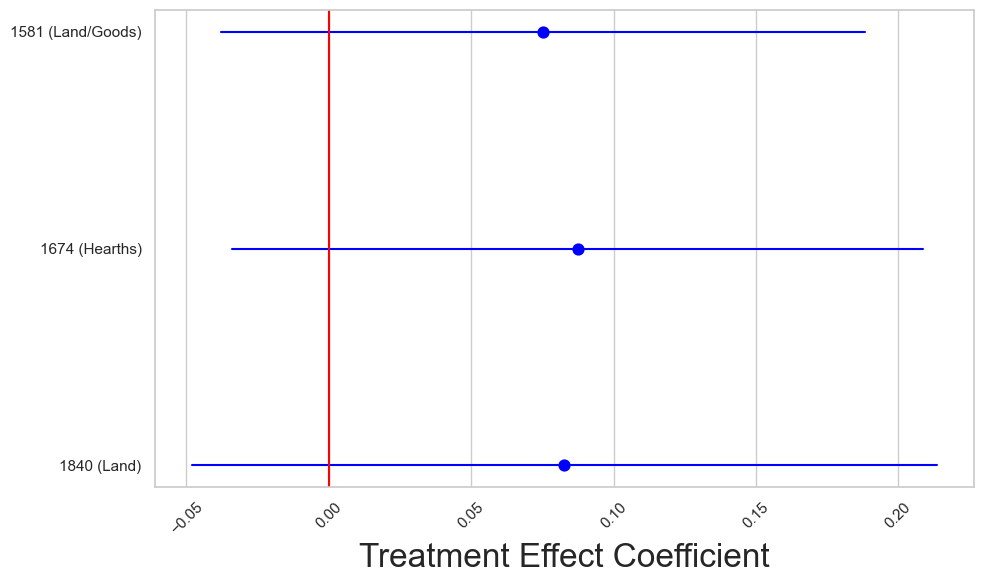

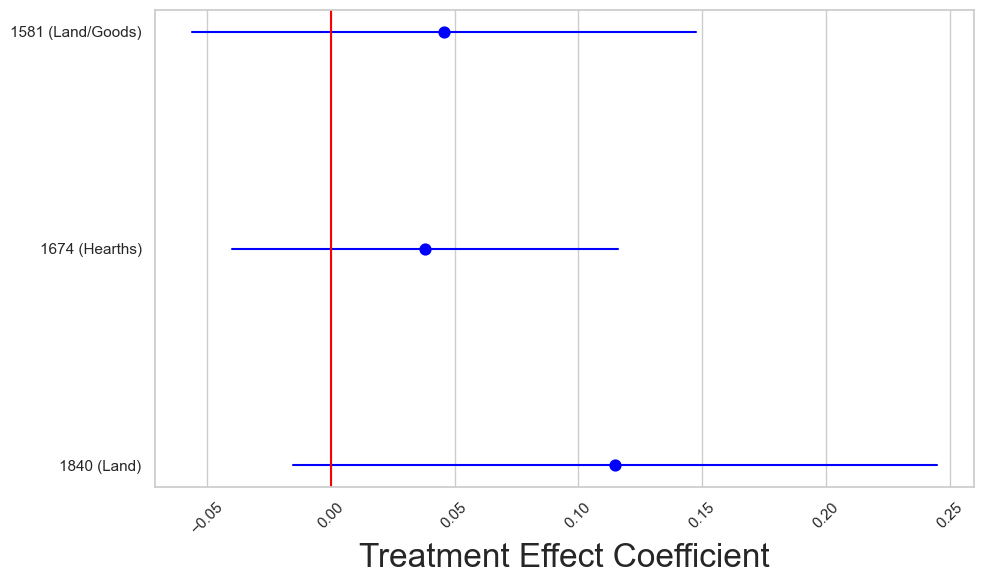

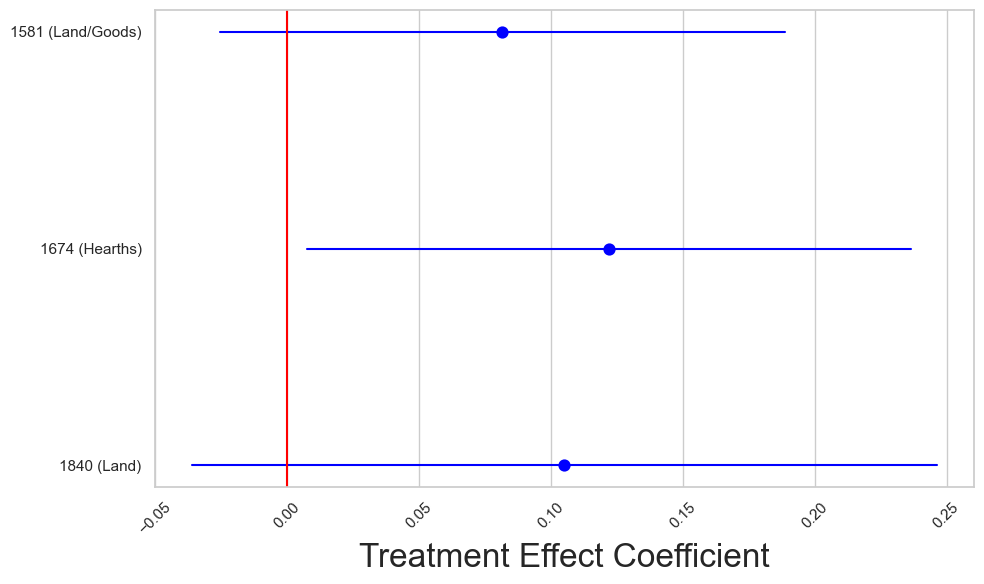

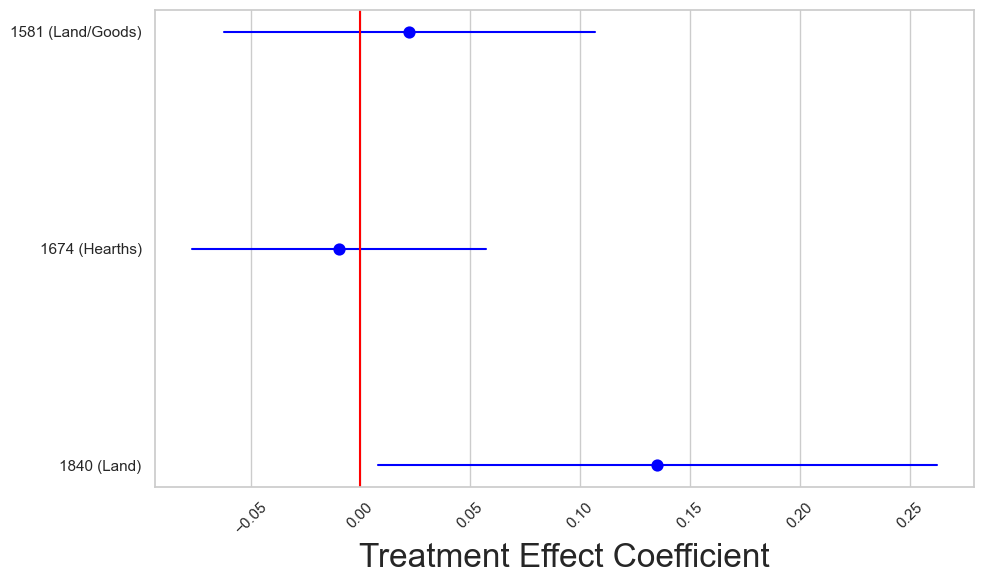

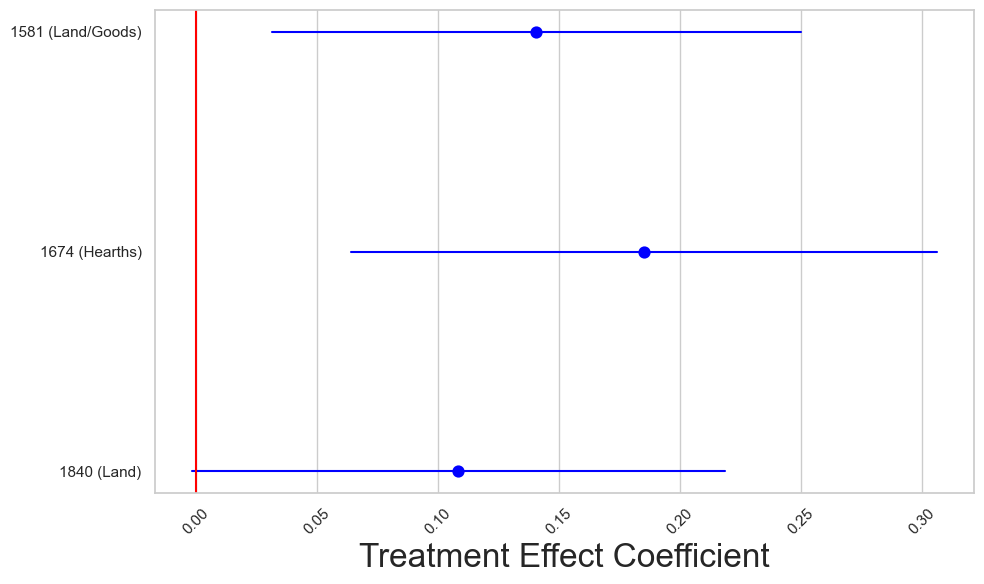

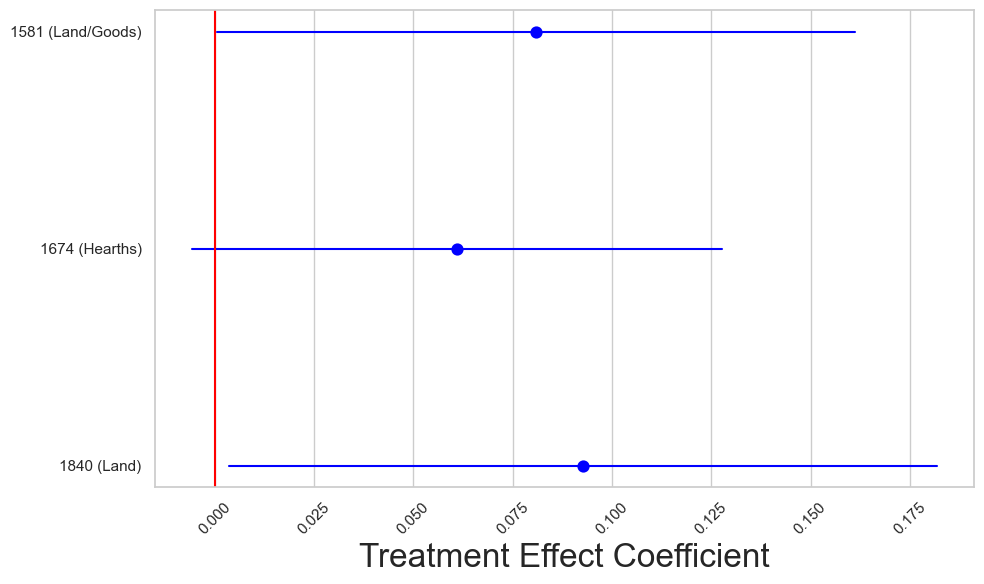

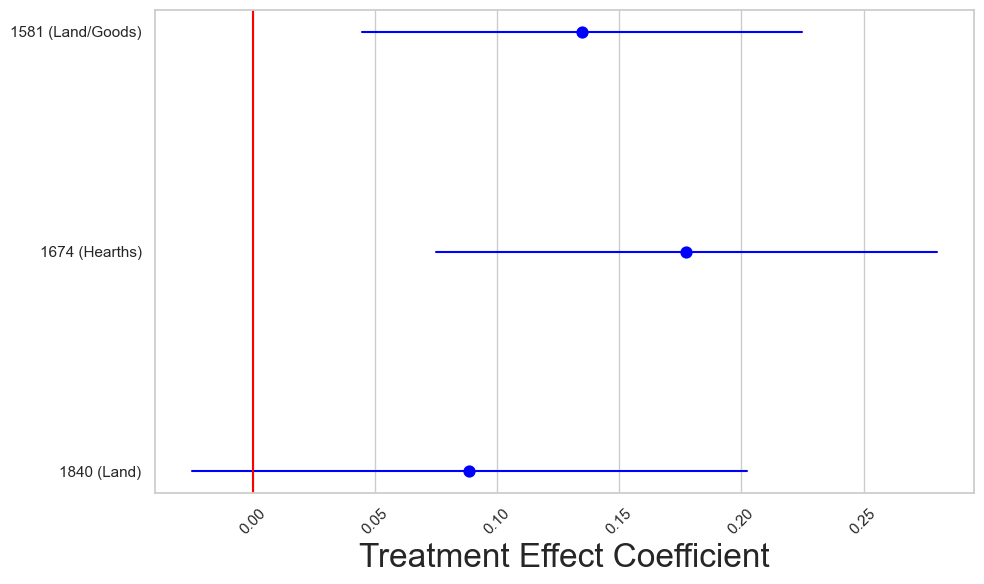

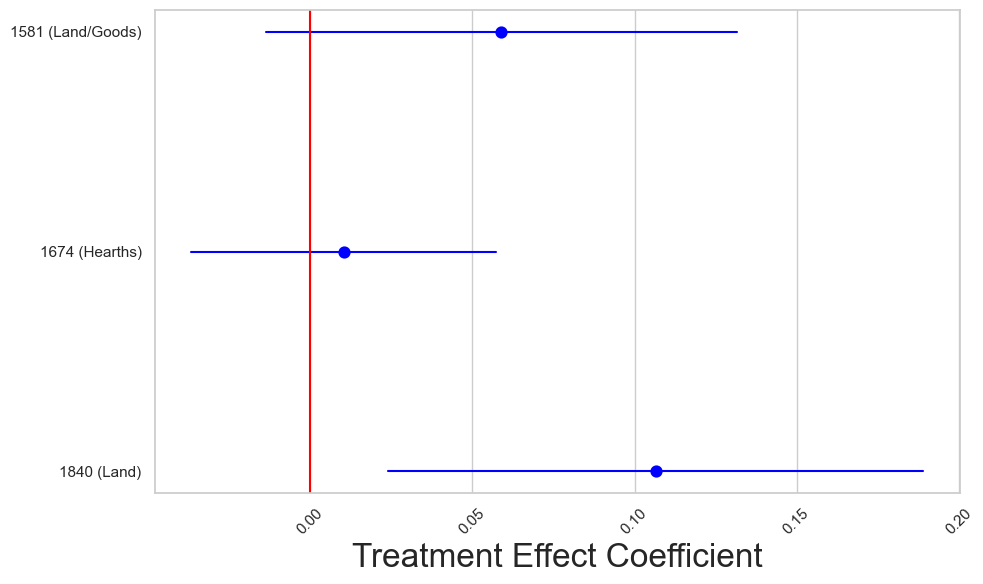

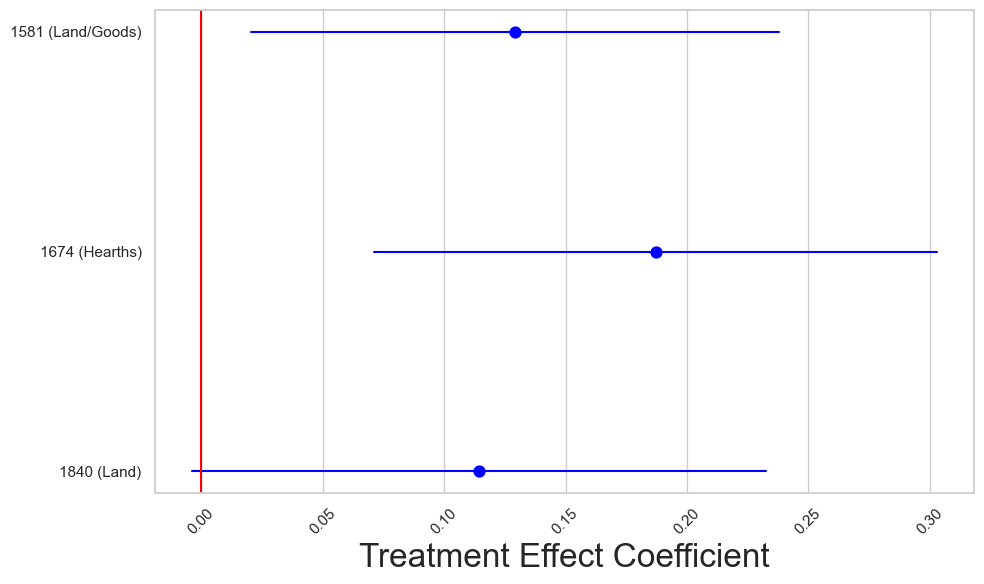

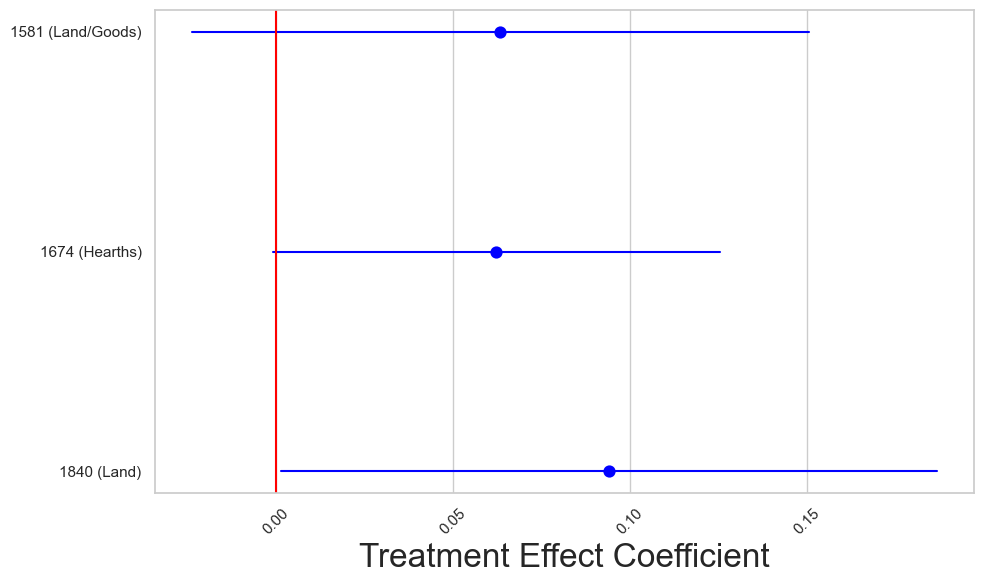

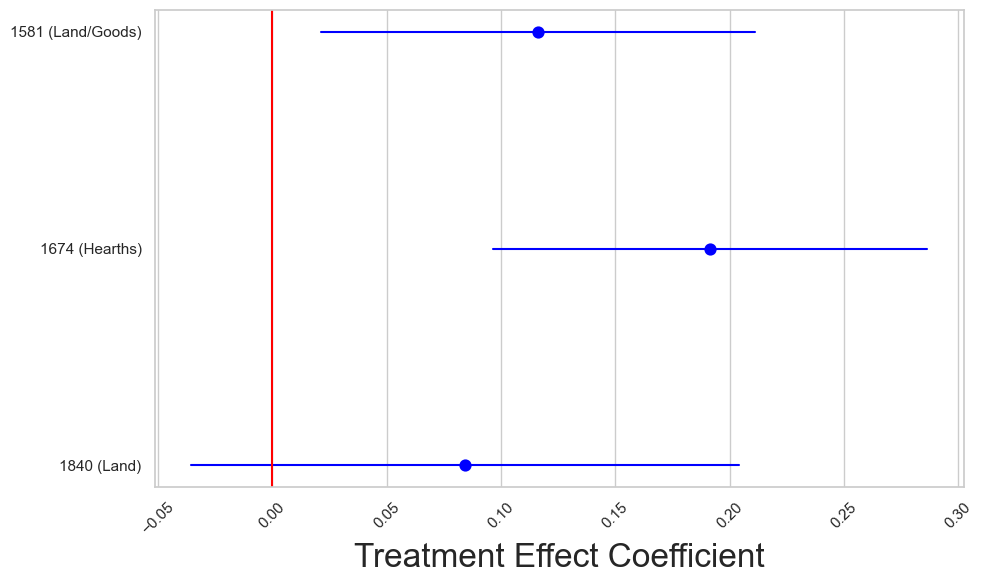

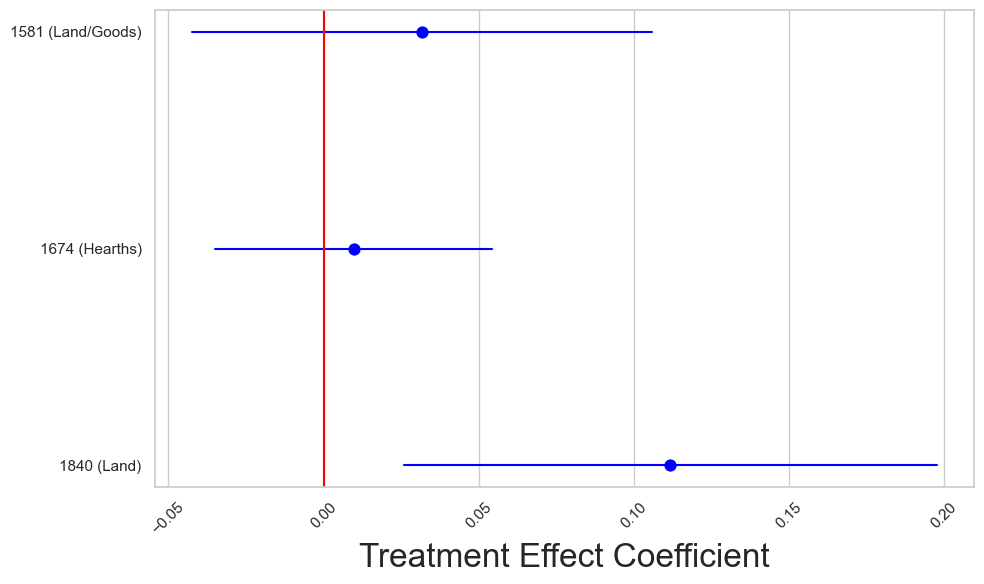

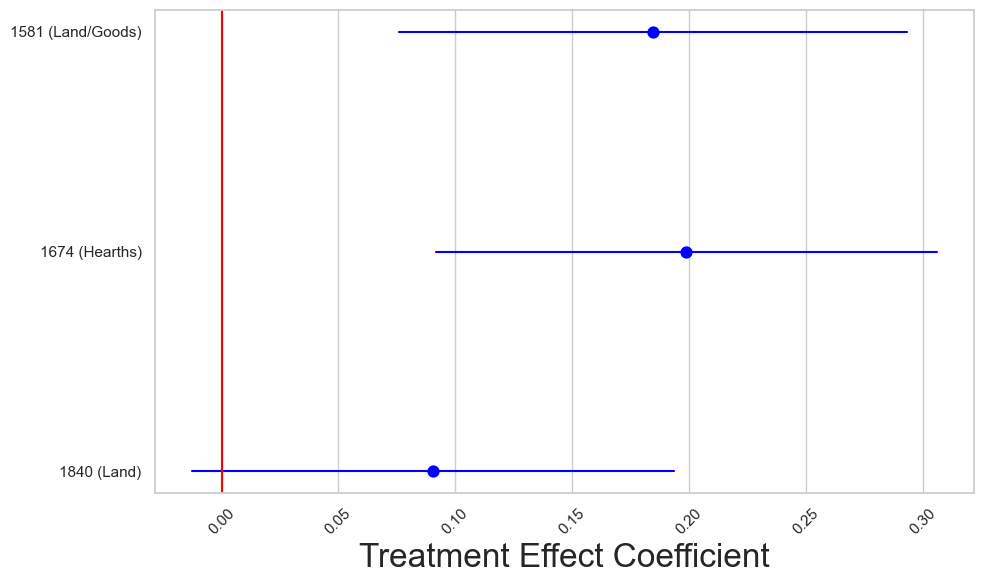

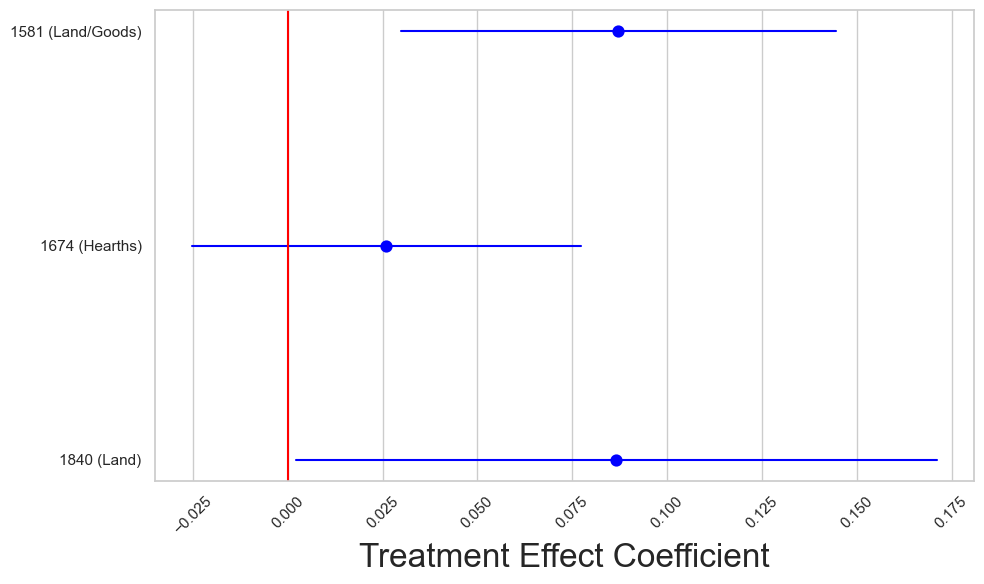

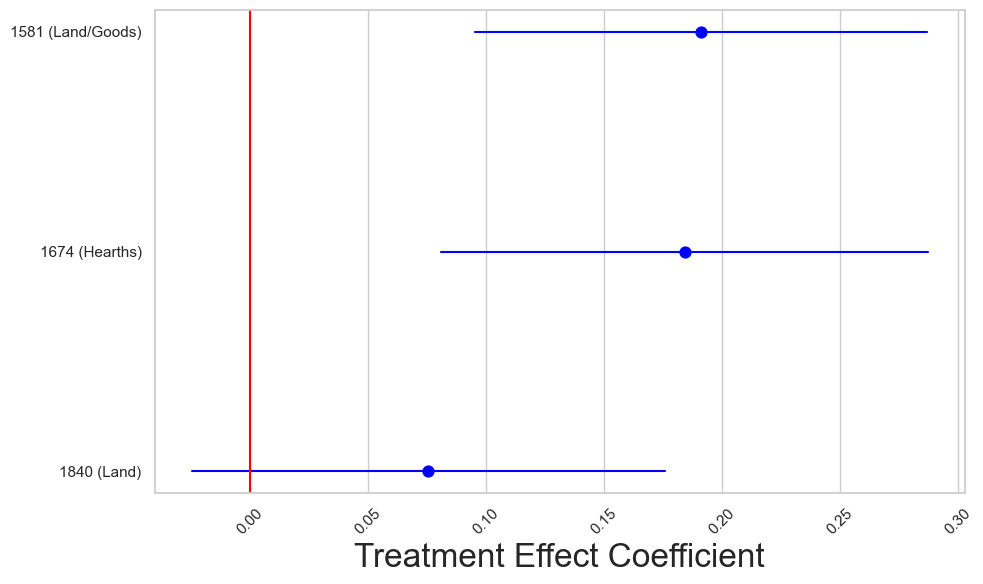

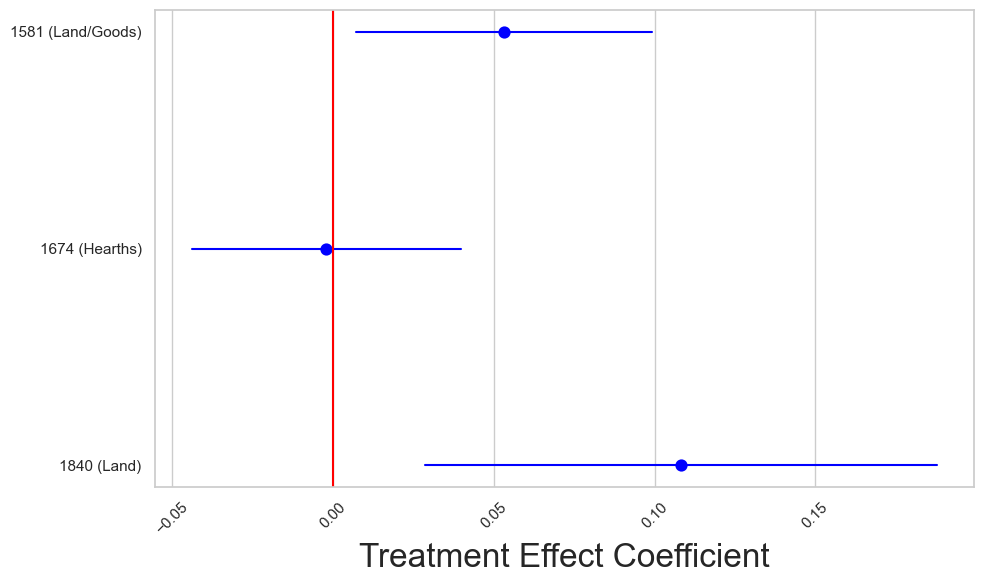

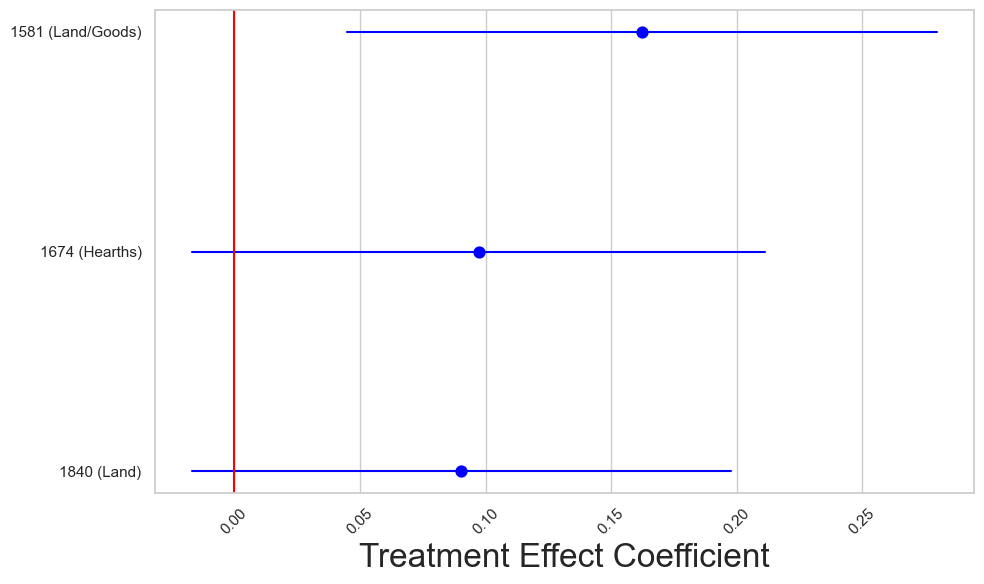

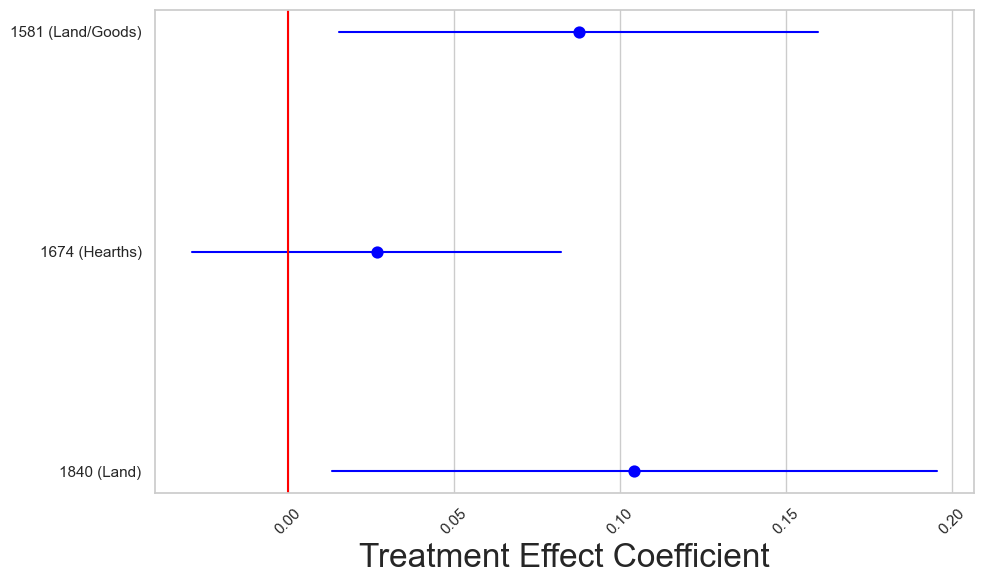

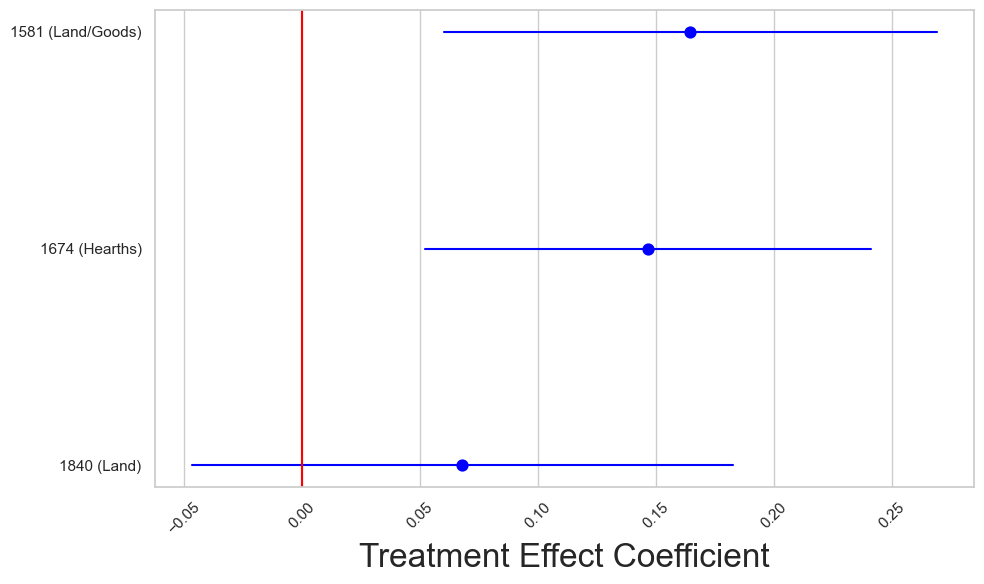

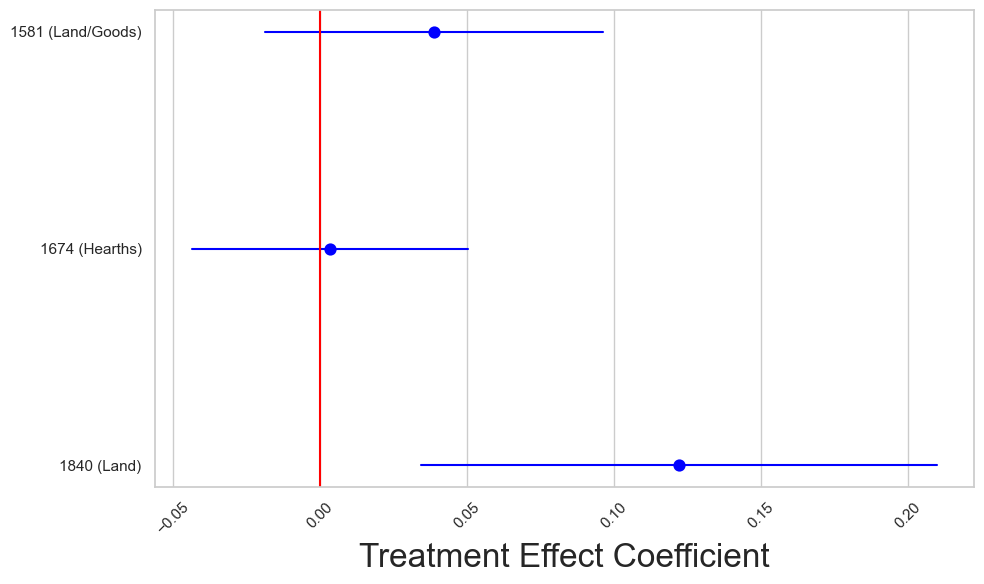

In [16]:
for id_type in [
    'unique',
    'group',
    'combined',
    'metaphone',
    'master'
]:

    df = pd.read_csv(f'{SURNAMES}/{id_type}_id_subsidy_data.csv')

    with open(f'{PROCESSED}/pretty_dict.json', 'r', encoding='utf-8') as f:
        pretty_dict = json.load(f)

    for year in [
        1524, 
        1543,
        1581,
        1674,
        1840
    ]:
        for measure in [
            'avg_val',
            'tot_val',
            'max_val',
            'count',
        ]:
            # fill zeroes with nan
            df[f'{measure}_{year}'] = df[f'{measure}_{year}'].apply(lambda x: 0 if pd.isna(x) else x)

    years_list = [1524, 1581, 1674, 1840]
    for measure in [
        'avg_val',
        'tot_val',
        'max_val',
        'count'
    ]:

        results_list = []
        plot_df_list = []
        for i, year in enumerate(years_list):
            if year == 1524:
                continue
            last_year = years_list[i - 1]

            sub_df = df.copy()
            sub_df = sub_df.loc[~pd.isna(sub_df['control2_group'])]
            sub_df[f'{measure}_pctile_{year}'] = sub_df[f'{measure}_{year}'].rank(pct=True)
            sub_df[f'{measure}_pctile_{last_year}'] = sub_df[f'{measure}_{last_year}'].rank(pct=True)


            x_vars = [f'{measure}_pctile_{last_year}', 'ln_parish_monastic_land', f'ln_parish_avg_value_{last_year}', f'parish_pop_density_{last_year}', 'parish_distriver', 'parish_distmkt']

            sub_df = sub_df.dropna(subset=[f'{measure}_{year}'] + x_vars + ['treatment', 'control'])

            x = sub_df[['treatment'] + x_vars]
            dummies = pd.get_dummies(sub_df['control2_group'], prefix='Control2', drop_first=True, dtype=int)
            x = pd.concat([x, dummies], axis=1)
            
            x.rename(columns={
                'treatment': 'Treatment',
                'control': 'Control',
                f'avg_val_pctile_{last_year}': f'Previous Avg Value Percentile',
                f'tot_val_pctile_{last_year}': f'Previous Total Value Percentile',
                f'max_val_pctile_{last_year}': f'Previous Max Value Percentile',
                f'count_pctile_{last_year}': f'Previous Count Percentile',
                f'parish_avg_value_{last_year}': 'Previous Parish Avg Value',
                f'parish_pop_density_{last_year}': 'Previous Parish Pop Density',
                'ln_parish_monastic_land': 'ln(Parish Monastic Land)',
                f'ln_parish_avg_value_{last_year}': 'ln(Previous Parish Avg Value)',
                f'parish_pop_density_{last_year}': 'Previous Parish Pop Density',
                'parish_distriver': 'Parish Distance to River',
                'parish_distmkt': 'Parish Distance to Market'
            }, inplace=True)
            y = sub_df[f'{measure}_pctile_{year}']
            x = sm.add_constant(x)
            x_cols = x.columns.tolist()
            for col in x_cols:
                if not col.startswith('Control2_'):
                    continue
                if x[col].sum() < 2:
                    x.drop(columns=[col], inplace=True)
                    print(f'Removing column:', col)

            
            model = sm.OLS(y, x)
            result = model.fit(cov_type='HC3')
            results_list.append(result)
            
            plot_df_list.append({
                'year': year,
                'coef': result.params['Treatment'],
                'se': result.bse['Treatment']
            })
        table = summary_col(results_list, stars=True, model_names=years_list[1:], info_dict={'N': lambda x: "{0:d}".format(int(x.nobs))}).as_latex()
        
        table = table.replace('\\begin{center}', '\\begin{center}\n\\resizebox{\\textwidth}{!}{')
        table = table.replace('\\end{tabular}', '\\end{tabular}\n}')
        table = table.replace('p<', 'p$<$')
        table = re.sub(r'(Control2[^\n]*\n\s*&[^\n]*\n)+', r'Match-Group Dummies & Y & Y & Y \\\\ \n', table)
        print(f'Writing table for {id_type.title()} and {measure}')
        print(table)
        with open(f'{TABLES}/{id_type}_{measure}_matched_results_zeroes.tex', 'w', encoding='utf-8') as f:
            f.write(table)

        plot_df = pd.DataFrame(plot_df_list)
        plot_df['lower'] = plot_df['coef'] - 1.96 * plot_df['se']
        plot_df['upper'] = plot_df['coef'] + 1.96 * plot_df['se']
        plot_df['year'] = plot_df['year'].astype(str)
        year_replace = {'1581': '1581 (Land/Goods)',
                        '1674': '1674 (Hearths)',
                        '1840': '1840 (Land)'}
        plot_df['year'] = plot_df['year'].replace(year_replace)
        plt.figure(figsize=(10, 6))
        sns.set_theme(style='whitegrid')
        sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
        for i, row in plot_df.iterrows():
            plt.plot([row['lower'], row['upper']], [row['year'], row['year']], color='blue')
        plt.xticks(rotation=45)
        plt.ylabel(None)
        plt.xlabel('Treatment Effect Coefficient', fontsize=24)
        plt.tight_layout()
        plt.axvline(x=0, color='red')
        plt.savefig(f'{IMAGES}/{id_type}_{measure}_treatment_effects_zeroes.png', dpi=300)

#### Matching Estimator, 1524 Comparator, Drop Zeroes

Writing table for Unique and avg_val
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581     & 1674      & 1840        \\
\hline
const                         & -0.6257  & 0.0997    & 0.2524      \\
                              & (1.1159) & (0.6478)  & (0.8351)    \\
Treatment                     & 0.2156** & 0.1054    & 0.0131      \\
                              & (0.0906) & (0.0758)  & (0.0843)    \\
Parish Distance to River      & 0.0025   & -0.0017   & -0.0147     \\
                              & (0.0498) & (0.0381)  & (0.0485)    \\
Parish Distance to Market     & 0.0179   & -0.0158   & 0.0364      \\
                              & (0.0373) & (0.0251)  & (0.0277)    \\
ln(Previous Parish Avg Value) & 0.8728   & 0.3673    & -0.1247     \\
                              & (0.6207) & (0.3368)  & (0.7560)    \\
Previous Parish Pop Density   & -0.0002  & -0.0002   & 0.0001      \\
           

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3204438236.py:119: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3204438236.py:119: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Unique and tot_val
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581      & 1674       & 1840        \\
\hline
const                         & 1.0405    & 1.0506**   & -0.3012     \\
                              & (1.1645)  & (0.4856)   & (0.9235)    \\
Treatment                     & 0.1789**  & 0.0506     & 0.1191      \\
                              & (0.0826)  & (0.0482)   & (0.0844)    \\
Parish Distance to River      & -0.0407   & -0.0209    & -0.0180     \\
                              & (0.0422)  & (0.0271)   & (0.0449)    \\
Parish Distance to Market     & 0.0301    & -0.0114    & 0.0172      \\
                              & (0.0311)  & (0.0216)   & (0.0286)    \\
ln(Previous Parish Avg Value) & 0.0226    & 0.2341     & 0.5395      \\
                              & (0.6977)  & (0.2366)   & (0.7246)    \\
Previous Parish Pop Density   & -0.0002   & -0.0000    & -0

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3204438236.py:119: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3204438236.py:119: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Unique and max_val
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581      & 1674      & 1840        \\
\hline
const                         & 0.6072    & 0.4460    & 0.5744      \\
                              & (1.1254)  & (0.6659)  & (0.9873)    \\
Treatment                     & 0.2369*** & 0.1494**  & 0.0867      \\
                              & (0.0911)  & (0.0702)  & (0.0934)    \\
Parish Distance to River      & 0.0046    & -0.0284   & -0.0190     \\
                              & (0.0479)  & (0.0274)  & (0.0431)    \\
Parish Distance to Market     & 0.0015    & -0.0038   & 0.0207      \\
                              & (0.0360)  & (0.0268)  & (0.0312)    \\
ln(Previous Parish Avg Value) & 0.1680    & 0.2239    & -0.1347     \\
                              & (0.6685)  & (0.3108)  & (0.7892)    \\
Previous Parish Pop Density   & -0.0003   & 0.0002    & 0.0000      \\

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3204438236.py:119: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3204438236.py:119: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Unique and count
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581      & 1674       & 1840        \\
\hline
const                         & 1.7457    & 1.1071***  & -0.3505     \\
                              & (1.1908)  & (0.4029)   & (0.9522)    \\
Treatment                     & 0.0810    & -0.0092    & 0.1209      \\
                              & (0.0784)  & (0.0425)   & (0.0837)    \\
Parish Distance to River      & -0.0269   & -0.0216    & -0.0130     \\
                              & (0.0481)  & (0.0298)   & (0.0462)    \\
Parish Distance to Market     & 0.0124    & -0.0037    & 0.0142      \\
                              & (0.0394)  & (0.0193)   & (0.0308)    \\
ln(Previous Parish Avg Value) & -0.4958   & 0.1830     & 0.6243      \\
                              & (0.6921)  & (0.2086)   & (0.7338)    \\
Previous Parish Pop Density   & -0.0001   & 0.0001     & -0.0

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3204438236.py:119: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3204438236.py:119: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Group and avg_val
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581      & 1674      & 1840      \\
\hline
const                         & 0.4966    & 0.3417    & 0.1081    \\
                              & (0.9934)  & (0.6109)  & (1.1305)  \\
Treatment                     & 0.2525*** & 0.2133*** & 0.0566    \\
                              & (0.0768)  & (0.0671)  & (0.0862)  \\
Parish Distance to River      & -0.0312   & -0.0216   & -0.0110   \\
                              & (0.0502)  & (0.0357)  & (0.0455)  \\
Parish Distance to Market     & 0.0142    & 0.0014    & 0.0403    \\
                              & (0.0378)  & (0.0249)  & (0.0369)  \\
ln(Previous Parish Avg Value) & -0.1906   & 0.1686    & -0.1154   \\
                              & (0.5018)  & (0.2935)  & (0.8456)  \\
Previous Parish Pop Density   & -0.0001   & -0.0000   & 0.0002    \\
                        

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3204438236.py:119: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3204438236.py:119: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Group and tot_val
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581      & 1674       & 1840      \\
\hline
const                         & 0.2478    & 0.4572     & -0.2702   \\
                              & (1.0755)  & (0.4749)   & (1.1335)  \\
Treatment                     & 0.1373*   & 0.1100***  & 0.1181    \\
                              & (0.0740)  & (0.0389)   & (0.0879)  \\
Parish Distance to River      & -0.0174   & -0.0112    & -0.0215   \\
                              & (0.0491)  & (0.0265)   & (0.0600)  \\
Parish Distance to Market     & 0.0020    & 0.0180     & 0.0018    \\
                              & (0.0314)  & (0.0183)   & (0.0351)  \\
ln(Previous Parish Avg Value) & 0.0778    & 0.2204     & 0.7749    \\
                              & (0.5800)  & (0.1682)   & (0.7511)  \\
Previous Parish Pop Density   & 0.0000    & 0.0003     & 0.0000    \\
            

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3204438236.py:119: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3204438236.py:119: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Group and max_val
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581      & 1674       & 1840      \\
\hline
const                         & 1.0859    & 0.1757     & 0.0509    \\
                              & (1.0874)  & (0.5304)   & (0.8158)  \\
Treatment                     & 0.2477*** & 0.2302***  & 0.1031    \\
                              & (0.0798)  & (0.0553)   & (0.0786)  \\
Parish Distance to River      & -0.0133   & -0.0201    & -0.0374   \\
                              & (0.0537)  & (0.0271)   & (0.0566)  \\
Parish Distance to Market     & -0.0304   & 0.0170     & 0.0006    \\
                              & (0.0366)  & (0.0216)   & (0.0314)  \\
ln(Previous Parish Avg Value) & -0.2929   & 0.2754     & 0.4990    \\
                              & (0.5889)  & (0.2254)   & (0.7918)  \\
Previous Parish Pop Density   & -0.0000   & 0.0003     & 0.0001    \\
            

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3204438236.py:119: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3204438236.py:119: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Group and count
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581       & 1674       & 1840      \\
\hline
const                         & -0.1167    & 0.3489     & -0.1834   \\
                              & (1.0095)   & (0.4612)   & (1.1826)  \\
Treatment                     & 0.0510     & 0.0397     & 0.1097    \\
                              & (0.0727)   & (0.0313)   & (0.0859)  \\
Parish Distance to River      & -0.0090    & -0.0115    & -0.0254   \\
                              & (0.0449)   & (0.0219)   & (0.0574)  \\
Parish Distance to Market     & 0.0127     & 0.0210     & 0.0004    \\
                              & (0.0263)   & (0.0162)   & (0.0348)  \\
ln(Previous Parish Avg Value) & 0.2563     & 0.2445     & 0.7316    \\
                              & (0.5348)   & (0.1682)   & (0.7644)  \\
Previous Parish Pop Density   & 0.0001     & 0.0004     & 0.0000    \\
  

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3204438236.py:119: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3204438236.py:119: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Combined and avg_val
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581      & 1674      & 1840        \\
\hline
const                         & 0.9321    & 0.6189    & -0.4342     \\
                              & (1.2893)  & (0.6235)  & (1.0472)    \\
Treatment                     & 0.2554*** & 0.2150*** & 0.0073      \\
                              & (0.0810)  & (0.0668)  & (0.0878)    \\
Parish Distance to River      & -0.0236   & -0.0107   & 0.0621*     \\
                              & (0.0395)  & (0.0312)  & (0.0374)    \\
Parish Distance to Market     & -0.0017   & 0.0042    & 0.0140      \\
                              & (0.0315)  & (0.0250)  & (0.0351)    \\
ln(Previous Parish Avg Value) & -0.3813   & 0.0287    & 0.5874      \\
                              & (0.6774)  & (0.3469)  & (0.9464)    \\
Previous Parish Pop Density   & -0.0001   & 0.0003    & -0.0001     

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3204438236.py:119: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3204438236.py:119: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Combined and tot_val
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581       & 1674       & 1840        \\
\hline
const                         & 0.3714     & 0.3366     & -0.4987     \\
                              & (1.3187)   & (0.5141)   & (0.9896)    \\
Treatment                     & 0.1462**   & 0.1053**   & 0.0907      \\
                              & (0.0583)   & (0.0415)   & (0.0839)    \\
Parish Distance to River      & -0.0017    & 0.0006     & 0.0493*     \\
                              & (0.0245)   & (0.0176)   & (0.0279)    \\
Parish Distance to Market     & -0.0029    & 0.0032     & -0.0214     \\
                              & (0.0249)   & (0.0157)   & (0.0303)    \\
ln(Previous Parish Avg Value) & -0.0074    & 0.3165*    & 1.1318*     \\
                              & (0.7008)   & (0.1904)   & (0.6154)    \\
Previous Parish Pop Density   & 0.0002     & 0

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3204438236.py:119: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3204438236.py:119: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Combined and max_val
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581       & 1674       & 1840        \\
\hline
const                         & 0.8173     & 0.2317     & -0.3300     \\
                              & (1.3372)   & (0.5216)   & (0.9248)    \\
Treatment                     & 0.2537***  & 0.2360***  & 0.0580      \\
                              & (0.0734)   & (0.0543)   & (0.0777)    \\
Parish Distance to River      & -0.0008    & -0.0070    & 0.0470*     \\
                              & (0.0338)   & (0.0238)   & (0.0277)    \\
Parish Distance to Market     & -0.0092    & 0.0105     & -0.0242     \\
                              & (0.0317)   & (0.0204)   & (0.0300)    \\
ln(Previous Parish Avg Value) & -0.2625    & 0.2836     & 1.0259      \\
                              & (0.7208)   & (0.2401)   & (0.7281)    \\
Previous Parish Pop Density   & 0.0001     & 0

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3204438236.py:119: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3204438236.py:119: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Combined and count
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581       & 1674       & 1840        \\
\hline
const                         & 0.0179     & 0.2012     & -0.2703     \\
                              & (1.1726)   & (0.4822)   & (1.1107)    \\
Treatment                     & 0.0610     & 0.0321     & 0.0877      \\
                              & (0.0502)   & (0.0350)   & (0.0831)    \\
Parish Distance to River      & 0.0057     & -0.0020    & 0.0382      \\
                              & (0.0213)   & (0.0150)   & (0.0288)    \\
Parish Distance to Market     & 0.0035     & 0.0047     & -0.0196     \\
                              & (0.0226)   & (0.0132)   & (0.0324)    \\
ln(Previous Parish Avg Value) & 0.1817     & 0.3497**   & 0.9533      \\
                              & (0.6151)   & (0.1745)   & (0.6458)    \\
Previous Parish Pop Density   & 0.0003     & 0.0

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3204438236.py:119: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3204438236.py:119: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Metaphone and avg_val
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581      & 1674      & 1840      \\
\hline
const                         & 0.1686    & 1.6208*   & -0.0703   \\
                              & (1.1967)  & (0.8610)  & (1.0866)  \\
Treatment                     & 0.1920*** & 0.2060*** & 0.0454    \\
                              & (0.0623)  & (0.0533)  & (0.0631)  \\
Parish Distance to River      & -0.0094   & -0.0148   & -0.0017   \\
                              & (0.0534)  & (0.0283)  & (0.0386)  \\
Parish Distance to Market     & 0.0030    & -0.0253   & 0.0078    \\
                              & (0.0370)  & (0.0247)  & (0.0375)  \\
ln(Previous Parish Avg Value) & 0.2335    & -0.4293   & -0.2361   \\
                              & (0.6151)  & (0.3725)  & (0.7855)  \\
Previous Parish Pop Density   & -0.0005*  & 0.0002    & -0.0000   \\
                    

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3204438236.py:119: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3204438236.py:119: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Metaphone and tot_val
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581       & 1674       & 1840       \\
\hline
const                         & -0.0889    & 0.4076     & 0.5263     \\
                              & (0.6970)   & (0.5390)   & (0.7209)   \\
Treatment                     & 0.0865**   & 0.0858***  & 0.1251***  \\
                              & (0.0377)   & (0.0289)   & (0.0483)   \\
Parish Distance to River      & -0.0141    & 0.0148     & 0.0228     \\
                              & (0.0186)   & (0.0242)   & (0.0334)   \\
Parish Distance to Market     & 0.0269     & 0.0027     & 0.0146     \\
                              & (0.0165)   & (0.0129)   & (0.0315)   \\
ln(Previous Parish Avg Value) & 0.6519*    & 0.0906     & 0.1719     \\
                              & (0.3608)   & (0.2086)   & (0.5212)   \\
Previous Parish Pop Density   & -0.0001    & 0.0002     

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3204438236.py:119: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3204438236.py:119: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Metaphone and max_val
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581       & 1674      & 1840      \\
\hline
const                         & 0.2269     & 0.6775    & 0.6572    \\
                              & (1.0101)   & (0.6929)  & (0.7670)  \\
Treatment                     & 0.2068***  & 0.2454*** & 0.1000*   \\
                              & (0.0587)   & (0.0464)  & (0.0534)  \\
Parish Distance to River      & -0.0132    & 0.0016    & 0.0282    \\
                              & (0.0408)   & (0.0307)  & (0.0349)  \\
Parish Distance to Market     & 0.0424     & 0.0008    & 0.0054    \\
                              & (0.0333)   & (0.0185)  & (0.0317)  \\
ln(Previous Parish Avg Value) & 0.3211     & -0.0218   & -0.1006   \\
                              & (0.5098)   & (0.3178)  & (0.5385)  \\
Previous Parish Pop Density   & -0.0004*   & 0.0004    & -0.0001   \\
        

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3204438236.py:119: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3204438236.py:119: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Metaphone and count
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581       & 1674       & 1840       \\
\hline
const                         & -0.1338    & 0.1377     & 0.6026     \\
                              & (0.6306)   & (0.5252)   & (0.6991)   \\
Treatment                     & 0.0304     & 0.0367     & 0.1191***  \\
                              & (0.0303)   & (0.0282)   & (0.0460)   \\
Parish Distance to River      & -0.0095    & 0.0145     & 0.0295     \\
                              & (0.0118)   & (0.0202)   & (0.0338)   \\
Parish Distance to Market     & 0.0274**   & 0.0078     & 0.0155     \\
                              & (0.0138)   & (0.0114)   & (0.0314)   \\
ln(Previous Parish Avg Value) & 0.5756*    & 0.2076     & 0.1749     \\
                              & (0.3288)   & (0.2044)   & (0.4997)   \\
Previous Parish Pop Density   & -0.0000    & 0.0002     & 

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3204438236.py:119: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3204438236.py:119: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Master and avg_val
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581      & 1674      & 1840       \\
\hline
const                         & 0.8822    & 0.4353    & -0.8344    \\
                              & (1.0005)  & (0.8097)  & (0.9021)   \\
Treatment                     & 0.2103*** & 0.1455**  & -0.0023    \\
                              & (0.0668)  & (0.0598)  & (0.0799)   \\
Parish Distance to River      & -0.0078   & 0.0641*   & 0.0387     \\
                              & (0.0465)  & (0.0377)  & (0.0531)   \\
Parish Distance to Market     & -0.0047   & -0.0118   & 0.0074     \\
                              & (0.0325)  & (0.0194)  & (0.0257)   \\
ln(Previous Parish Avg Value) & -0.0656   & 0.1651    & 1.0250     \\
                              & (0.5605)  & (0.3307)  & (0.7971)   \\
Previous Parish Pop Density   & -0.0002*  & 0.0001    & -0.0001    \\
           

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3204438236.py:119: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3204438236.py:119: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Master and tot_val
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581       & 1674       & 1840        \\
\hline
const                         & 1.6843**   & 0.7348*    & -0.7332     \\
                              & (0.7567)   & (0.3930)   & (0.6332)    \\
Treatment                     & 0.1034**   & 0.0724**   & 0.0831      \\
                              & (0.0453)   & (0.0323)   & (0.0686)    \\
Parish Distance to River      & -0.0009    & 0.0262     & 0.0133      \\
                              & (0.0208)   & (0.0167)   & (0.0367)    \\
Parish Distance to Market     & 0.0139     & -0.0043    & 0.0071      \\
                              & (0.0181)   & (0.0091)   & (0.0173)    \\
ln(Previous Parish Avg Value) & -0.7185**  & 0.0231     & 0.9446*     \\
                              & (0.3656)   & (0.1491)   & (0.5264)    \\
Previous Parish Pop Density   & -0.0001    & 0.0

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3204438236.py:119: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3204438236.py:119: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Master and max_val
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581       & 1674       & 1840        \\
\hline
const                         & 1.4002*    & 0.5621     & -1.1020     \\
                              & (0.7961)   & (0.5597)   & (0.7348)    \\
Treatment                     & 0.2089***  & 0.2136***  & 0.0288      \\
                              & (0.0659)   & (0.0502)   & (0.0695)    \\
Parish Distance to River      & -0.0014    & 0.0350     & -0.0030     \\
                              & (0.0280)   & (0.0270)   & (0.0431)    \\
Parish Distance to Market     & 0.0099     & 0.0005     & 0.0184      \\
                              & (0.0233)   & (0.0132)   & (0.0192)    \\
ln(Previous Parish Avg Value) & -0.4338    & 0.1191     & 1.2361*     \\
                              & (0.3910)   & (0.2274)   & (0.6362)    \\
Previous Parish Pop Density   & -0.0001    & 0.0

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3204438236.py:119: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3204438236.py:119: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Master and count
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581       & 1674       & 1840        \\
\hline
const                         & 1.5171*    & 0.6158*    & -0.5961     \\
                              & (0.8188)   & (0.3333)   & (0.6517)    \\
Treatment                     & 0.0299     & 0.0252     & 0.0856      \\
                              & (0.0349)   & (0.0289)   & (0.0666)    \\
Parish Distance to River      & -0.0012    & 0.0178     & 0.0116      \\
                              & (0.0195)   & (0.0139)   & (0.0356)    \\
Parish Distance to Market     & 0.0197     & -0.0035    & 0.0083      \\
                              & (0.0196)   & (0.0082)   & (0.0169)    \\
ln(Previous Parish Avg Value) & -0.6544*   & 0.0074     & 0.8051      \\
                              & (0.3916)   & (0.1213)   & (0.5267)    \\
Previous Parish Pop Density   & -0.0000    & 0.000

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3204438236.py:119: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\3204438236.py:119: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


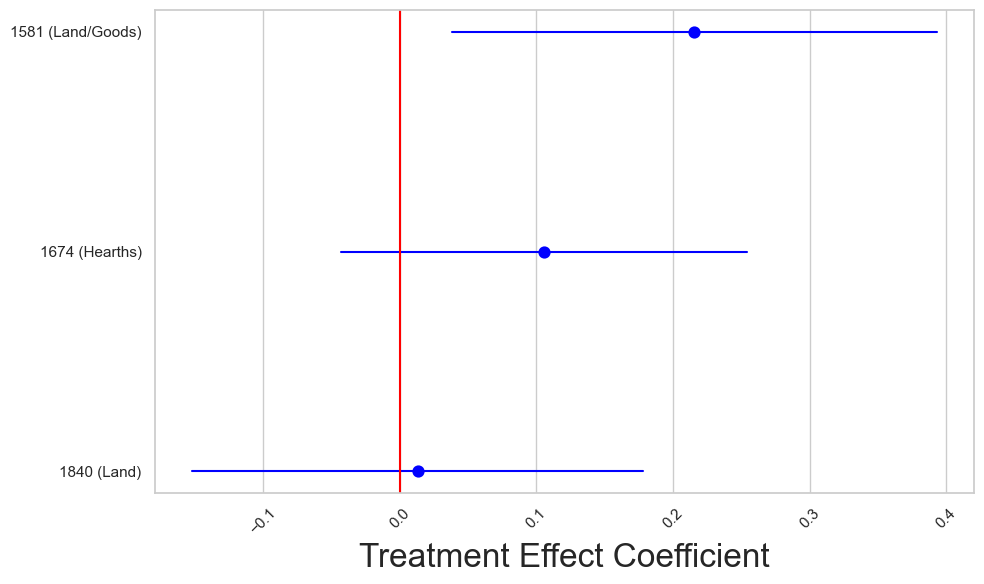

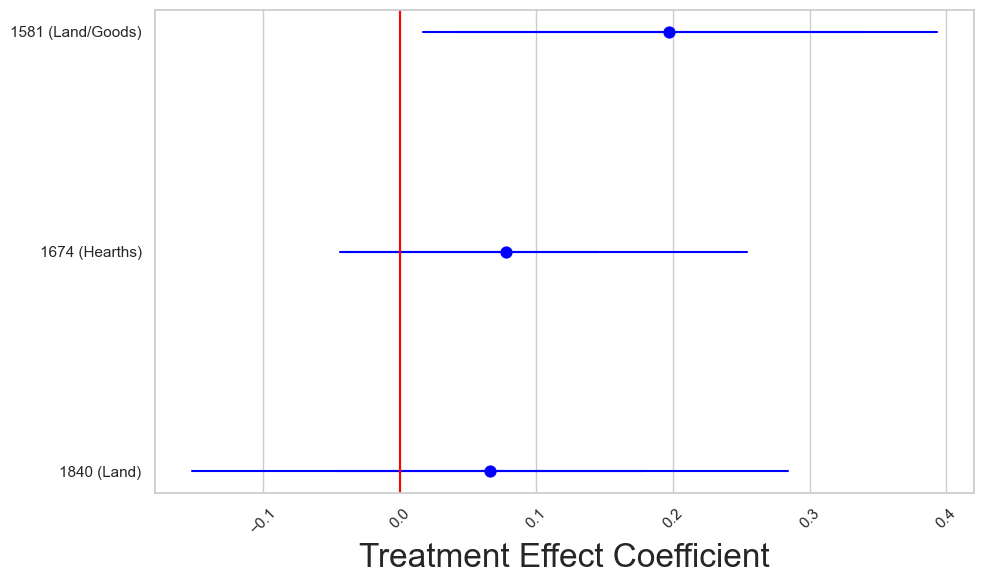

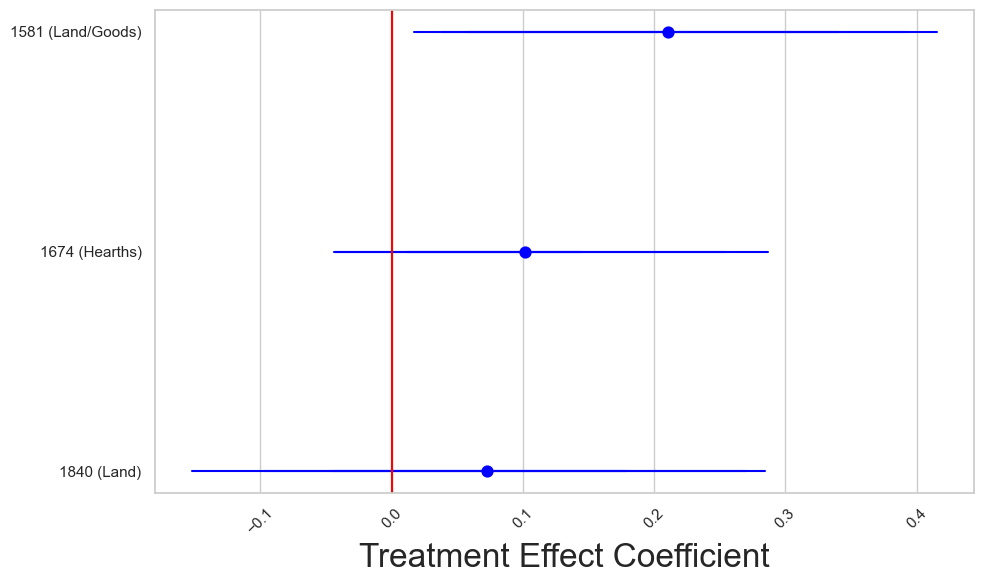

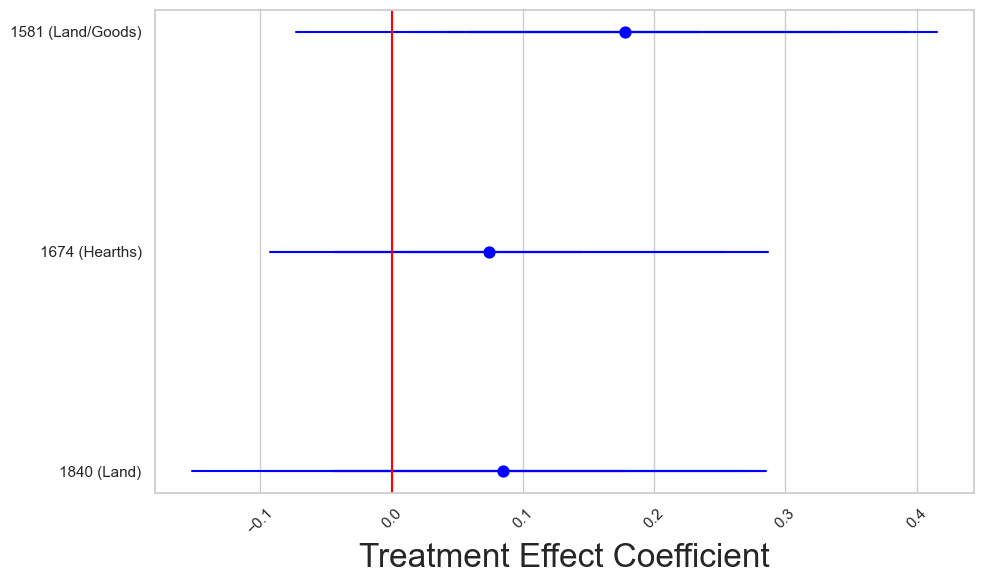

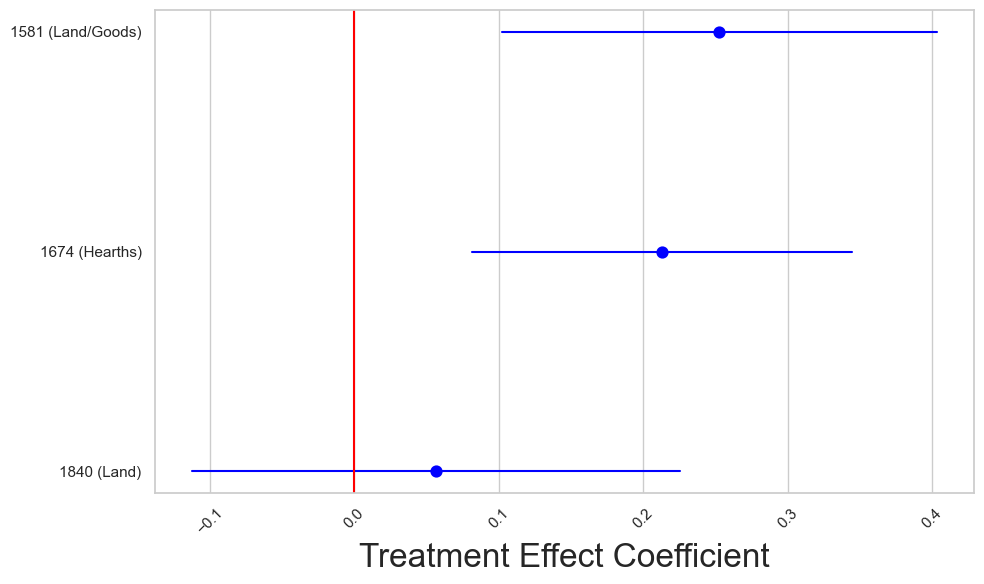

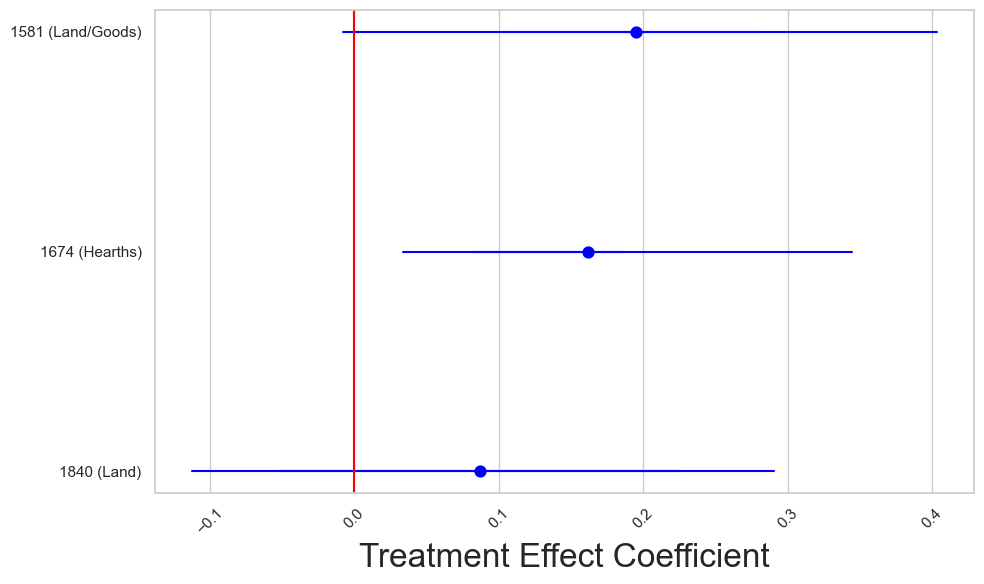

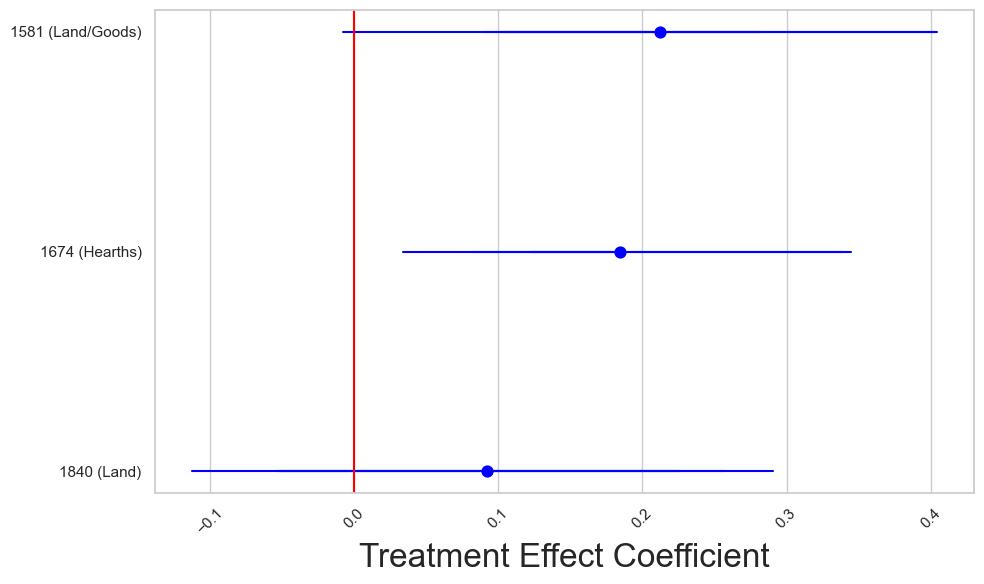

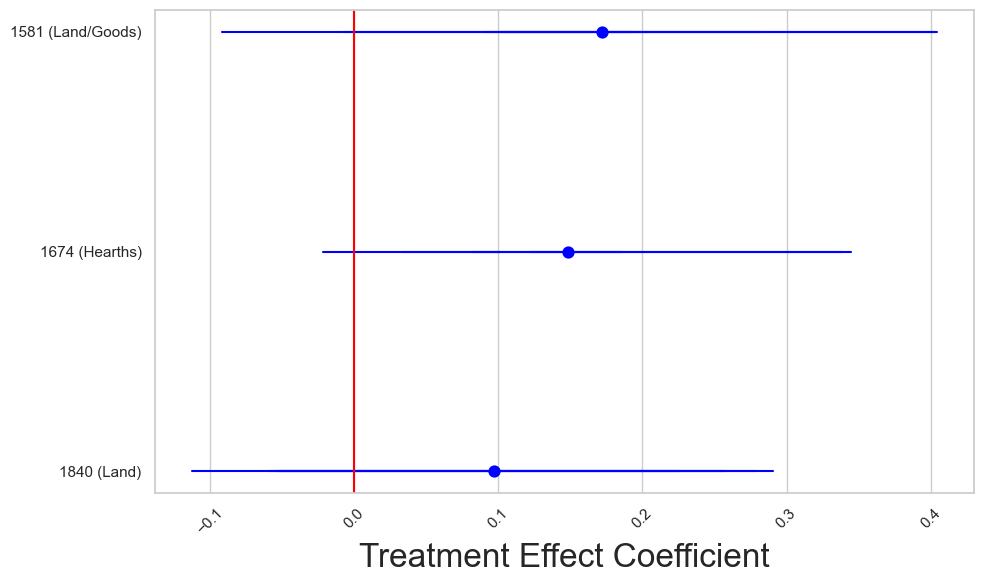

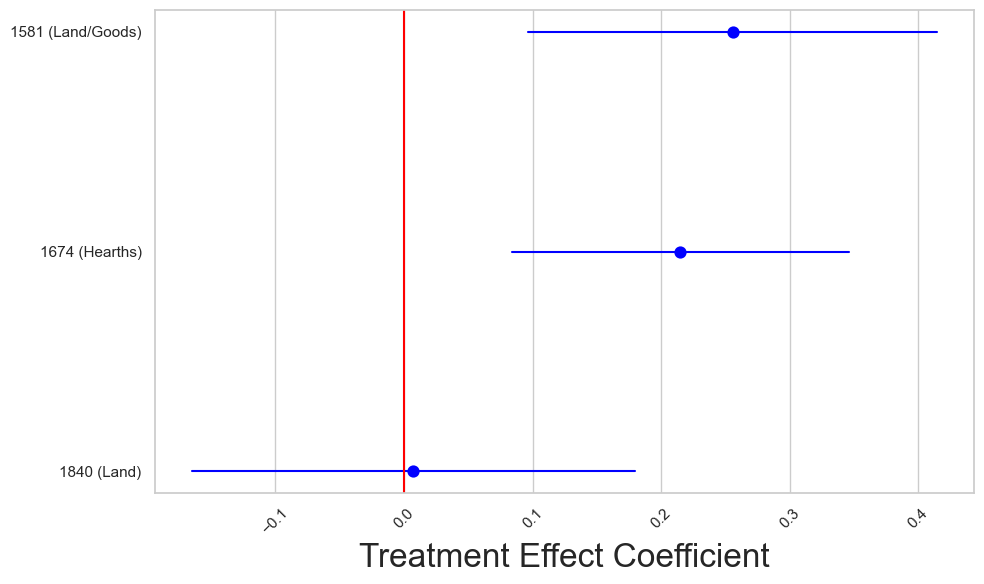

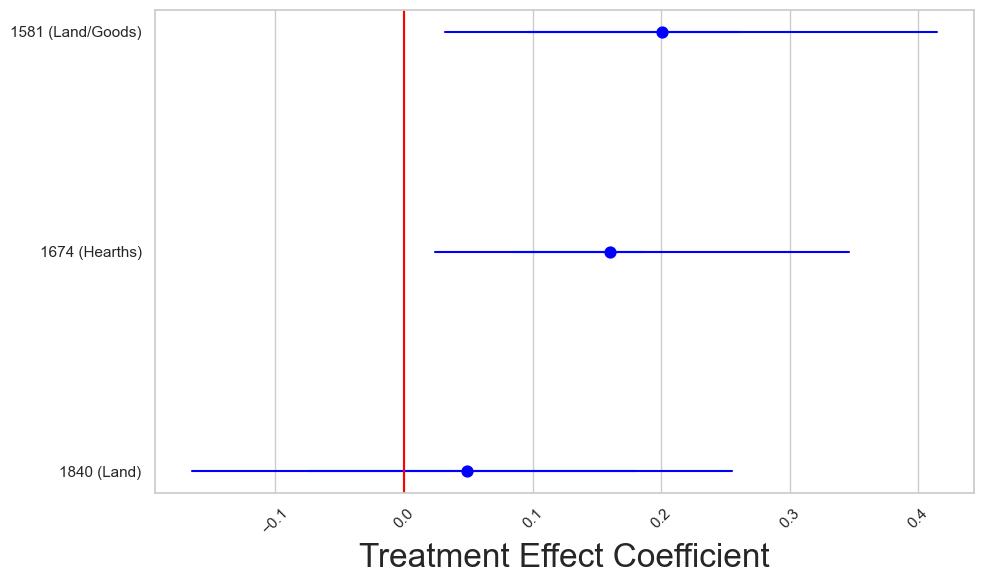

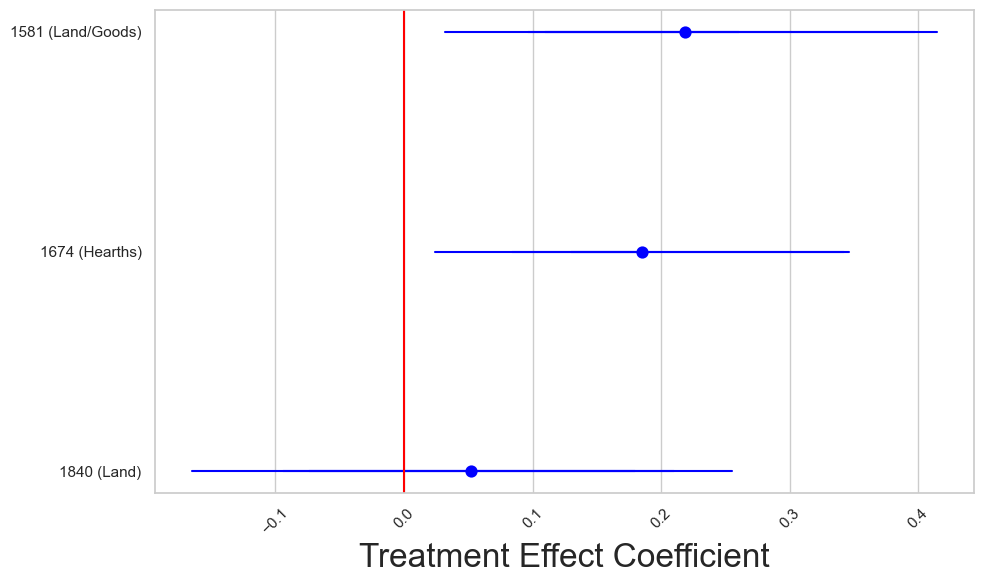

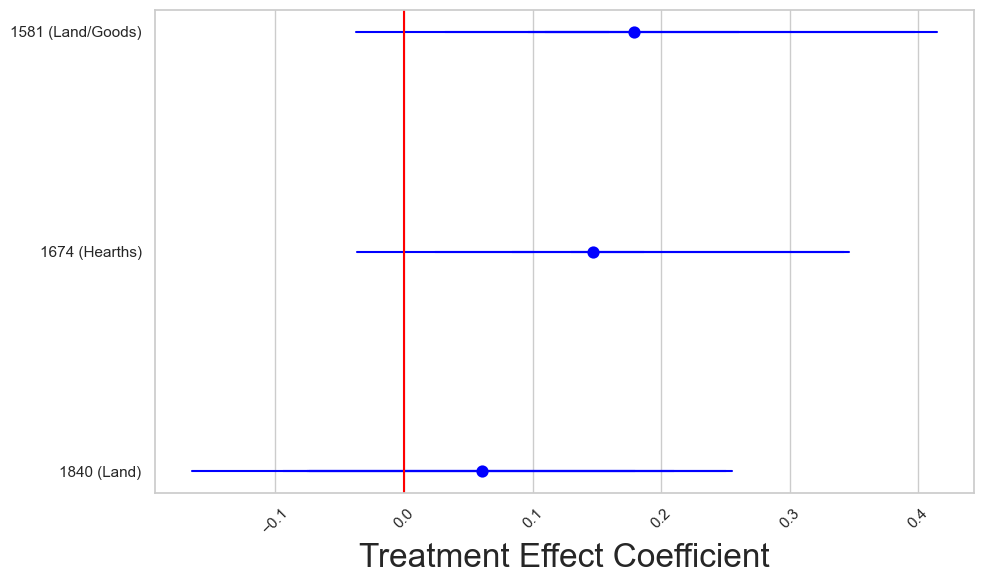

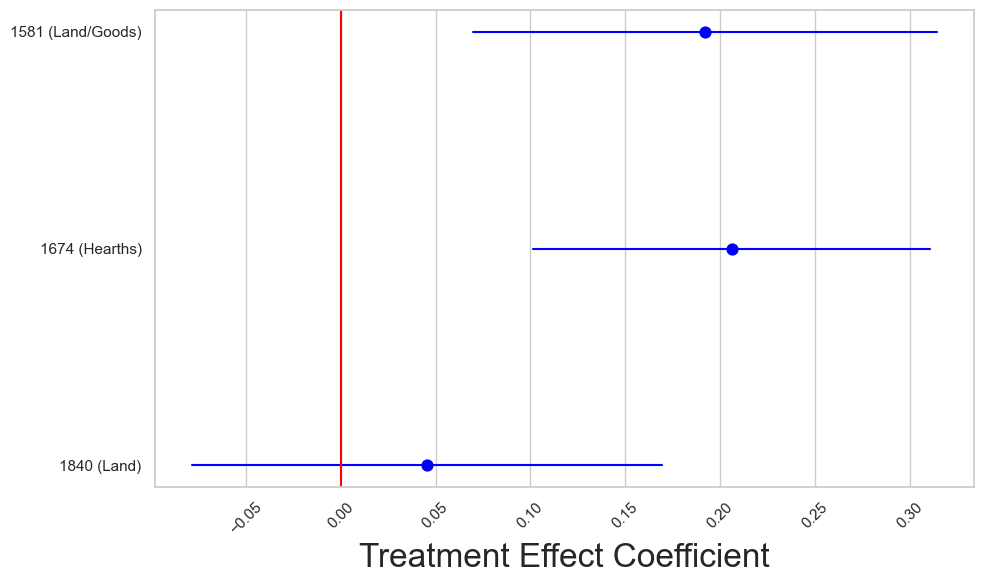

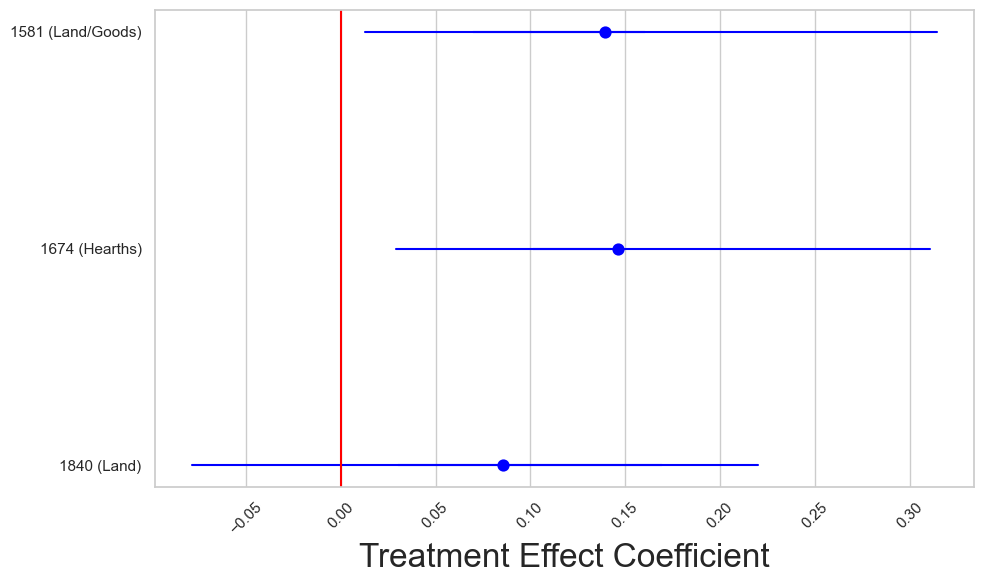

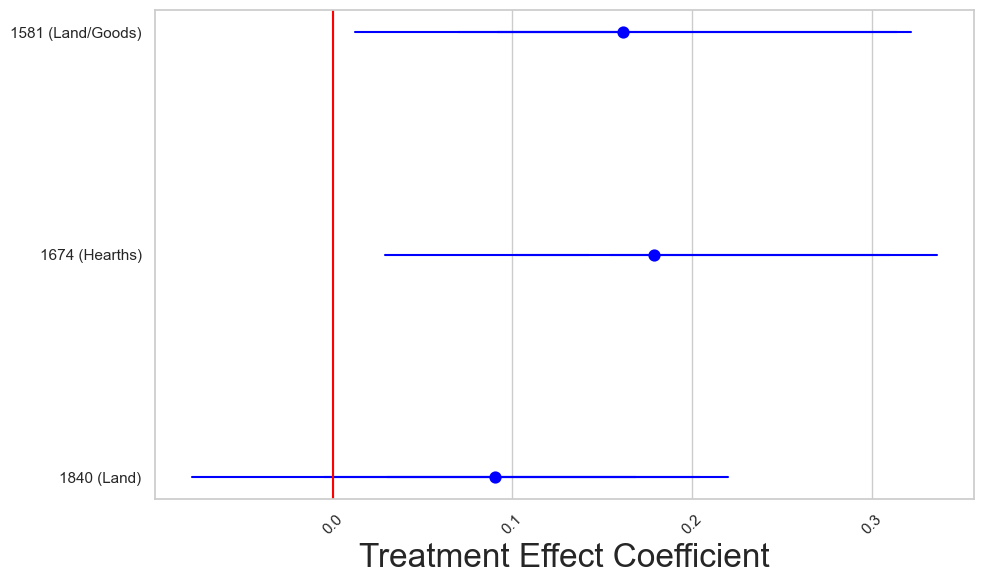

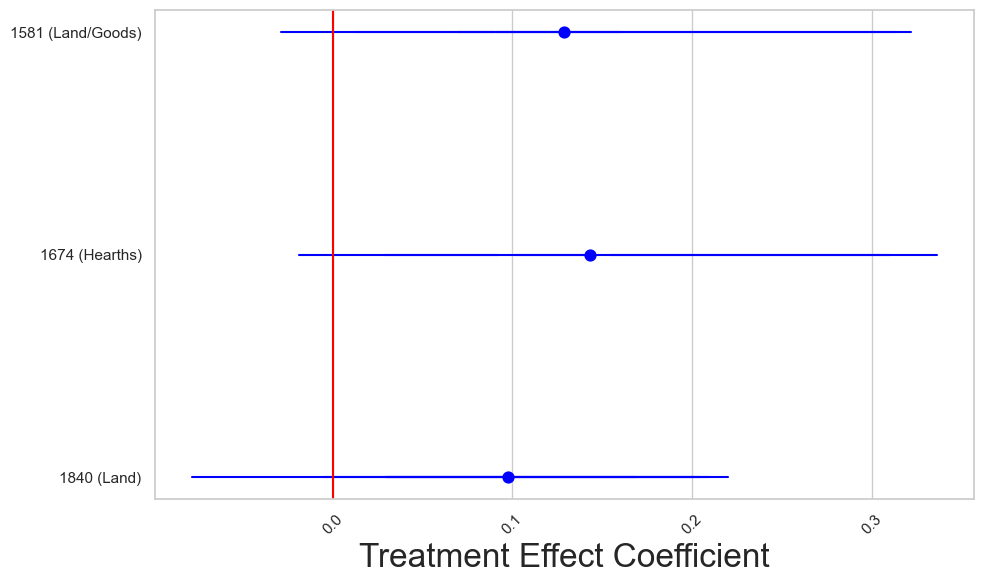

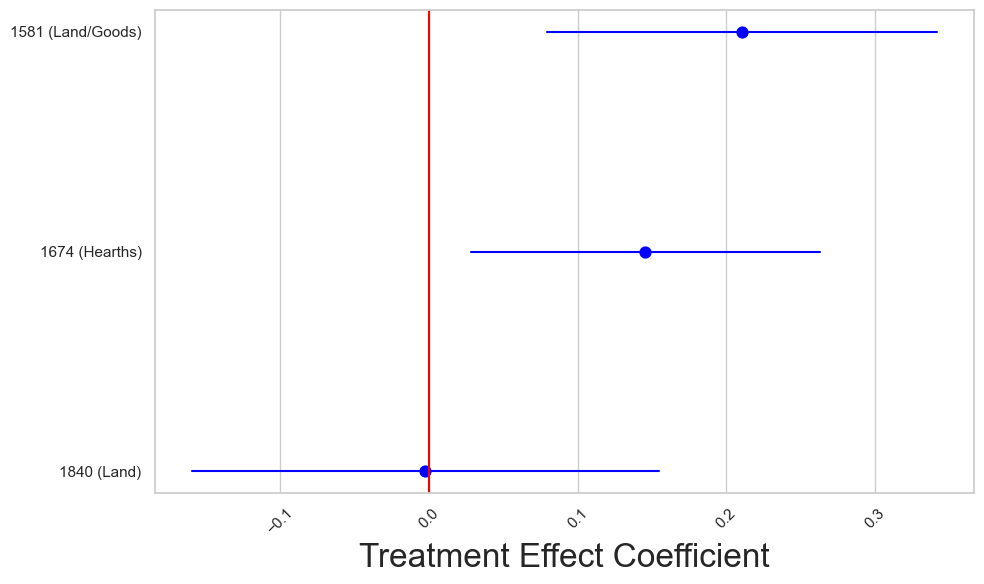

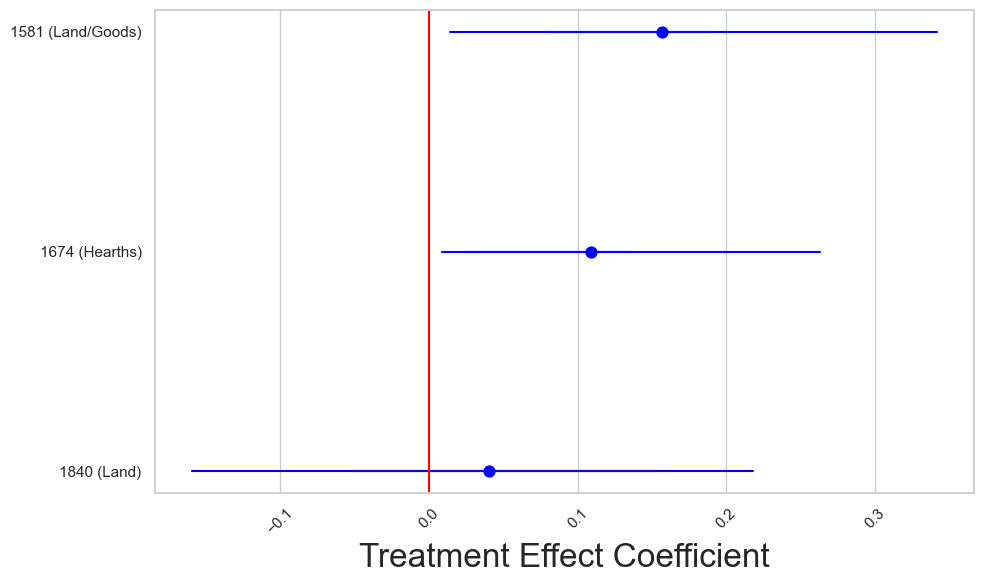

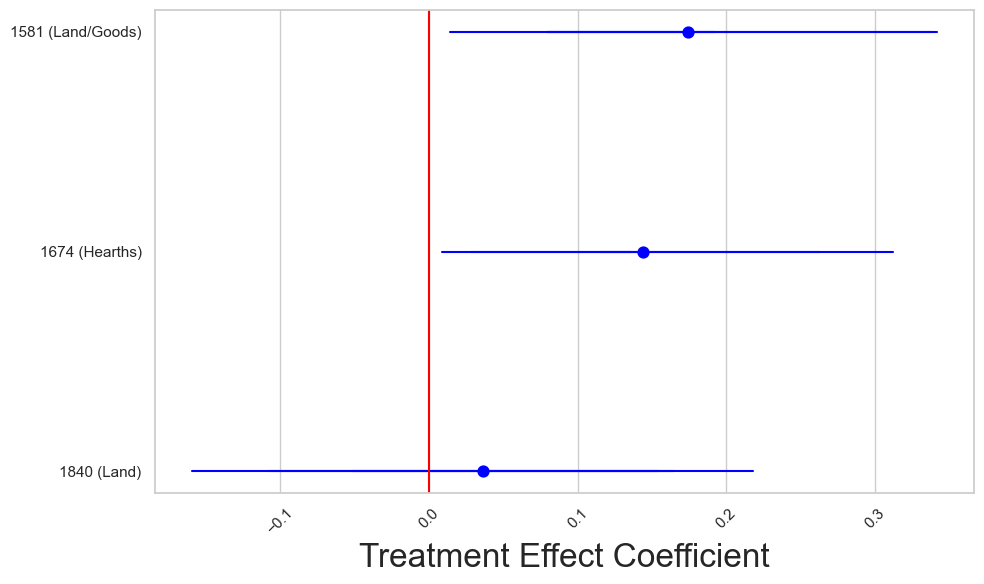

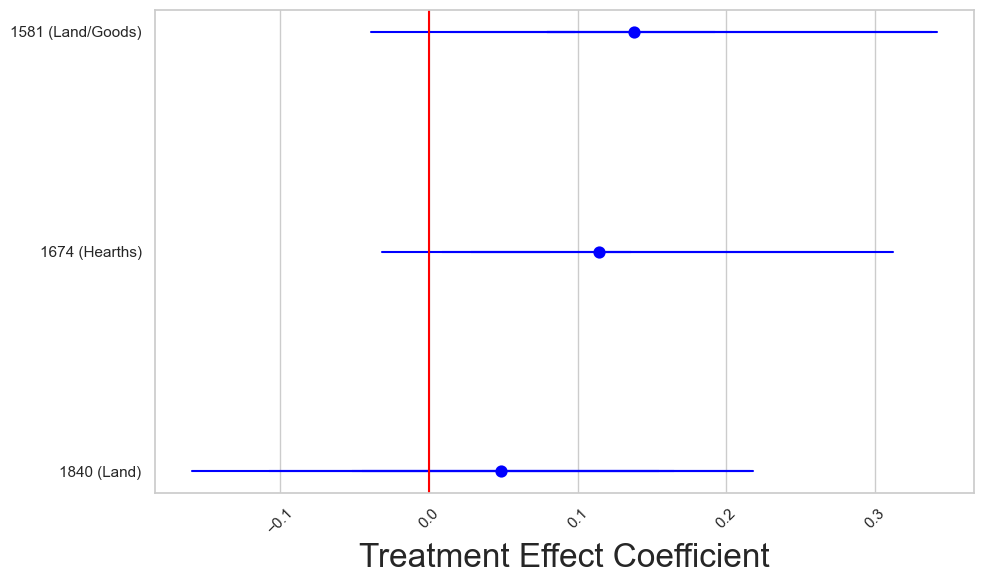

In [17]:
for id_type in [
    'unique',
    'group',
    'combined',
    'metaphone',
    'master'
]:

    df = pd.read_csv(f'{SURNAMES}/{id_type}_id_subsidy_data.csv')

    with open(f'{PROCESSED}/pretty_dict.json', 'r', encoding='utf-8') as f:
        pretty_dict = json.load(f)

    for year in [
        1524, 
        1543,
        1581,
        1674,
        1840
    ]:
        for measure in [
            'avg_val',
            'tot_val',
            'max_val',
            'count',
        ]:
            # fill zeroes with nan
            df[f'{measure}_{year}'] = df[f'{measure}_{year}'].apply(lambda x: np.nan if x == 0 else x)

    years_list = [1524, 1581, 1674, 1840]
    plot_df_list = []
    for measure in [
        'avg_val',
        'tot_val',
        'max_val',
        'count'
    ]:

        results_list = []
        for i, year in enumerate(years_list):
            if year == 1524:
                continue
            last_year = years_list[i - 1]

            sub_df = df.copy()
            sub_df = sub_df.loc[~pd.isna(sub_df['control2_group'])]
            sub_df[f'{measure}_pctile_1524'] = sub_df[f'{measure}_{1524}'].rank(pct=True)
            sub_df[f'{measure}_pctile_{year}'] = sub_df[f'{measure}_{year}'].rank(pct=True)
            sub_df[f'{measure}_pctile_{last_year}'] = sub_df[f'{measure}_{last_year}'].rank(pct=True)


            x_vars = ['parish_distriver', 'parish_distmkt', f'ln_parish_avg_value_{last_year}', f'parish_pop_density_{last_year}', 'ln_parish_monastic_land']

            sub_df = sub_df.dropna(subset=[f'{measure}_{year}'] + x_vars + ['treatment', 'control'])

            x = sub_df[['treatment'] + x_vars]
            dummies = pd.get_dummies(sub_df['control2_group'], prefix='Control2', drop_first=True, dtype=int)
            x = pd.concat([x, dummies], axis=1)
            
            x.rename(columns={
                'treatment': 'Treatment',
                'control': 'Control',
                f'avg_val_pctile_{last_year}': f'Previous Avg Value Percentile',
                f'tot_val_pctile_{last_year}': f'Previous Total Value Percentile',
                f'max_val_pctile_{last_year}': f'Previous Max Value Percentile',
                f'count_pctile_{last_year}': f'Previous Count Percentile',
                f'avg_val_pctile_1524': f'1524 Avg Value Percentile',
                f'tot_val_pctile_1524': f'1524 Total Value Percentile',
                f'max_val_pctile_1524': f'1524 Max Value Percentile',
                f'count_pctile_1524': f'1524 Count Percentile',
                f'parish_avg_value_{last_year}': 'Previous Parish Avg Value',
                f'parish_pop_density_{last_year}': 'Previous Parish Pop Density',
                'ln_parish_monastic_land': 'ln(Parish Monastic Land)',
                f'ln_parish_avg_value_{last_year}': 'ln(Previous Parish Avg Value)',
                f'parish_pop_density_{last_year}': 'Previous Parish Pop Density',
                'parish_distriver': 'Parish Distance to River',
                'parish_distmkt': 'Parish Distance to Market'
            }, inplace=True)
            y = sub_df[f'{measure}_pctile_{year}']
            x = sm.add_constant(x)
            x_cols = x.columns.tolist()
            for col in x_cols:
                if not col.startswith('Control2_'):
                    continue
                if x[col].sum() < 2:
                    x.drop(columns=[col], inplace=True)

            
            model = sm.OLS(y, x)
            result = model.fit(cov_type='HC3')
            results_list.append(result)
            
            plot_df_list.append({
                'year': year,
                'coef': result.params['Treatment'],
                'se': result.bse['Treatment']
            })
        table = summary_col(results_list, stars=True, model_names=years_list[1:], info_dict={'N': lambda x: "{0:d}".format(int(x.nobs))}).as_latex()
        
        table = table.replace('\\begin{center}', '\\begin{center}\n\\resizebox{\\textwidth}{!}{')
        table = table.replace('\\end{tabular}', '\\end{tabular}\n}')
        table = table.replace('p<', 'p$<$')
        table = re.sub(r'(Control2[^\n]*\n\s*&[^\n]*\n)+', r'Match-Group Dummies & Y & Y & Y \\\\ \n', table)
        print(f'Writing table for {id_type.title()} and {measure}')
        print(table)
        with open(f'{TABLES}/{id_type}_{measure}_matched_results_1524.tex', 'w', encoding='utf-8') as f:
            f.write(table)

        plot_df = pd.DataFrame(plot_df_list)
        plot_df['lower'] = plot_df['coef'] - 1.96 * plot_df['se']
        plot_df['upper'] = plot_df['coef'] + 1.96 * plot_df['se']
        plot_df['year'] = plot_df['year'].astype(str)
        year_replace = {'1581': '1581 (Land/Goods)',
                        '1674': '1674 (Hearths)',
                        '1840': '1840 (Land)'}
        plot_df['year'] = plot_df['year'].replace(year_replace)
        plt.figure(figsize=(10, 6))
        sns.set_theme(style='whitegrid')
        sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
        for i, row in plot_df.iterrows():
            plt.plot([row['lower'], row['upper']], [row['year'], row['year']], color='blue')
        plt.xticks(rotation=45)
        plt.ylabel(None)
        plt.xlabel('Treatment Effect Coefficient', fontsize=24)
        plt.tight_layout()
        plt.axvline(x=0, color='red')
        plt.savefig(f'{IMAGES}/{id_type}_{measure}_treatment_effects_1524.png', dpi=300)

#### Matching Estimator, 1524 Comparator, Keep Zeroes

Writing table for Unique and avg_val
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581       & 1674      & 1840       \\
\hline
const                         & 0.1108     & 0.1044    & 0.4959     \\
                              & (0.7753)   & (0.4647)  & (0.6571)   \\
Treatment                     & 0.0883     & 0.0853    & 0.0814     \\
                              & (0.0585)   & (0.0613)  & (0.0652)   \\
ln(Previous Parish Avg Value) & 0.3215     & 0.2672    & -0.0446    \\
                              & (0.4399)   & (0.2675)  & (0.5824)   \\
Previous Parish Pop Density   & -0.0002    & -0.0002   & -0.0000    \\
                              & (0.0002)   & (0.0003)  & (0.0001)   \\
Parish Distance to River      & 0.0318     & -0.0028   & 0.0003     \\
                              & (0.0261)   & (0.0303)  & (0.0382)   \\
Parish Distance to Market     & -0.0212    & -0.0104   & 0.0258     \\

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2898731563.py:121: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2898731563.py:121: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Unique and tot_val
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581       & 1674       & 1840        \\
\hline
const                         & 1.1252     & 0.7417**   & -0.0883     \\
                              & (0.6983)   & (0.3531)   & (0.5921)    \\
Treatment                     & 0.0667     & 0.0414     & 0.1306**    \\
                              & (0.0493)   & (0.0388)   & (0.0656)    \\
ln(Previous Parish Avg Value) & -0.0683    & 0.1383     & 0.5034      \\
                              & (0.3940)   & (0.2007)   & (0.5082)    \\
Previous Parish Pop Density   & -0.0002    & -0.0000    & -0.0001     \\
                              & (0.0002)   & (0.0002)   & (0.0001)    \\
Parish Distance to River      & 0.0179     & -0.0194    & -0.0134     \\
                              & (0.0230)   & (0.0220)   & (0.0292)    \\
Parish Distance to Market     & -0.0234    & -0.

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2898731563.py:121: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2898731563.py:121: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Unique and max_val
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581       & 1674       & 1840        \\
\hline
const                         & 0.8790     & 0.4748     & 0.3067      \\
                              & (0.7202)   & (0.4395)   & (0.6321)    \\
Treatment                     & 0.0952*    & 0.1205**   & 0.1246*     \\
                              & (0.0540)   & (0.0564)   & (0.0672)    \\
ln(Previous Parish Avg Value) & -0.0059    & 0.1671     & 0.1642      \\
                              & (0.4057)   & (0.2497)   & (0.5482)    \\
Previous Parish Pop Density   & -0.0003*   & 0.0001     & -0.0000     \\
                              & (0.0002)   & (0.0002)   & (0.0001)    \\
Parish Distance to River      & 0.0354     & -0.0235    & -0.0168     \\
                              & (0.0248)   & (0.0219)   & (0.0308)    \\
Parish Distance to Market     & -0.0318    & -0.

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2898731563.py:121: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2898731563.py:121: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Unique and count
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581       & 1674       & 1840        \\
\hline
const                         & 1.3850**   & 0.8032***  & -0.1778     \\
                              & (0.6769)   & (0.3089)   & (0.5742)    \\
Treatment                     & 0.0249     & -0.0068    & 0.1304**    \\
                              & (0.0426)   & (0.0337)   & (0.0649)    \\
ln(Previous Parish Avg Value) & -0.1795    & 0.0997     & 0.5776      \\
                              & (0.3809)   & (0.1718)   & (0.4907)    \\
Previous Parish Pop Density   & -0.0002    & 0.0001     & -0.0001     \\
                              & (0.0001)   & (0.0002)   & (0.0001)    \\
Parish Distance to River      & 0.0186     & -0.0198    & -0.0119     \\
                              & (0.0231)   & (0.0239)   & (0.0287)    \\
Parish Distance to Market     & -0.0315    & 0.000

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2898731563.py:121: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2898731563.py:121: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Group and avg_val
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581       & 1674       & 1840        \\
\hline
const                         & 0.4683     & 0.3618     & -0.1719     \\
                              & (0.6187)   & (0.4368)   & (0.6126)    \\
Treatment                     & 0.1385***  & 0.1853***  & 0.1000*     \\
                              & (0.0537)   & (0.0581)   & (0.0530)    \\
ln(Previous Parish Avg Value) & 0.0726     & 0.1485     & 0.6369      \\
                              & (0.3314)   & (0.2549)   & (0.5098)    \\
Previous Parish Pop Density   & -0.0001    & -0.0000    & 0.0000      \\
                              & (0.0003)   & (0.0003)   & (0.0001)    \\
Parish Distance to River      & -0.0249    & -0.0190    & 0.0167      \\
                              & (0.0254)   & (0.0307)   & (0.0304)    \\
Parish Distance to Market     & 0.0256     & 0.00

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2898731563.py:121: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2898731563.py:121: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Group and tot_val
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581       & 1674       & 1840        \\
\hline
const                         & 0.9996*    & 0.4520     & -0.2745     \\
                              & (0.5737)   & (0.2999)   & (0.4956)    \\
Treatment                     & 0.0894**   & 0.0957***  & 0.1303***   \\
                              & (0.0383)   & (0.0337)   & (0.0474)    \\
ln(Previous Parish Avg Value) & -0.0643    & 0.1938     & 0.8542**    \\
                              & (0.3157)   & (0.1437)   & (0.4117)    \\
Previous Parish Pop Density   & -0.0001    & 0.0003     & -0.0000     \\
                              & (0.0003)   & (0.0003)   & (0.0001)    \\
Parish Distance to River      & -0.0117    & -0.0100    & 0.0043      \\
                              & (0.0187)   & (0.0226)   & (0.0264)    \\
Parish Distance to Market     & 0.0162     & 0.01

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2898731563.py:121: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2898731563.py:121: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Group and max_val
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581       & 1674       & 1840        \\
\hline
const                         & 1.0144*    & 0.2540     & -0.3497     \\
                              & (0.5848)   & (0.3367)   & (0.5147)    \\
Treatment                     & 0.1341***  & 0.1999***  & 0.1176**    \\
                              & (0.0454)   & (0.0478)   & (0.0498)    \\
ln(Previous Parish Avg Value) & -0.1133    & 0.2401     & 0.8925**    \\
                              & (0.3138)   & (0.1950)   & (0.4317)    \\
Previous Parish Pop Density   & -0.0001    & 0.0003     & -0.0000     \\
                              & (0.0003)   & (0.0003)   & (0.0001)    \\
Parish Distance to River      & -0.0087    & -0.0176    & 0.0013      \\
                              & (0.0209)   & (0.0234)   & (0.0280)    \\
Parish Distance to Market     & 0.0083     & 0.01

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2898731563.py:121: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2898731563.py:121: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Group and count
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581       & 1674       & 1840        \\
\hline
const                         & 0.8371     & 0.4124     & -0.2441     \\
                              & (0.5683)   & (0.3163)   & (0.4817)    \\
Treatment                     & 0.0557     & 0.0345     & 0.1246***   \\
                              & (0.0364)   & (0.0271)   & (0.0465)    \\
ln(Previous Parish Avg Value) & 0.0249     & 0.2130     & 0.8327**    \\
                              & (0.3121)   & (0.1441)   & (0.4007)    \\
Previous Parish Pop Density   & -0.0000    & 0.0004     & -0.0000     \\
                              & (0.0003)   & (0.0003)   & (0.0001)    \\
Parish Distance to River      & -0.0099    & -0.0101    & 0.0032      \\
                              & (0.0182)   & (0.0186)   & (0.0253)    \\
Parish Distance to Market     & 0.0186     & 0.0181

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2898731563.py:121: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2898731563.py:121: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Combined and avg_val
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581       & 1674       & 1840        \\
\hline
const                         & 0.3737     & 0.5152     & 0.0103      \\
                              & (0.7845)   & (0.4971)   & (0.6973)    \\
Treatment                     & 0.1261**   & 0.1872***  & 0.1003*     \\
                              & (0.0547)   & (0.0578)   & (0.0558)    \\
ln(Previous Parish Avg Value) & 0.1252     & 0.0145     & 0.6446      \\
                              & (0.4288)   & (0.2972)   & (0.5931)    \\
Previous Parish Pop Density   & -0.0001    & 0.0003     & -0.0000     \\
                              & (0.0003)   & (0.0003)   & (0.0001)    \\
Parish Distance to River      & -0.0184    & -0.0102    & 0.0300      \\
                              & (0.0237)   & (0.0267)   & (0.0287)    \\
Parish Distance to Market     & 0.0197     & 0

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2898731563.py:121: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2898731563.py:121: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Combined and tot_val
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581       & 1674       & 1840        \\
\hline
const                         & 1.0246*    & 0.4389     & -0.2323     \\
                              & (0.6019)   & (0.2831)   & (0.5439)    \\
Treatment                     & 0.0698*    & 0.0914**   & 0.1273**    \\
                              & (0.0416)   & (0.0358)   & (0.0510)    \\
ln(Previous Parish Avg Value) & -0.0495    & 0.2759*    & 0.9617**    \\
                              & (0.3327)   & (0.1617)   & (0.4442)    \\
Previous Parish Pop Density   & -0.0001    & 0.0004     & -0.0000     \\
                              & (0.0003)   & (0.0005)   & (0.0001)    \\
Parish Distance to River      & 0.0017     & 0.0006     & 0.0169      \\
                              & (0.0151)   & (0.0151)   & (0.0200)    \\
Parish Distance to Market     & 0.0051     & 0

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2898731563.py:121: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2898731563.py:121: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Combined and max_val
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581       & 1674       & 1840        \\
\hline
const                         & 0.8458     & 0.3226     & -0.2604     \\
                              & (0.7232)   & (0.3533)   & (0.5854)    \\
Treatment                     & 0.1146**   & 0.2050***  & 0.1134**    \\
                              & (0.0479)   & (0.0468)   & (0.0538)    \\
ln(Previous Parish Avg Value) & -0.0335    & 0.2456     & 0.9412*     \\
                              & (0.3966)   & (0.2054)   & (0.4886)    \\
Previous Parish Pop Density   & -0.0002    & 0.0006**   & -0.0000     \\
                              & (0.0003)   & (0.0003)   & (0.0001)    \\
Parish Distance to River      & -0.0006    & -0.0061    & 0.0175      \\
                              & (0.0189)   & (0.0205)   & (0.0222)    \\
Parish Distance to Market     & 0.0089     & 0

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2898731563.py:121: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2898731563.py:121: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Combined and count
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581       & 1674       & 1840        \\
\hline
const                         & 0.8542     & 0.4043     & -0.1944     \\
                              & (0.5582)   & (0.2648)   & (0.5274)    \\
Treatment                     & 0.0341     & 0.0275     & 0.1222**    \\
                              & (0.0385)   & (0.0302)   & (0.0499)    \\
ln(Previous Parish Avg Value) & 0.0458     & 0.3103**   & 0.9260**    \\
                              & (0.3102)   & (0.1500)   & (0.4286)    \\
Previous Parish Pop Density   & -0.0001    & 0.0004     & -0.0000     \\
                              & (0.0004)   & (0.0004)   & (0.0001)    \\
Parish Distance to River      & 0.0032     & -0.0011    & 0.0121      \\
                              & (0.0149)   & (0.0128)   & (0.0190)    \\
Parish Distance to Market     & 0.0062     & 0.0

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2898731563.py:121: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2898731563.py:121: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Metaphone and avg_val
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581       & 1674      & 1840        \\
\hline
const                         & 0.3567     & 1.1554*   & 0.3795      \\
                              & (1.0726)   & (0.6187)  & (0.6327)    \\
Treatment                     & 0.1887***  & 0.1980*** & 0.0775      \\
                              & (0.0533)   & (0.0503)  & (0.0502)    \\
ln(Previous Parish Avg Value) & 0.0991     & -0.4089   & 0.0861      \\
                              & (0.6148)   & (0.3539)  & (0.5123)    \\
Previous Parish Pop Density   & -0.0005*** & 0.0002    & -0.0000     \\
                              & (0.0001)   & (0.0004)  & (0.0001)    \\
Parish Distance to River      & 0.0177     & -0.0141   & -0.0100     \\
                              & (0.0461)   & (0.0268)  & (0.0294)    \\
Parish Distance to Market     & -0.0106    & -0.0250   &

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2898731563.py:121: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2898731563.py:121: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Metaphone and tot_val
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581       & 1674       & 1840        \\
\hline
const                         & 0.1829     & 0.4048     & 0.1295      \\
                              & (0.4771)   & (0.3423)   & (0.4309)    \\
Treatment                     & 0.1021***  & 0.0817***  & 0.1414***   \\
                              & (0.0302)   & (0.0275)   & (0.0410)    \\
ln(Previous Parish Avg Value) & 0.3067     & 0.0860     & 0.2928      \\
                              & (0.2730)   & (0.1962)   & (0.3259)    \\
Previous Parish Pop Density   & -0.0001    & 0.0002     & -0.0000     \\
                              & (0.0001)   & (0.0002)   & (0.0000)    \\
Parish Distance to River      & 0.0007     & 0.0141     & 0.0073      \\
                              & (0.0166)   & (0.0229)   & (0.0227)    \\
Parish Distance to Market     & 0.0072     & 

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2898731563.py:121: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2898731563.py:121: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Metaphone and max_val
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581       & 1674      & 1840        \\
\hline
const                         & 0.4355     & 0.3663    & 0.3234      \\
                              & (0.8648)   & (0.5351)  & (0.4811)    \\
Treatment                     & 0.2043***  & 0.2348*** & 0.1225***   \\
                              & (0.0477)   & (0.0437)  & (0.0449)    \\
ln(Previous Parish Avg Value) & 0.0801     & -0.0215   & 0.1446      \\
                              & (0.4977)   & (0.3028)  & (0.3613)    \\
Previous Parish Pop Density   & -0.0003**  & 0.0004    & -0.0000     \\
                              & (0.0001)   & (0.0003)  & (0.0000)    \\
Parish Distance to River      & 0.0101     & 0.0015    & 0.0067      \\
                              & (0.0348)   & (0.0290)  & (0.0275)    \\
Parish Distance to Market     & 0.0113     & 0.0000    &

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2898731563.py:121: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2898731563.py:121: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Metaphone and count
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581       & 1674       & 1840        \\
\hline
const                         & 0.2610     & 0.2454     & 0.1018      \\
                              & (0.3951)   & (0.3317)   & (0.4144)    \\
Treatment                     & 0.0560**   & 0.0345     & 0.1374***   \\
                              & (0.0245)   & (0.0268)   & (0.0395)    \\
ln(Previous Parish Avg Value) & 0.2653     & 0.1974     & 0.3188      \\
                              & (0.2243)   & (0.1911)   & (0.3103)    \\
Previous Parish Pop Density   & -0.0001    & 0.0002     & -0.0000     \\
                              & (0.0001)   & (0.0002)   & (0.0000)    \\
Parish Distance to River      & 0.0023     & 0.0138     & 0.0108      \\
                              & (0.0113)   & (0.0192)   & (0.0224)    \\
Parish Distance to Market     & 0.0076     & 0.

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2898731563.py:121: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2898731563.py:121: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Master and avg_val
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581       & 1674       & 1840        \\
\hline
const                         & 0.5236     & 0.1450     & -0.3282     \\
                              & (0.7877)   & (0.5631)   & (0.4686)    \\
Treatment                     & 0.1652***  & 0.1383**   & 0.0924*     \\
                              & (0.0592)   & (0.0571)   & (0.0536)    \\
ln(Previous Parish Avg Value) & 0.0409     & 0.1602     & 0.7327*     \\
                              & (0.4514)   & (0.3142)   & (0.4038)    \\
Previous Parish Pop Density   & -0.0001    & 0.0001     & -0.0000     \\
                              & (0.0001)   & (0.0001)   & (0.0001)    \\
Parish Distance to River      & 0.0109     & 0.0623*    & -0.0007     \\
                              & (0.0278)   & (0.0357)   & (0.0284)    \\
Parish Distance to Market     & -0.0159    & -0.

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2898731563.py:121: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2898731563.py:121: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Master and tot_val
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581       & 1674       & 1840        \\
\hline
const                         & 1.0897**   & 0.7657***  & -0.0178     \\
                              & (0.5361)   & (0.2512)   & (0.3847)    \\
Treatment                     & 0.0890**   & 0.0689**   & 0.1385***   \\
                              & (0.0359)   & (0.0306)   & (0.0507)    \\
ln(Previous Parish Avg Value) & -0.1061    & 0.0218     & 0.5623*     \\
                              & (0.3056)   & (0.1408)   & (0.3333)    \\
Previous Parish Pop Density   & -0.0000    & 0.0001     & -0.0001     \\
                              & (0.0001)   & (0.0001)   & (0.0000)    \\
Parish Distance to River      & 0.0049     & 0.0249     & -0.0064     \\
                              & (0.0130)   & (0.0159)   & (0.0206)    \\
Parish Distance to Market     & -0.0075    & -0.

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2898731563.py:121: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2898731563.py:121: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Master and max_val
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581       & 1674       & 1840        \\
\hline
const                         & 0.7707     & 0.4948     & -0.1830     \\
                              & (0.6423)   & (0.3919)   & (0.4344)    \\
Treatment                     & 0.1660***  & 0.2031***  & 0.1134**    \\
                              & (0.0518)   & (0.0477)   & (0.0522)    \\
ln(Previous Parish Avg Value) & 0.0072     & 0.1142     & 0.6443*     \\
                              & (0.3708)   & (0.2157)   & (0.3732)    \\
Previous Parish Pop Density   & -0.0001    & 0.0002     & -0.0001     \\
                              & (0.0001)   & (0.0001)   & (0.0001)    \\
Parish Distance to River      & 0.0069     & 0.0337     & -0.0075     \\
                              & (0.0177)   & (0.0256)   & (0.0233)    \\
Parish Distance to Market     & -0.0108    & 0.0

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2898731563.py:121: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2898731563.py:121: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


Writing table for Master and count
\begin{table}
\caption{}
\label{}
\begin{center}
\resizebox{\textwidth}{!}{
\begin{tabular}{llll}
\hline
                              & 1581       & 1674       & 1840        \\
\hline
const                         & 0.9865**   & 0.8208***  & 0.0929      \\
                              & (0.4975)   & (0.2059)   & (0.3764)    \\
Treatment                     & 0.0389     & 0.0241     & 0.1369***   \\
                              & (0.0292)   & (0.0273)   & (0.0498)    \\
ln(Previous Parish Avg Value) & -0.0440    & 0.0052     & 0.4852      \\
                              & (0.2821)   & (0.1146)   & (0.3226)    \\
Previous Parish Pop Density   & 0.0000     & 0.0001     & -0.0001     \\
                              & (0.0000)   & (0.0001)   & (0.0000)    \\
Parish Distance to River      & 0.0047     & 0.0161     & -0.0068     \\
                              & (0.0118)   & (0.0132)   & (0.0198)    \\
Parish Distance to Market     & -0.0058    & -0.00

C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2898731563.py:121: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
C:\Users\nicho\AppData\Local\Temp\ipykernel_28312\2898731563.py:121: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)


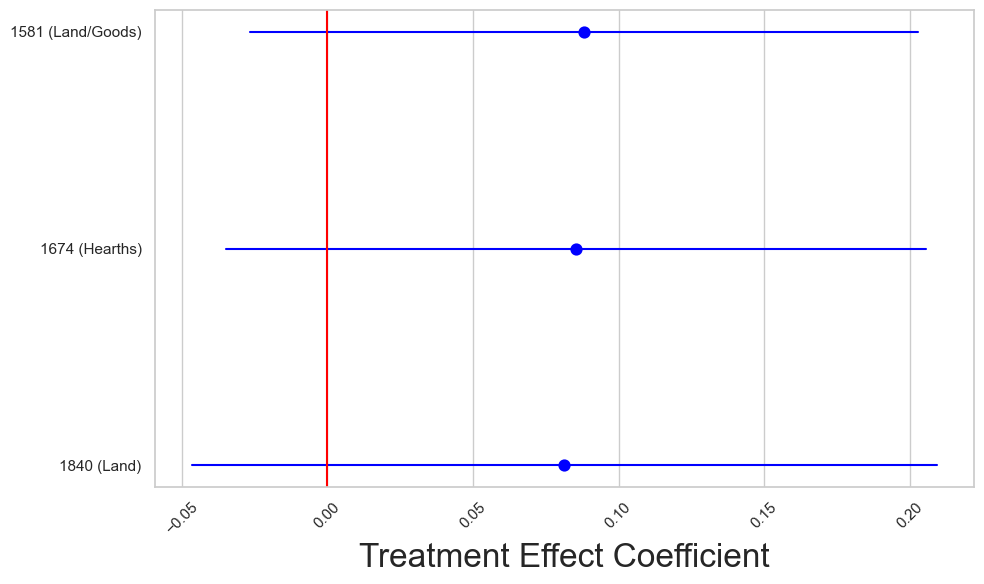

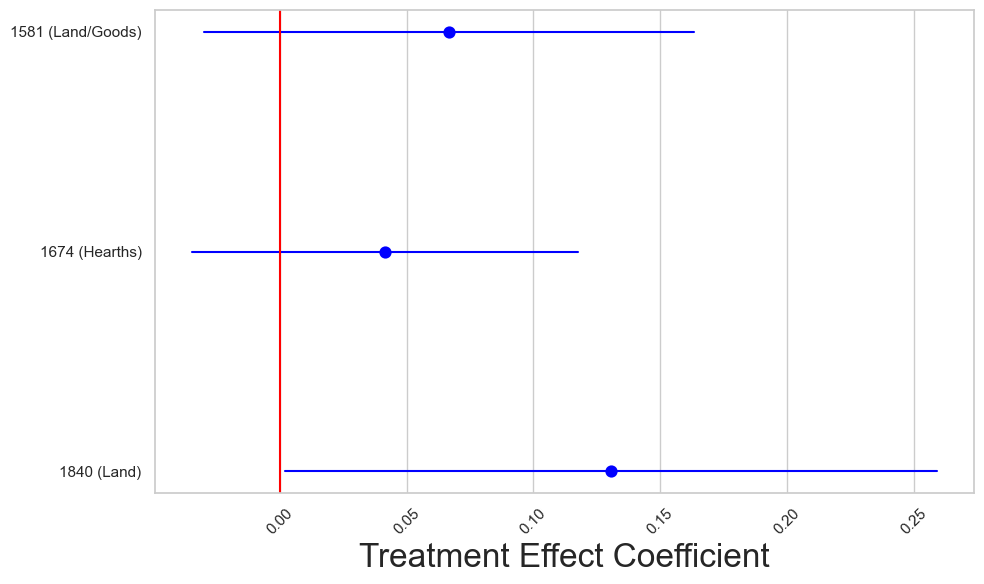

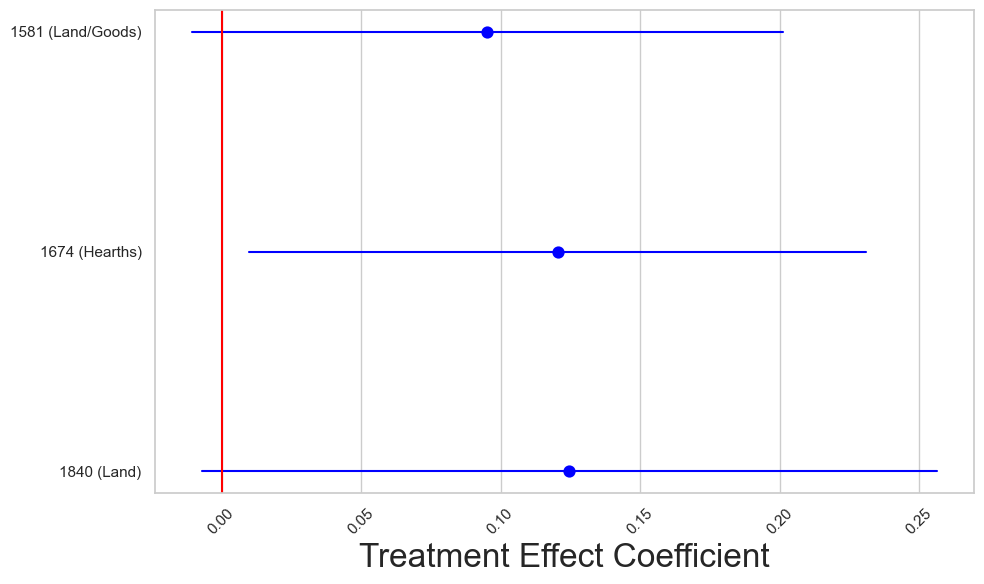

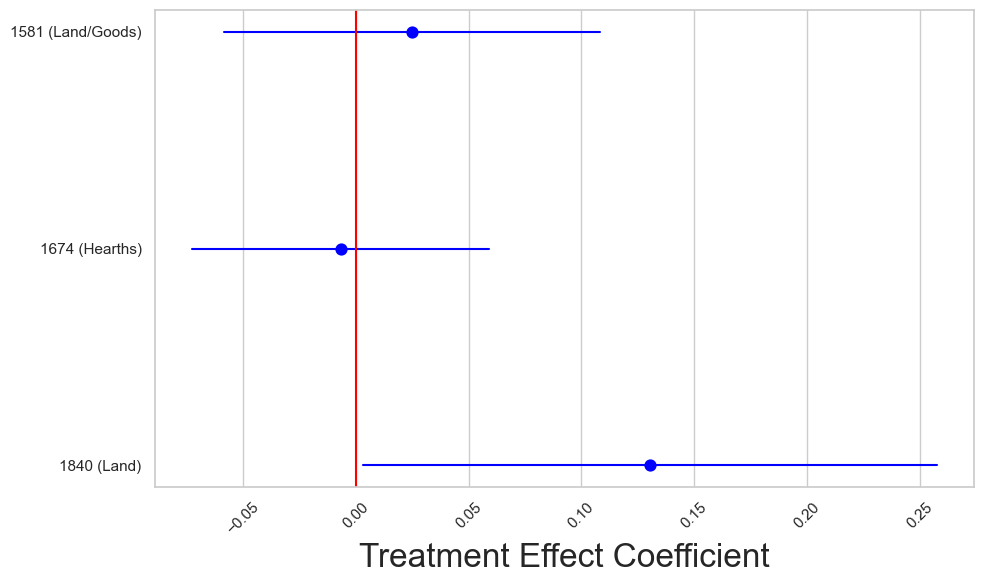

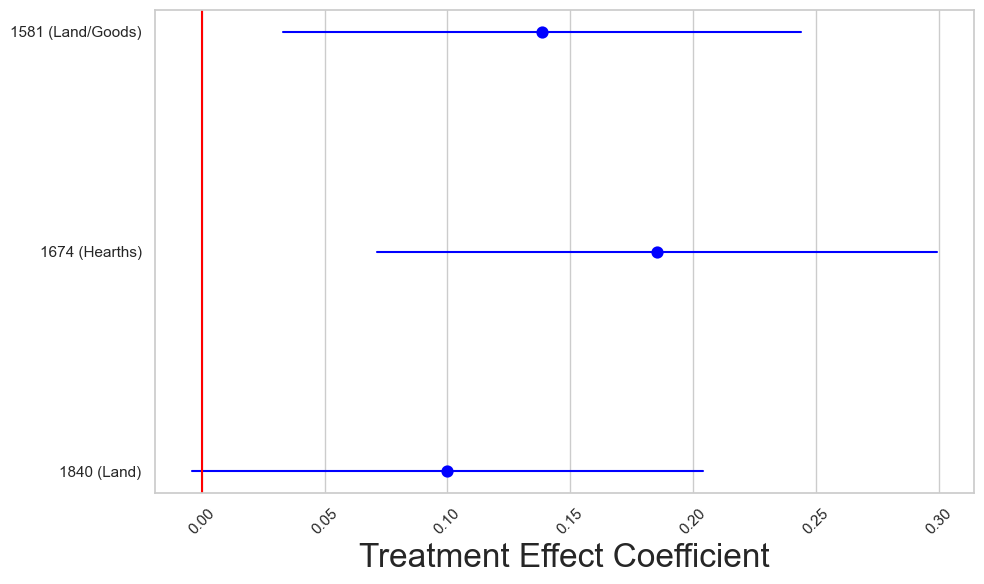

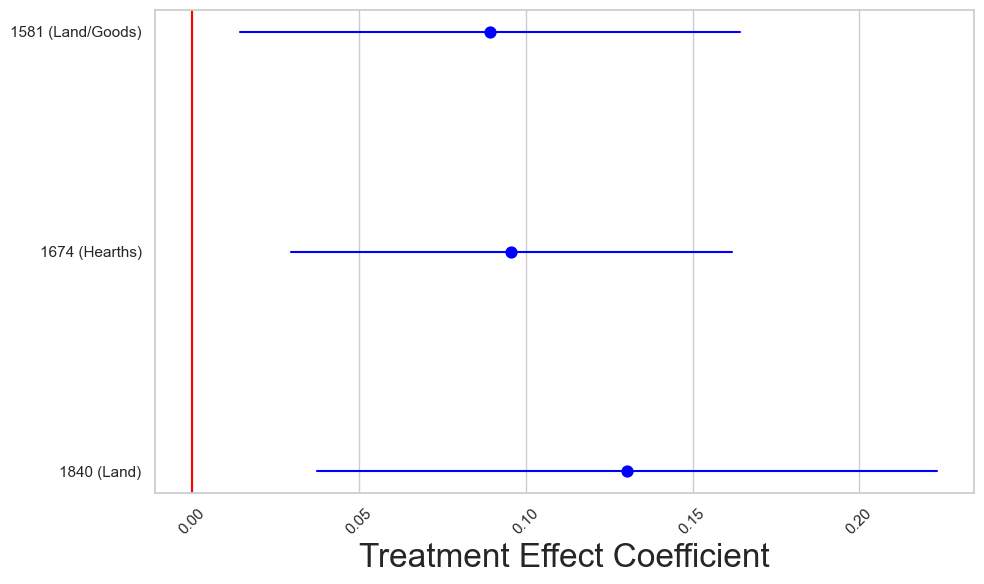

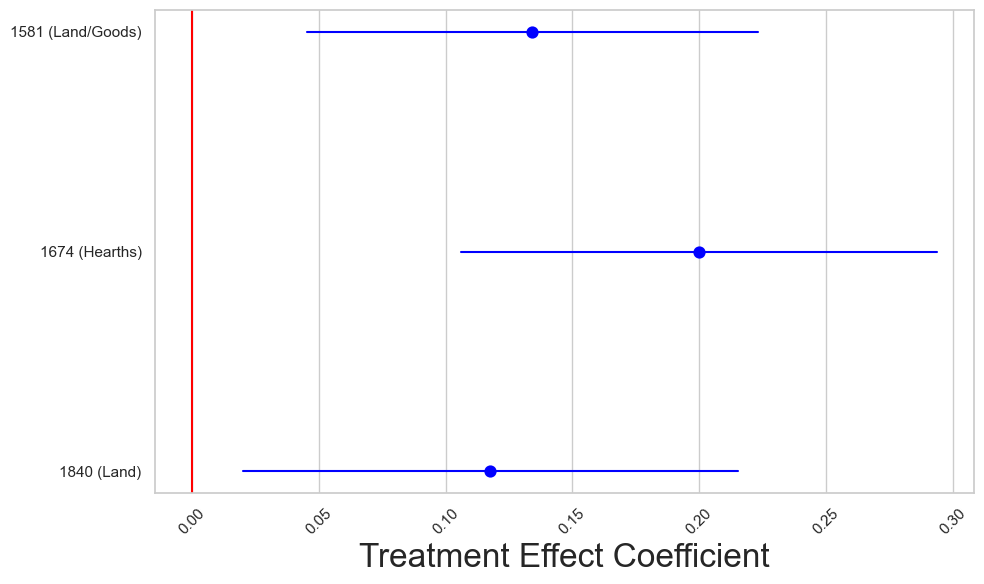

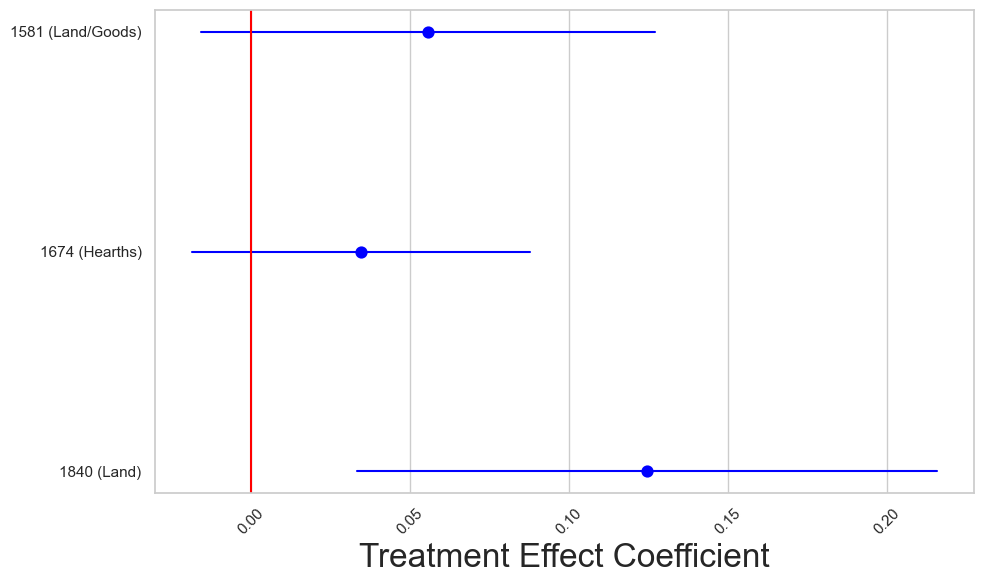

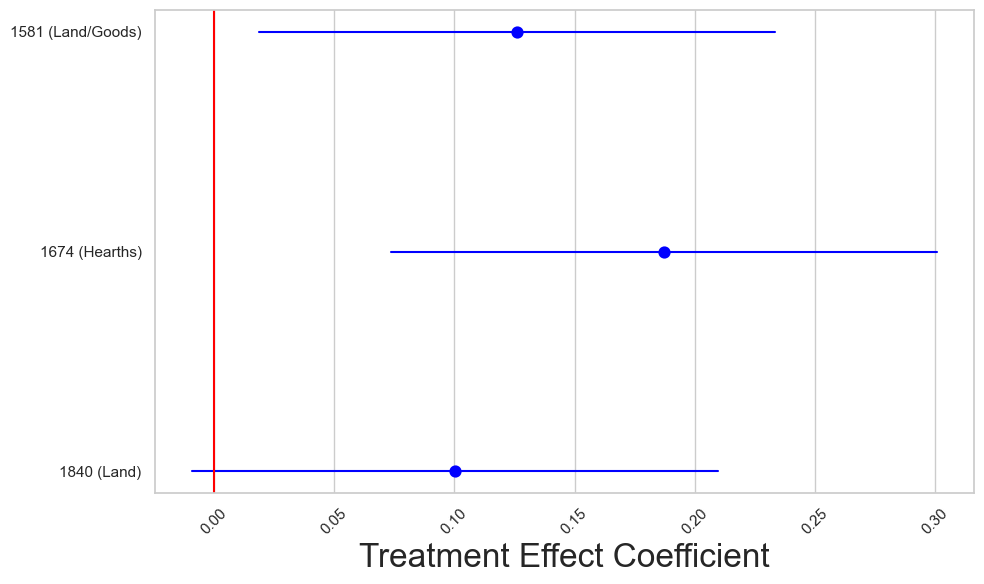

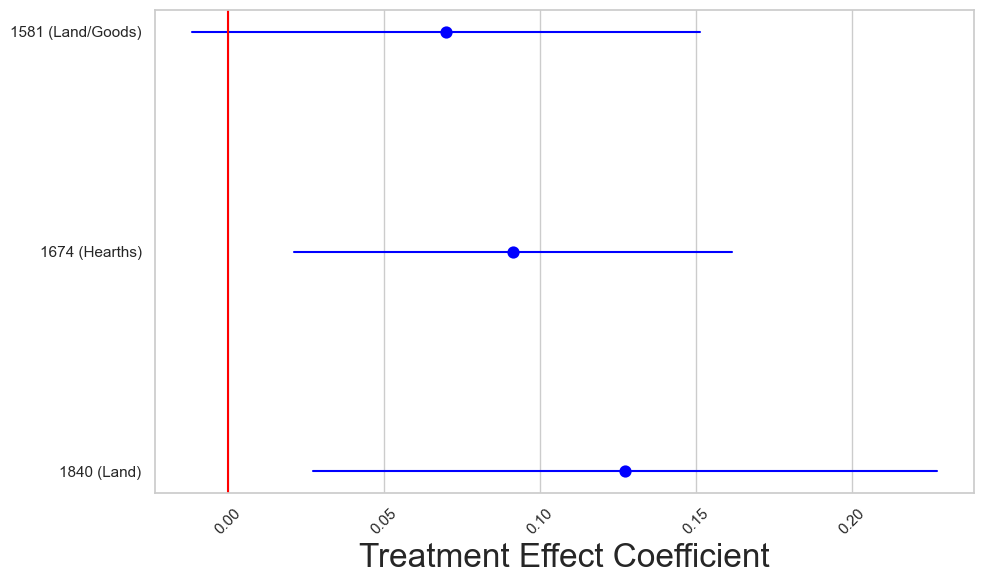

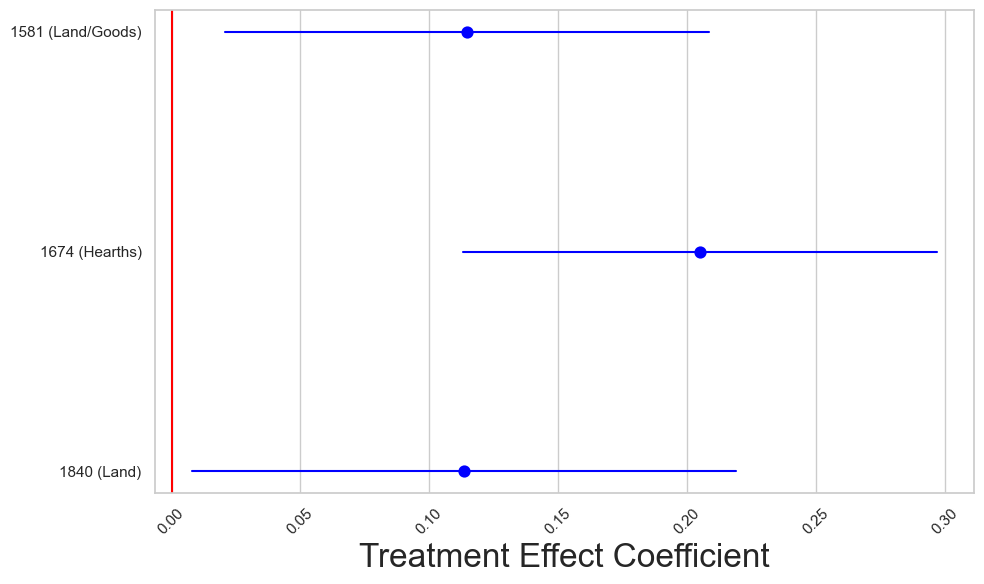

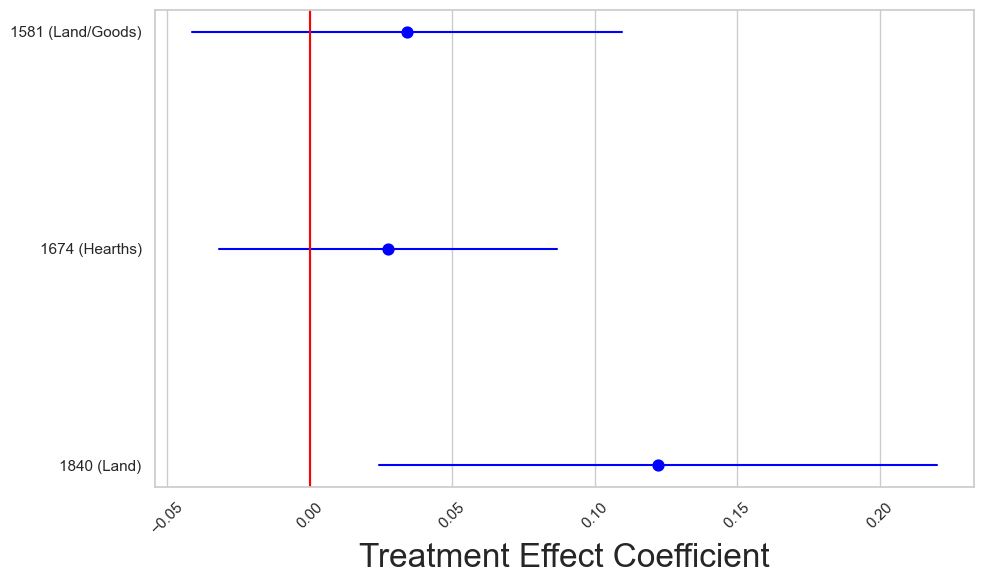

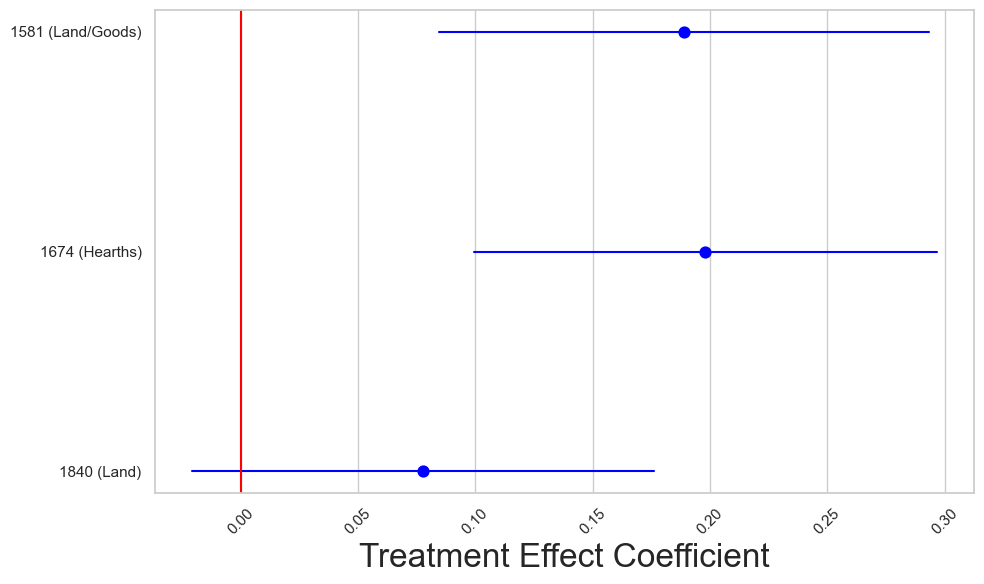

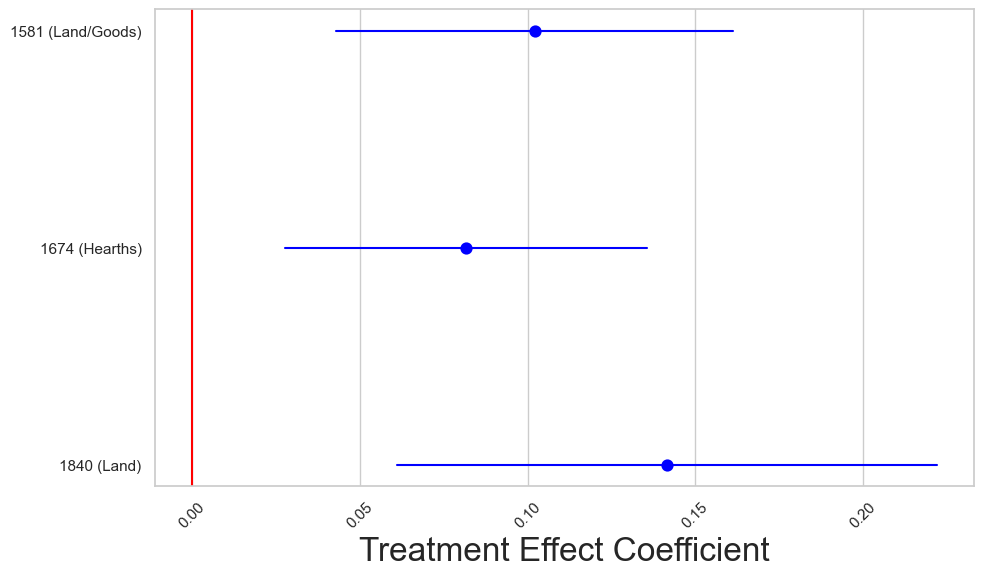

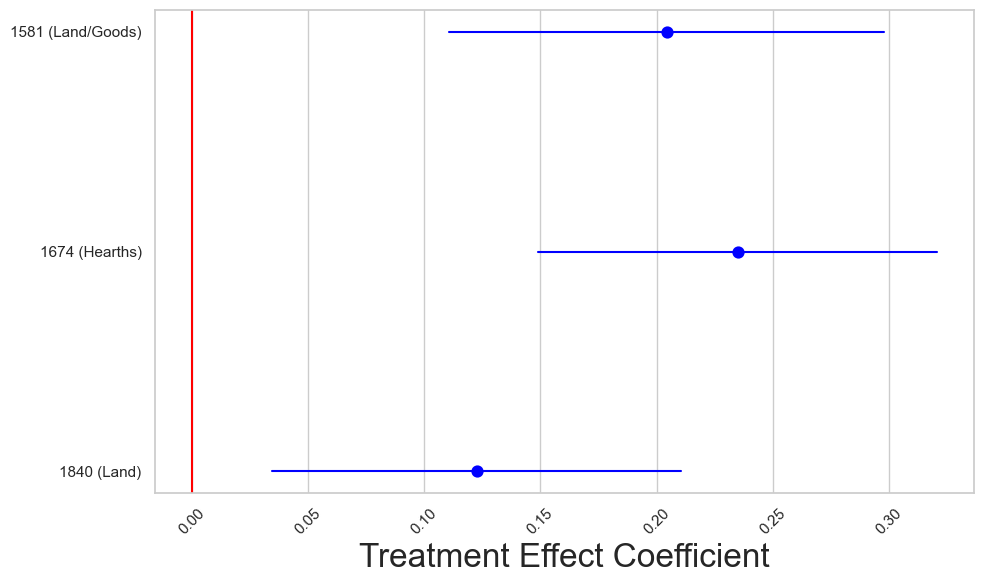

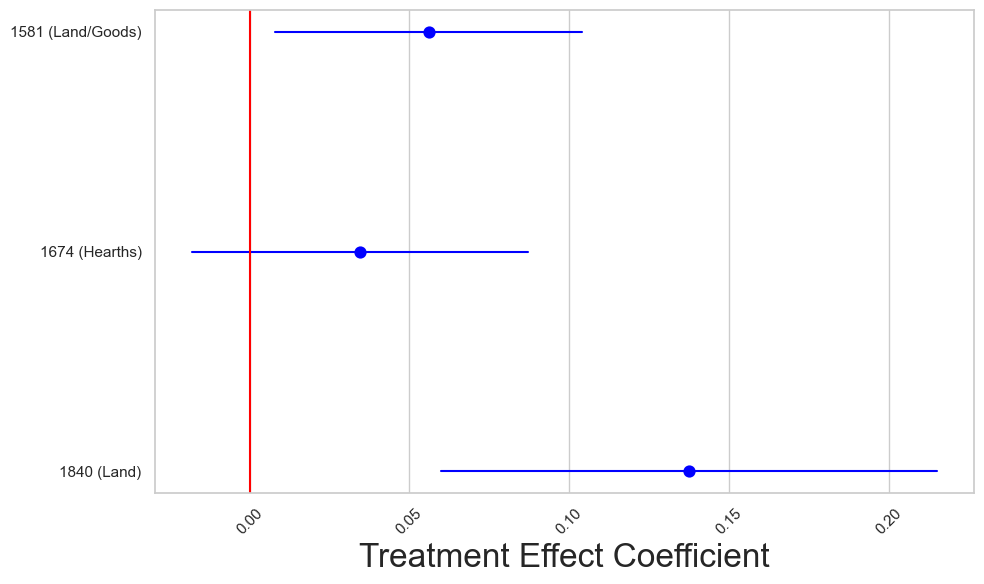

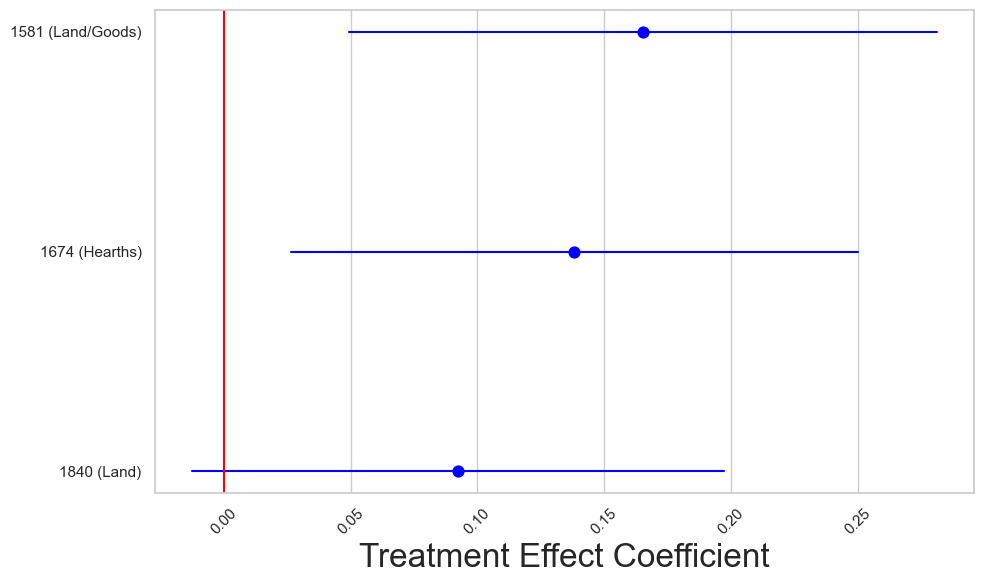

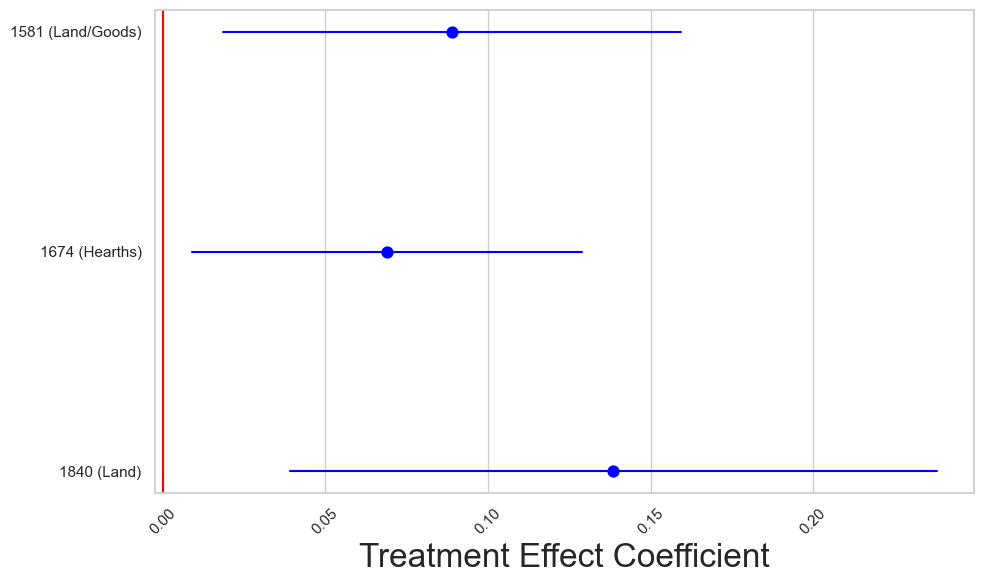

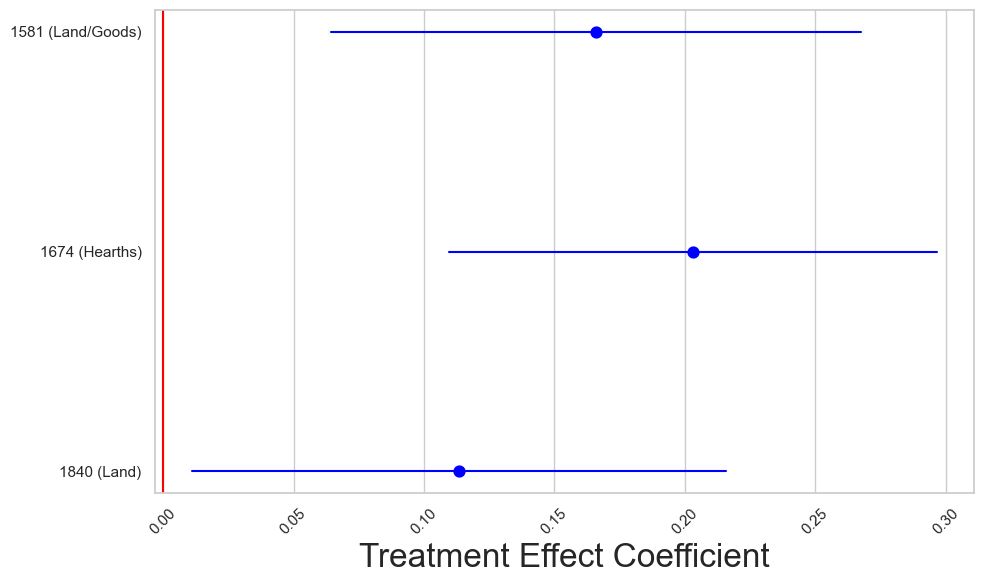

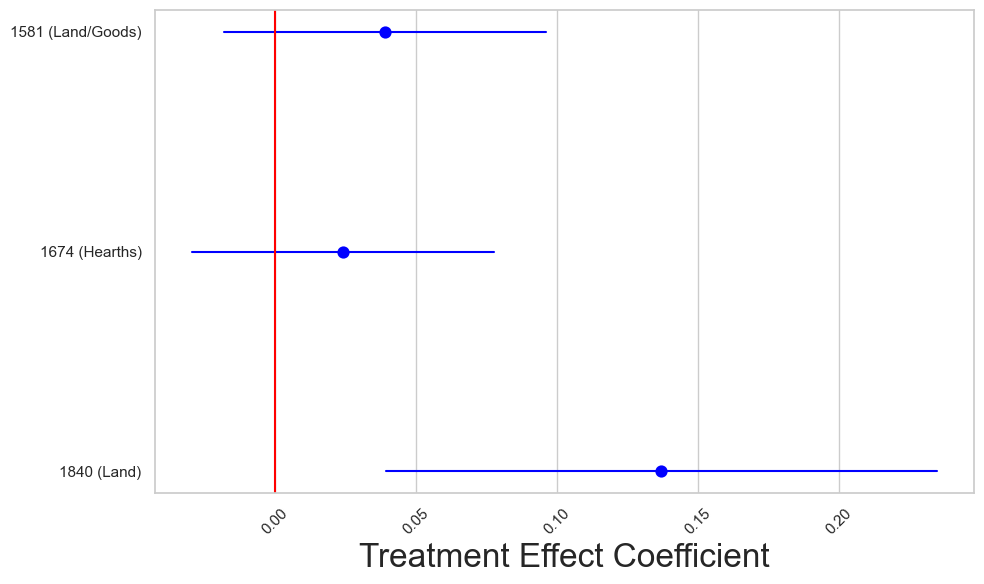

In [ ]:
for id_type in [
    'unique',
    'group',
    'combined',
    'metaphone',
    'master'
]:

    df = pd.read_csv(f'{SURNAMES}/{id_type}_id_subsidy_data.csv')

    with open(f'{PROCESSED}/pretty_dict.json', 'r', encoding='utf-8') as f:
        pretty_dict = json.load(f)

    for year in [
        1524, 
        1543,
        1581,
        1674,
        1840
    ]:
        for measure in [
            'avg_val',
            'tot_val',
            'max_val',
            'count',
        ]:
            # fill zeroes with nan
            df[f'{measure}_{year}'] = df[f'{measure}_{year}'].apply(lambda x: 0 if pd.isna(x) else x)

    years_list = [1524, 1581, 1674, 1840]
    for measure in [
        'avg_val',
        'tot_val',
        'max_val',
        'count'
    ]:

        results_list = []
        plot_df_list = []
        for i, year in enumerate(years_list):
            if year == 1524:
                continue
            last_year = years_list[i - 1]

            sub_df = df.copy()
            sub_df = sub_df.loc[~pd.isna(sub_df['control2_group'])]
            sub_df[f'{measure}_pctile_1524'] = sub_df[f'{measure}_{1524}'].rank(pct=True)
            sub_df[f'{measure}_pctile_{year}'] = sub_df[f'{measure}_{year}'].rank(pct=True)
            sub_df[f'{measure}_pctile_{last_year}'] = sub_df[f'{measure}_{last_year}'].rank(pct=True)


            x_vars = ['ln_parish_monastic_land', f'ln_parish_avg_value_{last_year}', f'parish_pop_density_{last_year}', 'parish_distriver', 'parish_distmkt']

            sub_df = sub_df.dropna(subset=[f'{measure}_{year}'] + x_vars + ['treatment', 'control'])

            x = sub_df[['treatment'] + x_vars]
            dummies = pd.get_dummies(sub_df['control2_group'], prefix='Control2', drop_first=True, dtype=int)
            x = pd.concat([x, dummies], axis=1)
            
            x.rename(columns={
                'treatment': 'Treatment',
                'control': 'Control',
                f'avg_val_pctile_{last_year}': f'Previous Avg Value Percentile',
                f'tot_val_pctile_{last_year}': f'Previous Total Value Percentile',
                f'max_val_pctile_{last_year}': f'Previous Max Value Percentile',
                f'count_pctile_{last_year}': f'Previous Count Percentile',
                f'avg_val_pctile_1524': f'1524 Avg Value Percentile',
                f'tot_val_pctile_1524': f'1524 Total Value Percentile',
                f'max_val_pctile_1524': f'1524 Max Value Percentile',
                f'count_pctile_1524': f'1524 Count Percentile',
                f'parish_avg_value_{last_year}': 'Previous Parish Avg Value',
                f'parish_pop_density_{last_year}': 'Previous Parish Pop Density',
                'ln_parish_monastic_land': 'ln(Parish Monastic Land)',
                f'ln_parish_avg_value_{last_year}': 'ln(Previous Parish Avg Value)',
                f'parish_pop_density_{last_year}': 'Previous Parish Pop Density',
                'parish_distriver': 'Parish Distance to River',
                'parish_distmkt': 'Parish Distance to Market'
            }, inplace=True)
            y = sub_df[f'{measure}_pctile_{year}']
            x = sm.add_constant(x)
            x_cols = x.columns.tolist()
            for col in x_cols:
                if not col.startswith('Control2_'):
                    continue
                if x[col].sum() < 2:
                    x.drop(columns=[col], inplace=True)
                    print(f'Removing column:', col)

            
            model = sm.OLS(y, x)
            result = model.fit(cov_type='HC3')
            results_list.append(result)
            
            plot_df_list.append({
                'year': year,
                'coef': result.params['Treatment'],
                'se': result.bse['Treatment']
            })

        table = summary_col(results_list, stars=True, model_names=years_list[1:], info_dict={'N': lambda x: "{0:d}".format(int(x.nobs))}).as_latex()
        
        table = table.replace('\\begin{center}', '\\begin{center}\n\\resizebox{\\textwidth}{!}{')
        table = table.replace('\\end{tabular}', '\\end{tabular}\n}')
        table = table.replace('p<', 'p$<$')
        table = re.sub(r'(Control2[^\n]*\n\s*&[^\n]*\n)+', r'Match-Group Dummies & Y & Y & Y \\\\ \n', table)
        print(f'Writing table for {id_type.title()} and {measure}')
        print(table)
        with open(f'{TABLES}/{id_type}_{measure}_matched_results_zeroes_1524.tex', 'w', encoding='utf-8') as f:
            f.write(table)

        plot_df = pd.DataFrame(plot_df_list)
        plot_df['lower'] = plot_df['coef'] - 1.96 * plot_df['se']
        plot_df['upper'] = plot_df['coef'] + 1.96 * plot_df['se']
        plot_df['year'] = plot_df['year'].astype(str)
        year_replace = {'1581': '1581 (Land/Goods)',
                        '1674': '1674 (Hearths)',
                        '1840': '1840 (Land)'}
        plot_df['year'] = plot_df['year'].replace(year_replace)
        plt.figure(figsize=(10, 6))
        sns.set_theme(style='whitegrid')
        sns.pointplot(data=plot_df, x='coef', y='year', ci=None, markers='o', color='blue', linestyle=None, join=False)
        for i, row in plot_df.iterrows():
            plt.plot([row['lower'], row['upper']], [row['year'], row['year']], color='blue')
        plt.xticks(rotation=45)
        plt.ylabel(None)
        plt.xlabel('Treatment Effect Coefficient', fontsize=24)
        plt.tight_layout()
        plt.axvline(x=0, color='red')
        plt.savefig(f'{IMAGES}/{id_type}_{measure}_treatment_effects_zeroes_1524.png', dpi=300)


#### Wide-To-Long, Then Graph Control, Treatment, and All

In [19]:

sns.set_theme(style='white')
for id_type in [
    'unique',
    'group',
    'combined',
    'metaphone',
    'master'
]:
    print(f'Plotting percentiles for {id_type} id type')
    df = pd.read_csv(f'{SURNAMES}/{id_type}_id_subsidy_data.csv')

    for year in [
        1524,
        1581,
        1674,
        1840
    ]:
        for measure in [
            'avg_val',
            'tot_val',
            'max_val',
            'count',
        ]:
            # fill zeroes with nan
            df[f'{measure}_{year}'] = df[f'{measure}_{year}'].apply(lambda x: 0 if pd.isna(x) else x)
            df = df.drop(columns=[f'{measure}_pctile'], errors='ignore')
            df[f'{measure}_pctile_{year}'] = df[f'{measure}_{year}'].rank(pct=True)

    ldf = pd.wide_to_long(
        df,
        stubnames=['avg_val_pctile', 'tot_val_pctile', 'max_val_pctile', 'count_pctile'],
        i=['id'],
        j='year',
        sep='_',
        suffix='\\d+'
    ).reset_index()

    for measure in [
        'avg_val',
        'tot_val',
        'max_val',
        'count'
    ]:
        # Grab only treatment and control groups
        ldf = ldf.loc[(ldf['treatment'] == 1) | (ldf['control'] == 1)].copy()
        treatment_df = ldf.groupby(['year', 'treatment'])[f'{measure}_pctile'].mean().reset_index()
        treatment_df['treatment'] = treatment_df['treatment'].map({0: 'Control', 1: 'Treatment'})
        treatment_df.rename(columns={'treatment': 'Treatment Group'}, inplace=True)
        plt.figure(figsize=(10, 6))
        sns.lineplot(data=treatment_df, 
                     x='year', 
                     y=f'{measure}_pctile', 
                     hue='Treatment Group',
                     hue_order=['Treatment', 'Control'],
                     marker='o')
        # plt.title(f'{pretty_dict[measure]} Percentile by Treatment Group')
        plt.xlabel('Year', fontsize=24)
        plt.ylabel(f'{pretty_dict[measure]} Percentile', fontsize=24)
        plt.xticks(treatment_df['year'].unique())
        plt.tick_params(axis='both', which='major', labelsize=21)
        plt.tight_layout()
        plt.savefig(f'{IMAGES}/{id_type}_{measure}_percentile_plot_zeroes.png')
        plt.close()


Plotting percentiles for unique id type
Plotting percentiles for group id type
Plotting percentiles for combined id type
Plotting percentiles for metaphone id type
Plotting percentiles for master id type


#### Same as Above, Zeroes Replaced With NaN

In [20]:

sns.set_theme(style='white')
for id_type in [
    'unique',
    'group',
    'combined',
    'metaphone',
    'master'
]:
    print(f'Plotting percentiles for {id_type} id type')
    df = pd.read_csv(f'{SURNAMES}/{id_type}_id_subsidy_data.csv')

    for year in [
        1524,
        1581,
        1674,
        1840
    ]:
        for measure in [
            'avg_val',
            'tot_val',
            'max_val',
            'count',
        ]:
            # fill zeroes with nan
            df[f'{measure}_{year}'] = df[f'{measure}_{year}'].apply(lambda x: np.nan if x==0 else x)
            df = df.drop(columns=[f'{measure}_pctile'], errors='ignore')
            df[f'{measure}_pctile_{year}'] = df[f'{measure}_{year}'].rank(pct=True)

    ldf = pd.wide_to_long(
        df,
        stubnames=['avg_val_pctile', 'tot_val_pctile', 'max_val_pctile', 'count_pctile'],
        i=['id'],
        j='year',
        sep='_',
        suffix='\\d+'
    ).reset_index()

    for measure in [
        'avg_val',
        'tot_val',
        'max_val',
        'count'
    ]:
        # Grab only treatment and control groups
        ldf = ldf.loc[(ldf['treatment'] == 1) | (ldf['control'] == 1)].copy()
        treatment_df = ldf.groupby(['year', 'treatment'])[f'{measure}_pctile'].mean().reset_index()
        treatment_df['treatment'] = treatment_df['treatment'].map({0: 'Control', 1: 'Treatment'})
        treatment_df.rename(columns={'treatment': 'Treatment Group'}, inplace=True)
        plt.figure(figsize=(10, 6))
        sns.lineplot(data=treatment_df, 
                     x='year', 
                     y=f'{measure}_pctile', 
                     hue='Treatment Group',
                     hue_order=['Treatment', 'Control'],
                     marker='o')
        # plt.title(f'{pretty_dict[measure]} Percentile by Treatment Group')
        plt.xlabel('Year', fontsize=24)
        plt.ylabel(f'{pretty_dict[measure]} Percentile', fontsize=24)
        plt.xticks(treatment_df['year'].unique())
        plt.tick_params(axis='both', which='major', labelsize=21)
        plt.tight_layout()
        plt.savefig(f'{IMAGES}/{id_type}_{measure}_percentile_plot.png')
        plt.close()


Plotting percentiles for unique id type
Plotting percentiles for group id type
Plotting percentiles for combined id type
Plotting percentiles for metaphone id type
Plotting percentiles for master id type
